# Import data and libraries

In [1]:
quick_run = False

numero_de_experimento = 1

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from data_experts.learning_functions import *

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cleaning for trainning

In [5]:
df = pd.read_csv("../data/electronics_features_to_analyze.csv").drop("Unnamed: 0", axis = 1)

In [6]:
# Añadir columnas aleatorias
I, J = 1, 1
df = add_categorical_random(df, num_random_columns=I)
df = add_numerical_random(df, num_random_columns=J)

In [7]:
# Definir las características categóricas y numéricas
# Columnas numéricas
target = "sold_quantity"
numerical_features = [
    'price', 
    #'initial_quantity',
    'available_quantity', 
    'sold_quantity', 
    'installment_quantity', 
    'installment_rate', 
    'days_until_discount_end', 
    'msi', 
    'discount'
]+ [f'num_random_{i}' for i in range(J)]

numerical_features.remove(target)

# Columnas categóricas
categorical_features = [
    'buying_mode', 
    'query', 
    'condition', 
    'brand', 
    'domain_id', 
    'listing_type_id', 
    'is_official_store', 
    'free_shipping', 
    'store_pick_up', 
] +  [f'cat_random_{i}' for i in range(I)]


In [8]:
quasinormal_features, non_normal_features = partition_numerical_features(df, numerical_features)
print(quasinormal_features, non_normal_features)

['num_random_0'] ['price', 'available_quantity', 'installment_quantity', 'installment_rate', 'days_until_discount_end', 'msi', 'discount']


In [9]:
df_clean = remove_outliers(df, numerical_features, exclude = ["days_until_discount_end"])
print(len(df_clean)/len(df), " from data left after outlier removing")

0.9769345238095238  from data left after outlier removing


In [10]:
df = df_clean

In [11]:
X = df[numerical_features + categorical_features]  # Aquí asegúrate de que las nuevas columnas estén incluidas
y = df[target]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom metrics

In [12]:
normalized_rmse_scorer = make_scorer(normalized_rmse, greater_is_better=False)

# Training Pipelines

In [13]:
best_models = {}

In [14]:
# Random Forest
rf_pipeline = build_pipeline(
    RandomForestRegressor(random_state=42),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}
rf_best_model, rf_grid_search = run_grid_search(
    rf_pipeline,
    rf_param_grid,
    X_train,
    y_train,
    scoring = normalized_rmse_scorer
)
rf_results_df = calculate_and_compile_metrics("Random Forest", rf_best_model, X_train, X_test, y_train, y_test, rf_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [15]:
rf_results_df

train_MSE  train_RMSE  train_MAE  train_R2      test_MSE  test_RMSE  \
0 8,984,950.04    2,997.49     839.56      0.72 25,074,682.74   5,007.46   

   test_MAE  test_R2          Model  \
0  1,671.38     0.24  Random Forest   

                                         Best_Params  
0  {'model__max_depth': 20, 'model__min_samples_s...

In [16]:
# XGBoost
xgb_pipeline = build_pipeline(
    XGBRegressor(random_state=42),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
xgb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9]
}
xgb_best_model, xgb_grid_search = run_grid_search(xgb_pipeline, xgb_param_grid, X_train, y_train)
xgb_results_df = calculate_and_compile_metrics("XGBoost", xgb_best_model, X_train, X_test, y_train, y_test, xgb_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [17]:
# LightGBM
lgbm_pipeline = build_pipeline(
    LGBMRegressor(random_state=42, verbose=-1),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
lgbm_param_grid = {
    'model__num_leaves': [31, 50, 100],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 300]
}
lgbm_best_model, lgbm_grid_search = run_grid_search(lgbm_pipeline, lgbm_param_grid, X_train, y_train)
lgbm_results_df = calculate_and_compile_metrics("LightGBM", lgbm_best_model, X_train, X_test, y_train, y_test, lgbm_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Buscar outliers en el training set pues no tiene sentido que el error se dispare para el trainingset

In [18]:
#guardar los mejores resultados
best_models["rf_gr"] =   {"result":rf_best_model, "method": "grid", "r2_train":rf_results_df["train_R2"].iloc[0], "r2_test":rf_results_df["test_R2"].iloc[0]}
best_models["xgb_gr"] =  {"result":xgb_best_model, "method": "grid", "r2_train":xgb_results_df["train_R2"].iloc[0], "r2_test":xgb_results_df["test_R2"].iloc[0]}
best_models["lgbm_gr"] = {"result":lgbm_best_model, "method": "grid", "r2_train":lgbm_results_df["train_R2"].iloc[0], "r2_test":lgbm_results_df["test_R2"].iloc[0]}


# Results and choosing the best model

### Random Forest

In [19]:
#for bayesian models

best_score_test = lambda test_scores: max(test_scores)
best_score_train = lambda train_scores, test_scores: train_scores[test_scores.index(max(test_scores))]


In [20]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'available_quantity',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [21]:
rf_results_df

train_MSE  train_RMSE  train_MAE  train_R2      test_MSE  test_RMSE  \
0 8,984,950.04    2,997.49     839.56      0.72 25,074,682.74   5,007.46   

   test_MAE  test_R2          Model  \
0  1,671.38     0.24  Random Forest   

                                         Best_Params  
0  {'model__max_depth': 20, 'model__min_samples_s...

In [22]:
rf_param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (10, 30),
    'min_samples_split': (2, 10)
}

best_params_rf, train_scores_rf, test_scores_rf = bayesian_optimization2(
    RandomForestRegressor, 
    rf_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.2491    | 17.49     | 9.606     | 246.4     |
| 2         | 0.2279    | 21.97     | 3.248     | 131.2     |
| 3         | 0.2457    | 11.16     | 8.929     | 220.2     |
| 4         | 0.2166    | 24.16     | 2.165     | 294.0     |
| 5         | 0.2197    | 26.65     | 3.699     | 136.4     |
| 6         | 0.2467    | 29.26     | 10.0      | 231.9     |
| 7         | 0.2061    | 30.0      | 2.0       | 202.5     |
| 8         | 0.2561    | 16.85     | 9.16      | 245.5     |
| 9         | 0.2419    | 16.16     | 7.93      | 241.2     |
| 10        | 0.2443    | 13.19     | 7.899     | 246.1     |
| 11        | 0.2375    | 17.81     | 5.315     | 245.4     |
| 12        | 0.2384    | 14.65     | 10.0      | 243.8     |
| 13        | 0.2354    | 19.04     | 9.456     | 243.5     |
| 14        | 0.2435    | 15.86     | 7.838     | 247.2     |
| 15    

In [23]:
show_training(train_scores_rf, test_scores_rf).loc[[5, 18, 26]]

train  test
5    0.64  0.25
18   0.68  0.23
26   0.67  0.24

Se muestra un valor bastante inusual pues en los parametros que se obtuvo menor error para el training set, el test set tuvo errores muy pequeños 

In [24]:
best_params_rf

{'max_depth': 11, 'min_samples_split': 8, 'n_estimators': 217}

In [25]:
rf_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'available_quantity',
                                                   'insta...t_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, min_samples_split=5,
                                       random_state=42))])

In [26]:
best_model_r2_train =best_score_train(train_scores_rf, test_scores_rf),
best_model_r2_test = best_score_test(test_scores_rf)
best_models["rf_bayes"] = {"result":best_params_rf, "method": "bayes_rs42",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



In [27]:
best_models

{'rf_gr': {'result': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num_quasinormal',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     StandardScaler(with_mean=False))]),
                                                    ['num_random_0']),
                                                   ('num_non_normal',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     MinMaxScaler())]),
               

### XGB

In [28]:
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'available_quantity',
                                                   'insta...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [29]:
xgb_results_df

train_MSE  train_RMSE  train_MAE  train_R2      test_MSE  test_RMSE  \
0 12,953,061.51    3,599.04   1,371.19      0.59 28,988,588.46   5,384.11   

   test_MAE  test_R2    Model  \
0  2,021.54     0.13  XGBoost   

                                         Best_Params  
0  {'model__learning_rate': 0.01, 'model__max_dep...

In [30]:
xgb_results_df["Best_Params"].iloc[0]

{'model__learning_rate': 0.01,
 'model__max_depth': 6,
 'model__n_estimators': 100}

In [31]:
xgb_param_bounds = {
    'n_estimators': (100, 400),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (1, 6)
}

best_params_xgb, train_scores_xgb, test_scores_xgb = bayesian_optimization2(
    XGBRegressor,
    xgb_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.1446    | 0.1186    | 14.41     | 4.66      | 279.6     |
| 2         | 0.08773   | 0.05525   | 4.872     | 1.29      | 359.9     |
| 3         | -0.1663   | 0.1843    | 11.5      | 1.103     | 391.0     |
| 4         | 0.159     | 0.2514    | 5.548     | 1.909     | 155.0     |
| 5         | -0.08699  | 0.09823   | 9.297     | 3.16      | 187.4     |
| 6         | -0.1094   | 0.2545    | 6.132     | 3.068     | 155.2     |
| 7         | -0.1334   | 0.2811    | 12.9      | 2.974     | 237.6     |
| 8         | 0.2477    | 0.29      | 8.713     | 4.426     | 387.2     |
| 9         | 0.1373    | 0.161     | 9.634     | 5.989     | 200.3     |
| 10        | -0.1038   | 0.175     | 7.354     | 3.268     | 107.8     |
| 11        | 0.1909    | 0.2817    | 12.01     | 2.449     | 361.0     |
| 12        | -0.07999  | 0.08234   | 

In [32]:
show_training(train_scores_xgb, test_scores_xgb).loc[[5,7]]

train  test
5   1.00 -0.11
7   1.00  0.25

In [33]:
best_model_r2_train =best_score_train(train_scores_xgb, test_scores_xgb),
best_model_r2_test = best_score_test(test_scores_xgb)
best_models["xgb_bayes"] = {"result":best_params_xgb, "method": "bayes_rs42",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



### LGBM

In [34]:
lgbm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'available_quantity',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model', LGBMRegressor(random_state=42, verbose=-1))])

In [35]:
lgbm_results_df

train_MSE  train_RMSE  train_MAE  train_R2      test_MSE  test_RMSE  \
0 19,307,909.63    4,394.08   1,356.37      0.39 26,982,607.77   5,194.48   

   test_MAE  test_R2     Model  \
0  1,875.31     0.19  LightGBM   

                                         Best_Params  
0  {'model__learning_rate': 0.01, 'model__n_estim...

In [36]:
lgbm_results_df["Best_Params"].iloc[0]

{'model__learning_rate': 0.01,
 'model__n_estimators': 200,
 'model__num_leaves': 31}

In [37]:
lgb_param_bounds = {
    'n_estimators': (100, 300),
    'num_leaves': (20, 100),
    'learning_rate': (0.01, 0.2)
}
best_params_lgb, train_scores_lgb, test_scores_lgb = bayesian_optimization2(
    LGBMRegressor, 
    lgb_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
| 1         | -0.01941  | 0.08116   | 290.1     | 78.56     |
| 2         | 0.02179   | 0.1237    | 131.2     | 32.48     |
| 3         | 0.1382    | 0.02104   | 273.2     | 68.09     |
| 4         | 0.02056   | 0.1445    | 104.1     | 97.59     |
| 5         | -0.02672  | 0.1682    | 142.5     | 34.55     |
| 6         | 0.1798    | 0.01      | 270.0     | 66.15     |
| 7         | 0.009327  | 0.0603    | 259.0     | 66.81     |
| 8         | 0.1796    | 0.01      | 272.0     | 61.48     |
| 9         | 0.1798    | 0.01      | 268.4     | 52.71     |
| 10        | 0.1788    | 0.01      | 277.7     | 48.42     |
| 11        | -0.1447   | 0.2       | 269.5     | 39.49     |
| 12        | -0.1406   | 0.2       | 279.8     | 55.58     |
| 13        | 0.1798    | 0.01      | 268.3     | 57.87     |
| 14        | 0.1801    | 0.01      | 263.2     | 54.68     |
| 15    

In [38]:
show_training(train_scores_lgb, test_scores_lgb).loc[[1, 2, 3]]

train  test
1   0.81  0.02
2   0.57  0.14
3   0.79  0.02

In [39]:
best_model_r2_train =best_score_train(train_scores_lgb, test_scores_lgb),
best_model_r2_test = best_score_test(test_scores_lgb)
best_models["lgb_bayes"] = {"result":best_params_lgb, "method": "bayes",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



### Red neuronal (un solo set de parámetros)

In [40]:
# Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
pipeline_preprocessor = build_pipeline(
    None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
    categorical_features,
    quasinormal_features,
    non_normal_features
)

# Ajuste del preprocesador para calcular input_dim
pipeline_preprocessor.fit(X_train, y_train)  # Ajuste completo del preprocesador
input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

# Ahora que sabemos input_dim, creamos el modelo y el pipeline completo
pipeline0 = build_pipeline(
    create_keras_model(input_dim=input_dim),
    categorical_features,
    quasinormal_features,
    non_normal_features
)

# Entrenar el modelo con el pipeline completo
pipeline0.fit(X_train, y_train)

# Evaluar el modelo
train_score = pipeline0.score(X_train, y_train)
test_score = pipeline0.score(X_test, y_test)

print(f"Train R2 Score: {train_score:.4f}")
print(f"Test R2 Score: {test_score:.4f}")


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 49485224.0000 - r2_score: -0.0694 
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 25498284.0000 - r2_score: -0.1074
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 29393548.0000 - r2_score: -0.0799
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 44182132.0000 - r2_score: -0.0586
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 29913684.0000 - r2_score: -0.0833
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 19241558.0000 - r2_score: -0.0691
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 19932338.0000 - r2_score: -0.0579
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 26589426.0000 - r2_score: -0.0170
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 37184404.0000 - r2_score: -0.0199
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 24657982.0000 - r2_score: 0.0074
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 13784733.0000 - r2_score: 0.3421
Epoch 65/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 23953360.0000 - r2_score: 0.2429
Epoch 66/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 12432299.0000 - r2_score: 0.4140
Epoch 67/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 7965207.5000 - r2_score: 0.4840
Epoch 68/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 16578370.0000 - r2_score: 0.2727
Epoch 69/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 9776220.0000 - r2_score: 0.3201
Epoch 70/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 15710520.0000 - r2_score: 0.2353
Epoch 71/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 26992466.0000 - r2_score: 0.2922
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 20729108.0000 - r2_score: 0.3294
Epoch 73/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 37403812.0000 - r2_score: 0.3067
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 249

In [41]:
pipeline0

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'available_quantity',
                                                   'insta...
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 KerasRegressor(build_fn=<function create_keras_model.<locals>.<lambda> at 0x2823bf9c0>))])

In [42]:
best_models["nn"] = {"result":pipeline0, "method": "fix_params",
                           "r2_train":pipeline0.score(X_train, y_train),
                           "r2_test": pipeline0.score(X_test, y_test)
                          }



33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


### Red Neuronal (Gridsearch)

In [43]:
if quick_run == False:
    # Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
    pipeline_preprocessor = build_pipeline(
        None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
        [],
        quasinormal_features,
        non_normal_features
    )

    X_train_n = X_train[numerical_features]
    X_test_n = X_test[numerical_features]
    # Ajuste del preprocesador para calcular input_dim
    pipeline_preprocessor.fit(X_train_n, y_train)  # Ajuste completo del preprocesador
    input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

    # Ahora que sabemos input_dim, creamos el pipeline completo
    pipeline = build_pipeline(
        MyKerasRegressor(input_dim=input_dim),
        [],
        quasinormal_features,
        non_normal_features,
        one_hot= False
    )

    # Definir los parámetros para el grid search
    param_grid = {
        'model__layers': [1, 2, 3],
        'model__units': [32, 64, 128],
        'model__activation': ['relu', 'tanh'],
        'model__optimizer': ['adam', 'rmsprop'],
        'model__epochs': [50, 100],  # Aquí agregamos epochs directamente al estimador
        'model__batch_size': [16, 32],
    }

    # Configurar GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)

    # Ejecutar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Imprimir los mejores parámetros y el mejor score
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor score (R2):", grid_search.best_score_)

    # Evaluar el modelo en el conjunto de prueba
    test_score = grid_search.score(X_test_n, y_test)
    print(f"Test R2 Score: {test_score:.4f}")
    
    best_models["nn_gridsearch"] = {"result":grid_search.best_params_,
                                "method": "grid_search",
                           "r2_train":grid_search.best_score_,
                           "r2_test": grid_search.score(X_test_n, y_test)
                          }


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 74944560.0000 - r2_score: -0.0641  
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 46226224.0000 - r2_score: -0.0738
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 39926368.0000 - r2_score: -0.0837
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 38094012.0000 - r2_score: -0.0915
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 33898800.0000 - r2_score: -0.0838
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 48052976.0000 - r2_score: -0.0794
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 18838764.0000 - r2_score: -0.1272
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 19384506.0000 - r2_score: -0.1589
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 45126280.0000 - r2_score: -0.0763
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 20296118.0000 - r2_score: -0

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 19475054.0000 - r2_score: -0.1179
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 27595386.0000 - r2_score: -0.1132
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 27407236.0000 - r2_score: -0.0877
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 38273712.0000 - r2_score: -0.0733
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 40004228.0000 - r2_score: -0.0836
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 30793936.0000 - r2_score: -0.0953
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 44936476.0000 - r2_score: -0.0781
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 42467488.0000 - r2_score: -0.0809
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 19022834.0000 - r2_score: -0.1136
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 22875570.0000 - r2_score: -0.1137
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 40450264.0000 - r2_score: -0.0785
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 41319120.0000 - r2_score: -0.0736
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 33103696.0000 - r2_score: -0.0748
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 30440404.0000 - r2_score: -0.0755
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 45467764.0000 - r2_score: -0.0564
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 39965860.0000 - r2_score: -0.0613
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 31612920.0000 - r2_score: -0.0763
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 26720410.0000 - r2_score: -0.0760
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 45222392.0000 - r2_score: -0.0639
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 37656872.0000 - r2_score: -0.0634
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 30674722.0000 - r2_score: -0.0430
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 37011244.0000 - r2_score: -0.0314
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 22239056.0000 - r2_score: -0.0455
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 29795170.0000 - r2_score: -0.0460
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 21286982.0000 - r2_score: -0.0477
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 33625748.0000 - r2_score: -0.0300
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 33148388.0000 - r2_score: -0.0505
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 36983192.0000 - r2_score: -0.0385
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 21481662.0000 - r2_score: -0.0362
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 46427608.0000 - r2_score: -0.0388
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 1

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 32761108.0000 - r2_score: -0.0862 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 27471550.0000 - r2_score: -0.0935
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 41597008.0000 - r2_score: -0.1072
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 24595872.0000 - r2_score: -0.0918
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 80946680.0000 - r2_score: -0.0556
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 21298912.0000 - r2_score: -0.1319
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 39004440.0000 - r2_score: -0.1024
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 28223316.0000 - r2_score: -0.0966
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 20877678.0000 - r2_score: -0.1085
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 33097044.0000 - r2_score: -0.0864
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 18825478

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 31660758.0000 - r2_score: -0.0801
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 32249132.0000 - r2_score: -0.0901
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 41626076.0000 - r2_score: -0.0704
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 31899790.0000 - r2_score: -0.0692
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 29046300.0000 - r2_score: -0.0611
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 57291772.0000 - r2_score: -0.0478
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 83234496.0000 - r2_score: -0.0368
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 34473664.0000 - r2_score: -0.0491
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 40914704.0000 - r2_score: -0.0786
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 24126212.0000 - r2_score: -0.0745
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 28626084.0000 - r2_score: -0.0527
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 24995458.0000 - r2_score: -0.0368
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 46020012.0000 - r2_score: -0.0305
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 44068392.0000 - r2_score: -0.0391
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 23300798.0000 - r2_score: -0.0285
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 35038904.0000 - r2_score: -0.0258
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 45762464.0000 - r2_score: -0.0262
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 34334788.0000 - r2_score: -0.0204
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 29571874.0000 - r2_score: -0.0206
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 33922344.0000 - r2_score: -0.0088
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 30359152.0000 - r2_score: -0.0189
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 30428858.0000 - r2_score: -0.0184
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 57255788.0000 - r2_score: -0.0176
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 24142466.0000 - r2_score: -0.0031
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 41310828.0000 - r2_score: -0.0683
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 24642072.0000 - r2_score: -0.0141
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 43028644.0000 - r2_score: -0.0135
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 23486406.0000 - r2_score: -0.0049
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 26283742.0000 - r2_score: -0.0206
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 21741578.0000 - r2_score: -0.0179
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 30156080.0000 - r2_score: -0.1157
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 15658329.0000 - r2_score: -0.1434
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 80492792.0000 - r2_score: -0.0759
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 24420112.0000 - r2_score: -0.1026
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 60945620.0000 - r2_score: -0.0717
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 14857334.0000 - r2_score: -0.1326
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 45192096.0000 - r2_score: -0.0724
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 27819360.0000 - r2_score: -0.0898
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 33315800.0000 - r2_score: -0.1043
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 16420249.0000 - r2_score: -0.1292
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 28952856

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 27643936.0000 - r2_score: -0.0919
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 28723210.0000 - r2_score: -0.0968
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 44749936.0000 - r2_score: -0.0611
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 40584056.0000 - r2_score: -0.0766
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 76231016.0000 - r2_score: -0.0778
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 46535032.0000 - r2_score: -0.0686
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 25118464.0000 - r2_score: -0.0939
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 35021024.0000 - r2_score: -0.0785
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 58575732.0000 - r2_score: -0.0588
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 18333900.0000 - r2_score: -0.1024
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 25414560.0000 - r2_score: -0.0901
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 51090456.0000 - r2_score: -0.0540
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 19300168.0000 - r2_score: -0.0916
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 65793688.0000 - r2_score: -0.0526
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 10553936.0000 - r2_score: -0.1593
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 31405854.0000 - r2_score: -0.0713
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 91069376.0000 - r2_score: -0.0537
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 23376172.0000 - r2_score: -0.0973
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 35152564.0000 - r2_score: -0.0604
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 50862512.0000 - r2_score: -0.0695
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 23288408.0000 - r2_score: -0.0672
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 23204834.0000 - r2_score: -0.0824
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 22875442.0000 - r2_score: -0.0740
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 20830174.0000 - r2_score: -0.0526
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 23837356.0000 - r2_score: -0.0548
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 31974950.0000 - r2_score: -0.0601
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 29626834.0000 - r2_score: -0.0524
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 34102612.0000 - r2_score: -0.0539
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 30746708.0000 - r2_score: -0.0533
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 24448284.0000 - r2_score: -0.0423
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 50556580.0000 - r2_score: -0.0764
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 33804680.0000 - r2_score: -0.0932
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 70199096.0000 - r2_score: -0.0608
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 50464556.0000 - r2_score: -0.0796
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 30368724.0000 - r2_score: -0.0942
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 57911008.0000 - r2_score: -0.0654
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 35923688.0000 - r2_score: -0.0974
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 43881796.0000 - r2_score: -0.0697
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 38673992.0000 - r2_score: -0.0880
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 35184464.0000 - r2_score: -0.0815
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 3009545

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 40724068.0000 - r2_score: -0.0855
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 25403852.0000 - r2_score: -0.1105
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 42222740.0000 - r2_score: -0.0694
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 18574564.0000 - r2_score: -0.0945
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 27415762.0000 - r2_score: -0.0960
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 13049696.0000 - r2_score: -0.1201
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 22810204.0000 - r2_score: -0.0971
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 27274730.0000 - r2_score: -0.0711
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 13965866.0000 - r2_score: -0.1037
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 54563428.0000 - r2_score: -0.0647
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 1

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 60445188.0000 - r2_score: -0.0428
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 31443504.0000 - r2_score: -0.0617
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 49986176.0000 - r2_score: -0.0591
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 34249552.0000 - r2_score: -0.0632
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 54072184.0000 - r2_score: -0.0455
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 39442548.0000 - r2_score: -0.0498
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 23856846.0000 - r2_score: -0.0864
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 47295280.0000 - r2_score: -0.0484
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 71942848.0000 - r2_score: -0.0345
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 30160454.0000 - r2_score: -0.0607
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 33835720.0000 - r2_score: 0.0173
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 27511556.0000 - r2_score: -0.0196
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 44480056.0000 - r2_score: -0.2087
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 52086304.0000 - r2_score: 0.0687
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 15951463.0000 - r2_score: 0.0177
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 32192470.0000 - r2_score: 0.0883
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 20338964.0000 - r2_score: -0.1983
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 26245584.0000 - r2_score: 0.1079
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 16904174.0000 - r2_score: 0.1139
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 52229680.0000 - r2_score: -0.0908 
Epoch 2/50
44/44 ━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 20667494.0000 - r2_score: -0.1278
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 55807900.0000 - r2_score: -0.0727
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 27000316.0000 - r2_score: -0.0919
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 53267768.0000 - r2_score: -0.0635
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 81124528.0000 - r2_score: -0.0503
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 35998060.0000 - r2_score: -0.0712
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 20359068.0000 - r2_score: -0.1051
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 54975808.0000 - r2_score: -0.0585
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 26723324.0000 - r2_score: -0.0713
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 33846716.0000 - r2_score: -0.0623
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 550805

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 15995029.0000 - r2_score: 0.0430
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 49074668.0000 - r2_score: 0.0427
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 63177648.0000 - r2_score: 0.0323
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 18138622.0000 - r2_score: 0.0521
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 94928176.0000 - r2_score: 0.0361
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 35570116.0000 - r2_score: 0.0512
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 23337710.0000 - r2_score: 0.0457
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 20834750.0000 - r2_score: 0.0776
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 30220262.0000 - r2_score: 0.0541
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 21470014.0000 - r2_score: -0.0409
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 25384374.0

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 19003424.0000 - r2_score: 0.0727
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 30247188.0000 - r2_score: 0.0744
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 18269028.0000 - r2_score: 0.0949
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 32633636.0000 - r2_score: 0.0444
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 33405404.0000 - r2_score: 0.0551
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 15371430.0000 - r2_score: 0.1222
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 21194800.0000 - r2_score: 0.1080
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 31932660.0000 - r2_score: 0.0831
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 32798176.0000 - r2_score: 0.0807
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 13433881.0000 - r2_score: 0.0421
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 17859002.00

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 25715528.0000 - r2_score: 0.0172
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 21054360.0000 - r2_score: 0.0967
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 58538644.0000 - r2_score: 0.0647
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 31824984.0000 - r2_score: 0.0128
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 19848386.0000 - r2_score: -0.2311
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 25524722.0000 - r2_score: 0.0392
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 16238180.0000 - r2_score: 0.0306
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 24817480.0000 - r2_score: 0.0820
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 28315884.0000 - r2_score: -0.1018
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 51351188.0000 - r2_score: -0.0725
Epoch 3/50
44/44 ━━━━━━━━━━━━━━

Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 29613574.0000 - r2_score: -0.0145
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 26235404.0000 - r2_score: -0.0039
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 44725472.0000 - r2_score: 0.0119
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 22508826.0000 - r2_score: 0.0372
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 20475084.0000 - r2_score: 0.0412
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 22005306.0000 - r2_score: 0.0486
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 21823290.0000 - r2_score: 0.0280
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 19068990.0000 - r2_score: 0.0676
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 13490809.0000 - r2_score: 0.0196
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 53245708.0000 - r2_score: 0.0461
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 43810428.0000 - r2_score: 0.0547
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 41968548.0000 - r2_score: 0.0178
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 33698084.0000 - r2_score: 0.0144
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 13788170.0000 - r2_score: -0.0245
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 40603056.0000 - r2_score: 0.0610
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 20167772.0000 - r2_score: 0.0839
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 22907460.0000 - r2_score: 0.0831
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 37447076.0000 - r2_score: 0.0611
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 31137654.0000 - r2_score: 0.0579
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 48831736.0000 - r2_score: 0.0629
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 42834768.0

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 53263188.0000 - r2_score: 0.0034
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 75109216.0000 - r2_score: 0.0112
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 50256192.0000 - r2_score: 0.0123
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 23873258.0000 - r2_score: 0.0339
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 19143756.0000 - r2_score: 0.0284
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 40527804.0000 - r2_score: 0.0223
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19578300.0000 - r2_score: 0.0033
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 46587448.0000 - r2_score: 0.0341
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 54774704.0000 - r2_score: 0.0230
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 20190540.0000 - r2_score: 0.0468
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 44104624.0000

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 17014700.0000 - r2_score: 0.0593
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 43364668.0000 - r2_score: 0.0363
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 17865952.0000 - r2_score: -0.0783
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 17738820.0000 - r2_score: 0.0661
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 20085090.0000 - r2_score: 0.0476
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 22498618.0000 - r2_score: 0.0577
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 49739136.0000 - r2_score: -0.0636 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 58404804.0000 - r2_score: -0.0621
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 21811282.0000 - r2_score: -0.1166
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 50860984.0000 - r2_score: -0.0801
Epoch 5/50
44/44 ━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 46068228.0000 - r2_score: -0.0678
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 47156044.0000 - r2_score: -0.0625
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 31667170.0000 - r2_score: -0.0679
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 20161052.0000 - r2_score: -0.0879
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 27773634.0000 - r2_score: -0.0529
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 27723560.0000 - r2_score: -0.0395
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 20754868.0000 - r2_score: -0.0683
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 28855666.0000 - r2_score: -0.0308
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 44777564.0000 - r2_score: -0.0201
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 24942490.0000 - r2_score: -0.0153
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 281

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 24490656.0000 - r2_score: 0.0352
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 30761936.0000 - r2_score: 0.0250
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 24755116.0000 - r2_score: 0.0355
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 16734219.0000 - r2_score: -0.0721
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 20826400.0000 - r2_score: 0.0394
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 42631688.0000 - r2_score: 0.0271
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 28872306.0000 - r2_score: 0.0277
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 30560160.0000 - r2_score: 0.0451
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 37375664.0000 - r2_score: -0.4333
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 21381346.0000 - r2_score: 0.0614
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 15177626.

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 51375716.0000 - r2_score: 0.0267
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 46019184.0000 - r2_score: 0.0379
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 55103556.0000 - r2_score: -0.0228
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 71443336.0000 - r2_score: 0.0263
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 19196834.0000 - r2_score: 0.0123
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 60041400.0000 - r2_score: 0.0352
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 31688794.0000 - r2_score: -0.0964
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 25951944.0000 - r2_score: 0.0152
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 21868980.0000 - r2_score: 0.0357
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 31918766.0000 - r2_score: -0.0412
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 27289986

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 26797622.0000 - r2_score: 0.1580
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 38337312.0000 - r2_score: -0.2616
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 25046468.0000 - r2_score: 0.1594
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 15105630.0000 - r2_score: -0.6244
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 68974344.0000 - r2_score: 0.1020
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 15287542.0000 - r2_score: -0.1593 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 35543612.0000 - r2_score: -0.0913
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 17327808.0000 - r2_score: -0.1450
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 35243940.0000 - r2_score: -0.0817
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 35146948.0000 - r2_score: -0.0622
Epoch 6/50
44/44 ━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 34308544.0000 - r2_score: -0.0412
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 21016366.0000 - r2_score: -0.0324
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 39201372.0000 - r2_score: -0.0042
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 87930136.0000 - r2_score: -0.0046
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 20445900.0000 - r2_score: 0.0045
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 22438030.0000 - r2_score: 0.0160
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 23345140.0000 - r2_score: 0.0244
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 27948876.0000 - r2_score: 0.0289
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 40802476.0000 - r2_score: 0.0038
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 34609892.0000 - r2_score: 0.0166
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 30933232

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 21147216.0000 - r2_score: 0.0942
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 47814232.0000 - r2_score: 0.0775
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 24674574.0000 - r2_score: 0.1066
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 23689660.0000 - r2_score: -0.0243
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 28693914.0000 - r2_score: 0.1156
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 40951548.0000 - r2_score: 0.1046
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 46730868.0000 - r2_score: 0.0971
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 14558594.0000 - r2_score: -10.0386
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 58528040.0000 - r2_score: 0.1017
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 24460956.0000 - r2_score: 0.1331
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 16701147

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 12641047.0000 - r2_score: -0.0561
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 36165484.0000 - r2_score: 0.1217
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 31333214.0000 - r2_score: 0.1693
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 23125066.0000 - r2_score: -0.0715
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 12967747.0000 - r2_score: 0.2272
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 47504676.0000 - r2_score: 0.1450
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 17725832.0000 - r2_score: 0.1944
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 35307016.0000 - r2_score: 0.1491
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 31723512.0000 - r2_score: 0.1818
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 28468488.0000 - r2_score: 0.1442
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 44055064.

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 25025762.0000 - r2_score: -0.2210
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 63272408.0000 - r2_score: 0.1241
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 18980852.0000 - r2_score: 0.1672
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 53437640.0000 - r2_score: 0.1087
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - loss: 20315684.0000 - r2_score: -0.1146
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 32059464.0000 - r2_score: -0.1244
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 87191056.0000 - r2_score: -0.0474
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 30506800.0000 - r2_score: -0.0504
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 29617942.0000 - r2_score: -0.0038
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 24020184.0000 - r2_score: 0.0344
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━

Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 33117398.0000 - r2_score: 0.0496
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 13039722.0000 - r2_score: -0.1736
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 20792192.0000 - r2_score: 0.1039
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 21534750.0000 - r2_score: 0.0056
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 13521511.0000 - r2_score: 0.1586
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 46898852.0000 - r2_score: 0.0835
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 24997436.0000 - r2_score: 0.1385
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 27904234.0000 - r2_score: 0.1301
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 55781624.0000 - r2_score: 0.1044
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 13660357.0000 - r2_score: 0.1270
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 18650682.0000 - r2_score: 0.0510
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 24814298.0000 - r2_score: 0.0566
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 58506800.0000 - r2_score: 0.1023
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 31014656.0000 - r2_score: 0.0396 
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 31274824.0000 - r2_score: 0.1391
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 45023296.0000 - r2_score: 0.1206
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 17177636.0000 - r2_score: -0.1598
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 29146592.0000 - r2_score: 0.1361
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 22324818.0000 - r2_score: 0.1726
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 48146212.0000 - r2_score: -0.0286
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 12435794

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 21720440.0000 - r2_score: 0.1952
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 31639116.0000 - r2_score: 0.1047
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 26646964.0000 - r2_score: 0.1969
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 41559988.0000 - r2_score: 0.2174
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 35400216.0000 - r2_score: 0.1595
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 33603972.0000 - r2_score: -0.2619
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 30008036.0000 - r2_score: 0.2225
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 18442598.0000 - r2_score: 0.1594
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 39423916.0000 - r2_score: 0.0423
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 24374152.0000 - r2_score: 0.0617
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 19107398.0

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 27000258.0000 - r2_score: 0.2792
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 19540684.0000 - r2_score: 0.1855
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 39375812.0000 - r2_score: -0.0864
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 30518844.0000 - r2_score: -0.0839
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 46501016.0000 - r2_score: -0.0271
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 25367680.0000 - r2_score: 0.0127
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 15634222.0000 - r2_score: -0.2138
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 41871008.0000 - r2_score: -0.0079
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 11085616.0000 - r2_score: 0.0378
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 22045682.0000 - r2_score: 0.0236
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 27775126.0000 - r2_score: -0.0416
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 64332652.0000 - r2_score: -0.0288
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 31576440.0000 - r2_score: -0.0264
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 48570400.0000 - r2_score: -0.0104
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 72214224.0000 - r2_score: 0.0037
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 18219806.0000 - r2_score: 0.0140
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 34866844.0000 - r2_score: 0.0158
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 56958324.0000 - r2_score: 0.0217
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 40595776.0000 - r2_score: 0.0021
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 25192902.0000 - r2_score: 0.0294
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 3275469

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 45164944.0000 - r2_score: 0.0326
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 10598735.0000 - r2_score: 0.0806
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 19575568.0000 - r2_score: 0.0597
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 18868822.0000 - r2_score: 0.0107
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 39503396.0000 - r2_score: 0.0484
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 33950224.0000 - r2_score: 0.0550
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 22695866.0000 - r2_score: 0.0800
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 22581416.0000 - r2_score: 0.0649
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 24172152.0000 - r2_score: 0.0714
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 32135470.0000 - r2_score: 0.0671
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 25940732.00

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 31204148.0000 - r2_score: -0.0678
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 33472100.0000 - r2_score: 0.0218
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 35148472.0000 - r2_score: 0.0614
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 44084512.0000 - r2_score: 0.0680
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 79264672.0000 - r2_score: 0.0519
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 33798904.0000 - r2_score: 0.0760
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 27464564.0000 - r2_score: 0.0641
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 42391024.0000 - r2_score: 0.0519
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 25556172.0000 - r2_score: 0.0801
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 24453264.0000 - r2_score: 0.0940
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 14078252.0

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36023948.0000 - r2_score: 0.0780
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 21962468.0000 - r2_score: -0.1107 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 32097428.0000 - r2_score: -0.0963
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 11928706.0000 - r2_score: -0.1523
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 27558286.0000 - r2_score: -0.0901
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 34461680.0000 - r2_score: -0.0461
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 22374384.0000 - r2_score: -0.0175
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 16244863.0000 - r2_score: 0.0082
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 30363884.0000 - r2_score: -0.1328
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 18718460.0000 - r2_score: 0.0528
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━

Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 24052034.0000 - r2_score: 0.0475
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 57712876.0000 - r2_score: 0.0093
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 44671072.0000 - r2_score: 0.0157
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 23830428.0000 - r2_score: 0.0514
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 26106312.0000 - r2_score: 0.0626
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 26637616.0000 - r2_score: 0.0875
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 32145484.0000 - r2_score: 0.0482
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 31986056.0000 - r2_score: -0.1893
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 39537860.0000 - r2_score: 0.0658
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 16603009.0000 - r2_score: 0.0788
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 39854120.0000 - r2_score: 0.1365
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 15517892.0000 - r2_score: 0.2936
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 23899468.0000 - r2_score: 0.1485
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 14933536.0000 - r2_score: 0.1300
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 17369842.0000 - r2_score: 0.2072
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 25270550.0000 - r2_score: 0.1722
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 20625848.0000 - r2_score: 0.1723
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 46871944.0000 - r2_score: 0.1752
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 12073422.0000 - r2_score: 0.2254
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 59667288.0000 - r2_score: 0.1436
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 23483014.00

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 18896144.0000 - r2_score: 0.2170
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 15878063.0000 - r2_score: 0.2658
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 14896278.0000 - r2_score: 0.3060
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 15895299.0000 - r2_score: 0.1476
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 20230100.0000 - r2_score: 0.2449
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 26244082.0000 - r2_score: 0.2114
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 24428032.0000 - r2_score: -0.0534
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 13291396.0000 - r2_score: -0.2101
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 13104110.0000 - r2_score: 0.2749
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 16529462.0000 - r2_score: 0.2923
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 13249568.

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 19228774.0000 - r2_score: -0.1183
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 75985280.0000 - r2_score: -0.0594
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 11891930.0000 - r2_score: -0.1704
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 56571948.0000 - r2_score: -0.0579
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 30129130.0000 - r2_score: -0.1043
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 17041128.0000 - r2_score: -0.1409
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 22886390.0000 - r2_score: -0.1103
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 79754920.0000 - r2_score: -0.0567
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 28517122.0000 - r2_score: -0.1118
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 60105144.0000 - r2_score: -0.0539
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss:

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 53612224.0000 - r2_score: -0.0314
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 35516360.0000 - r2_score: -0.0227
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 17594842.0000 - r2_score: -0.0380
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 30272946.0000 - r2_score: -0.0112
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 46911128.0000 - r2_score: -0.0177
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 13018512.0000 - r2_score: -0.0303
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 22082796.0000 - r2_score: -0.0354
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 21856326.0000 - r2_score: -0.0406
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 25210074.0000 - r2_score: -0.0252
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 60049612.0000 - r2_score: -0.0229
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 30058638.0000 - r2_score: -0.0957
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 47954588.0000 - r2_score: -0.0768
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 22422538.0000 - r2_score: -0.1082
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 32203372.0000 - r2_score: -0.0735
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 17070724.0000 - r2_score: -0.1100
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 46451632.0000 - r2_score: -0.0604
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 52910252.0000 - r2_score: -0.0623
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 44685288.0000 - r2_score: -0.0657
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 26163658.0000 - r2_score: -0.0690
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 16685668.0000 - r2_score: -0.0922
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 19422906.0000 - r2_score: 0.0091
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 32075510.0000 - r2_score: -0.0088
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 52067464.0000 - r2_score: -0.0020
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 39371864.0000 - r2_score: -0.0042
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 39388692.0000 - r2_score: -0.0045
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 19880644.0000 - r2_score: 0.0124
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 36132144.0000 - r2_score: -0.0112
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 25321076.0000 - r2_score: 0.0112
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 23837132.0000 - r2_score: 0.0094
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 21003070.0000 - r2_score: 0.0201
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 24683216.0000 - r2_score: -0.0509
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 67297120.0000 - r2_score: -0.0334
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 32404906.0000 - r2_score: -0.0395
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 26073552.0000 - r2_score: -0.0543
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 19920308.0000 - r2_score: -0.0554
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 23323200.0000 - r2_score: -0.0498
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 46148492.0000 - r2_score: -0.0417
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 27314082.0000 - r2_score: -0.0774
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 46979896.0000 - r2_score: -0.0432
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 29247786.0000 - r2_score: -0.0472
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 21442086.0000 - r2_score: -0.1015
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 19405184.0000 - r2_score: -0.1421
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 23101644.0000 - r2_score: -0.1154
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 23967422.0000 - r2_score: -0.1046
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 34800340.0000 - r2_score: -0.0774
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 50288144.0000 - r2_score: -0.0613
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 50326048.0000 - r2_score: -0.0671
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 46306488.0000 - r2_score: -0.0618
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 18930970.0000 - r2_score: -0.1040
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 26872494.0000 - r2_score: -0.0760
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 26833636.0000 - r2_score: 0.0022
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 38115424.0000 - r2_score: 0.0132
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 18218994.0000 - r2_score: 0.0077
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 17897464.0000 - r2_score: 0.0232
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 42055644.0000 - r2_score: 0.0066
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 36954064.0000 - r2_score: -0.2333
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 84100448.0000 - r2_score: 0.0060 
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 36147068.0000 - r2_score: 0.0189
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 30548794.0000 - r2_score: 0.0091
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 26174326.0000 - r2_score: 0.0196
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 30005674.0000 - r2_score: -0.0555
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 40132512.0000 - r2_score: -0.0433
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 30142918.0000 - r2_score: -0.0386
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 33655252.0000 - r2_score: -0.0264
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 33712212.0000 - r2_score: -0.0426
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 20793912.0000 - r2_score: -0.0227
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 33359506.0000 - r2_score: -0.0283
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 11595060.0000 - r2_score: -0.0224
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 24871548.0000 - r2_score: -0.0256
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 26324048.0000 - r2_score: -0.0175
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 22970180.0000 - r2_score: -0.1136
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 35235080.0000 - r2_score: -0.0982
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 56844740.0000 - r2_score: -0.0769
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 17863954.0000 - r2_score: -0.1229
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 30202480.0000 - r2_score: -0.1025
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 29904198.0000 - r2_score: -0.0913
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 28795130.0000 - r2_score: -0.0826
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 41893952.0000 - r2_score: -0.0758
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 12706702.0000 - r2_score: -0.1790
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 16621969.0000 - r2_score: -0.1325
Epoch 11/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 38930424.0000 - r2_score: -0.0265
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 32649014.0000 - r2_score: -0.0278
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 78604248.0000 - r2_score: -0.0127
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 16282709.0000 - r2_score: 7.2306e-04
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 39344180.0000 - r2_score: -0.0140
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 18621540.0000 - r2_score: -0.0051
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 21248884.0000 - r2_score: -0.0054
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 38919740.0000 - r2_score: -0.0055
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 39431784.0000 - r2_score: -0.0072
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 38436216.0000 - r2_score: -7.5596e-04
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 33700584.0000 - r2_score: -0.0508
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 44441328.0000 - r2_score: -0.0466
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 16025556.0000 - r2_score: -0.0702
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 51856828.0000 - r2_score: -0.0301
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 34948252.0000 - r2_score: -0.0442
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 21101920.0000 - r2_score: -0.0453
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 51600148.0000 - r2_score: -0.0352
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 46912932.0000 - r2_score: -0.0325
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 21399516.0000 - r2_score: -0.0150
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 56512592.0000 - r2_score: -0.0241
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 22677170.0000 - r2_score: 0.0668
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 22190908.0000 - r2_score: 0.0189
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 13391047.0000 - r2_score: 0.0732
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 55019144.0000 - r2_score: 0.0332
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 42482192.0000 - r2_score: 0.0468
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 40888668.0000 - r2_score: -0.0423
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 52997896.0000 - r2_score: -0.0357
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 35000240.0000 - r2_score: 0.0664
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 41120596.0000 - r2_score: -0.0296
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 25829180.0000 - r2_score: 0.0481
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 24257300.0000 - r2_score: 0.0176
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 21336384.0000 - r2_score: 0.0149
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 20973068.0000 - r2_score: 0.0158
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 32181118.0000 - r2_score: 0.0093
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 22021890.0000 - r2_score: 0.0376
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 18327344.0000 - r2_score: 0.0036
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 30488322.0000 - r2_score: 0.0171
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 31436070.0000 - r2_score: 0.0163
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 13460209.0000 - r2_score: 0.0516
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 53049432.0000 - r2_score: 0.0087
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 2

Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 41933156.0000 - r2_score: -0.0771
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 24014408.0000 - r2_score: -0.1084
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 26527952.0000 - r2_score: -0.0991
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 48856188.0000 - r2_score: -0.0507
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 12723161.0000 - r2_score: -0.1071
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 33788284.0000 - r2_score: -0.0824
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 43348292.0000 - r2_score: -0.0705
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 48189096.0000 - r2_score: -0.0521
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 25066728.0000 - r2_score: -0.0595
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 27911562.0000 - r2_score: -0.0655
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 42120292.0000 - r2_score: 0.0167
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 25720262.0000 - r2_score: 0.0290
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 49726188.0000 - r2_score: 0.0054
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 29879736.0000 - r2_score: -0.0230
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 65185320.0000 - r2_score: 0.0183
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 33967616.0000 - r2_score: 0.0187
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 21337752.0000 - r2_score: 0.0107
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 37579940.0000 - r2_score: -0.0598
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 18082010.0000 - r2_score: 0.0137
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 21411640.0000 - r2_score: -0.0154
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 33491342.0000 - r2_score: -0.0858
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 17680244.0000 - r2_score: -0.1060
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 24635556.0000 - r2_score: -0.0938
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 40613652.0000 - r2_score: -0.0574
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 74691224.0000 - r2_score: -0.0492
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 44334312.0000 - r2_score: -0.0639
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 58267992.0000 - r2_score: -0.0714
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 36777248.0000 - r2_score: -0.0763
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 33170042.0000 - r2_score: -0.0609
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 20587546.0000 - r2_score: -0.1024
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 22366436.0000 - r2_score: -0.1160
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 29862914.0000 - r2_score: -0.1076
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 31159846.0000 - r2_score: -0.0846
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31792046.0000 - r2_score: -0.1034
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 26304278.0000 - r2_score: -0.1153
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 25621502.0000 - r2_score: -0.1122
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 17504596.0000 - r2_score: -0.1337
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 17203330.0000 - r2_score: -0.1441
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 15311837.0000 - r2_score: -0.1421
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 30069720.0000 - r2_score: -0.0842
Epoch 11/10

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 22872280.0000 - r2_score: -0.0530
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 23208178.0000 - r2_score: -0.0540
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 17786176.0000 - r2_score: -0.0458
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 32494184.0000 - r2_score: -0.0482
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 32215376.0000 - r2_score: -0.0500
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 25158798.0000 - r2_score: -0.0440
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 17514134.0000 - r2_score: -0.0605
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 29562032.0000 - r2_score: -0.0450
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 17691310.0000 - r2_score: -0.0340
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 18234340.0000 - r2_score: -0.0433
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 17450220.0000 - r2_score: -0.1040
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 22145496.0000 - r2_score: -0.0994
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - loss: 22485220.0000 - r2_score: -0.1162
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 51283656.0000 - r2_score: -0.0937
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 42177344.0000 - r2_score: -0.0610
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 45281052.0000 - r2_score: -0.0543
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 16079520.0000 - r2_score: -0.1390
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 43799672.0000 - r2_score: -0.0777
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 28117408.0000 - r2_score: -0.0826
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 64745184.0000 - r2_score: -0.0576
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 24887818.0000 - r2_score: -0.0482
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 35511284.0000 - r2_score: -0.0575
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 14414301.0000 - r2_score: -0.0301
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - loss: 18680006.0000 - r2_score: -0.0613
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 28248838.0000 - r2_score: -0.0434
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - loss: 16228536.0000 - r2_score: -0.0514
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 21152458.0000 - r2_score: -0.0356
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 25972472.0000 - r2_score: -0.0371
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 20284712.0000 - r2_score: -0.0500
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 70457432.0000 - r2_score: -0.0317
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 46995972.0000 - r2_score: -0.0345
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 41702472.0000 - r2_score: -0.0574
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 46920444.0000 - r2_score: -0.0436
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 18039240.0000 - r2_score: -0.0689
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 36569632.0000 - r2_score: -0.0418
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 14420531.0000 - r2_score: -0.0429
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 65696892.0000 - r2_score: -0.0311
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 34206012.0000 - r2_score: -0.0436
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 72864320.0000 - r2_score: -0.0306
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 38837940.0000 - r2_score: -0.0315
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 20837994.0000 - r2_score: -0.1051
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 29455810.0000 - r2_score: -0.0992
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 21012980.0000 - r2_score: -0.1102
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 29678420.0000 - r2_score: -0.0980
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 23553980.0000 - r2_score: -0.1146
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 25441056.0000 - r2_score: -0.0937
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 31550774.0000 - r2_score: -0.0739
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 25168410.0000 - r2_score: -0.0900
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 33292982.0000 - r2_score: -0.0843
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 30857974.0000 - r2_score: -0.0922
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 39298936.0000 - r2_score: -0.0233
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 37685724.0000 - r2_score: -0.0227
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 39103996.0000 - r2_score: -0.0199
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 44530892.0000 - r2_score: -0.0206
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 15138210.0000 - r2_score: 0.0046
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 27189668.0000 - r2_score: -0.0100
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 23299768.0000 - r2_score: -0.0207
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 44961028.0000 - r2_score: -0.0218
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 23507628.0000 - r2_score: -0.0066
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 48279976.0000 - r2_score: -0.0244
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 17447084.0000 - r2_score: -0.0964
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 57967160.0000 - r2_score: -0.0488
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 50022844.0000 - r2_score: -0.0464
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 44287464.0000 - r2_score: -0.0655
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 30966560.0000 - r2_score: -0.0876
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 23958618.0000 - r2_score: -0.0646
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 24489878.0000 - r2_score: -0.0785
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 34397672.0000 - r2_score: -0.0515
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 50796732.0000 - r2_score: -0.0509
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 23833678.0000 - r2_score: -0.0807
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 53503772.0000 - r2_score: -0.0147
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 63313500.0000 - r2_score: -0.0766
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 36904208.0000 - r2_score: -0.0878
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 33587900.0000 - r2_score: -0.1302
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 19688432.0000 - r2_score: -0.1172
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 45972000.0000 - r2_score: -0.0656
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 24259662.0000 - r2_score: -0.1043
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 38420120.0000 - r2_score: -0.0801
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 20214926.0000 - r2_score: -0.1307
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 52777620.0000 - r2_score: -0.0714
Epoch 10/100
44/44 ━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 18018702.0000 - r2_score: -0.0105
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 19613272.0000 - r2_score: -0.0014
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 15779720.0000 - r2_score: -0.0077
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 20214996.0000 - r2_score: -0.0050
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 22963790.0000 - r2_score: 5.0161e-04
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 45852400.0000 - r2_score: -0.0050
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 27368910.0000 - r2_score: 6.2219e-04
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 36172272.0000 - r2_score: -0.0051
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 33101124.0000 - r2_score: -0.0160
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 21142076.0000 - r2_score: 0.0044
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 25054488.0000 - r2_score: -0.0852
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 28385778.0000 - r2_score: -0.0687
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 24931362.0000 - r2_score: -0.0930
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 18919458.0000 - r2_score: -0.0677
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 53318952.0000 - r2_score: -0.0529
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 16708422.0000 - r2_score: -0.0922
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 38432052.0000 - r2_score: -0.0609
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 13139703.0000 - r2_score: -0.0742
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 14824519.0000 - r2_score: -0.0663
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 32205732.0000 - r2_score: -0.0639
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 44961276.0000 - r2_score: 0.0138
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 21681990.0000 - r2_score: 0.0307
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 42069672.0000 - r2_score: 0.0153
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 11771356.0000 - r2_score: 0.0324
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 22582156.0000 - r2_score: 0.0388
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 14897778.0000 - r2_score: 0.0579
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 40402868.0000 - r2_score: 0.0228
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 19249908.0000 - r2_score: 0.0454
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 21120902.0000 - r2_score: 0.0455
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 23038694.0000 - r2_score: 0.0333
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 39546160.0000 - r2_score: -0.0290
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 25050200.0000 - r2_score: -0.0314
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 30450182.0000 - r2_score: -0.0468
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 96778752.0000 - r2_score: -0.0298
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 40446048.0000 - r2_score: -0.0306
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 56489416.0000 - r2_score: -0.0248
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 18492714.0000 - r2_score: -0.0341
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 21721266.0000 - r2_score: -0.0338
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 49284552.0000 - r2_score: -0.0148
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 48371768.0000 - r2_score: -0.0150
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 21512472.0000 - r2_score: -0.0781
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 27182406.0000 - r2_score: -0.0520
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 32031470.0000 - r2_score: -0.0085
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 28596652.0000 - r2_score: -0.0333
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 24057150.0000 - r2_score: -0.0205
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 58873572.0000 - r2_score: -0.0027
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 62010528.0000 - r2_score: -0.0014
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 30146260.0000 - r2_score: 0.0193
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 57785264.0000 - r2_score: -3.1430e-04
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 30574540.0000 - r2_score: 0.0221
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 14303343.0000 - r2_score: 0.0770
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 55089712.0000 - r2_score: 0.0986
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 29216802.0000 - r2_score: 0.0769
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 15585453.0000 - r2_score: 0.1446
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 20297694.0000 - r2_score: 0.0198
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 15337925.0000 - r2_score: 0.1896
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 32448292.0000 - r2_score: 0.0879
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 12642324.0000 - r2_score: -0.0369
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 35842724.0000 - r2_score: 0.1191
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 16966082.0000 - r2_score: 0.1665
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 

Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 18997318.0000 - r2_score: 0.0430
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 23277834.0000 - r2_score: -0.1762
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 27124816.0000 - r2_score: -0.3571
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 45615764.0000 - r2_score: 0.0561
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 30467180.0000 - r2_score: 0.0657
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 27037362.0000 - r2_score: 0.0523
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 26065004.0000 - r2_score: 0.0433
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 21135456.0000 - r2_score: 0.0991
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 39000800.0000 - r2_score: 0.0634
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 10889357.0000 - r2_score: 0.0762
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 18896830.0000 - r2_score: 0.1914
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 15998590.0000 - r2_score: -0.1327
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 18021288.0000 - r2_score: -0.1547
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 24541278.0000 - r2_score: -0.1060
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 60590048.0000 - r2_score: -0.0558
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 34338212.0000 - r2_score: -0.0770
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 53732684.0000 - r2_score: -0.0697
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 28199660.0000 - r2_score: -0.1038
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 28895764.0000 - r2_score: -0.0995
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 32648662.0000 - r2_score: -0.0772
Epoch 10/100
44/44 ━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 15452186.0000 - r2_score: 0.0590
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 31142498.0000 - r2_score: 0.0652
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 25932548.0000 - r2_score: 0.0890
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 73423040.0000 - r2_score: 0.0575
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 14501031.0000 - r2_score: 0.0813
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 29874498.0000 - r2_score: 0.0859
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 28688288.0000 - r2_score: -0.0935
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 54913844.0000 - r2_score: 0.0592
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 25820484.0000 - r2_score: 0.0761
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 35978036.0000 - r2_score: 0.0719
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 

Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 38708200.0000 - r2_score: 0.0681
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 27236878.0000 - r2_score: 0.0788
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 42603652.0000 - r2_score: 0.0593
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 41398404.0000 - r2_score: 0.0162
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 38283928.0000 - r2_score: 0.0754
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 13395495.0000 - r2_score: 0.1008
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 34431848.0000 - r2_score: 0.0722
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 13655721.0000 - r2_score: 0.0582
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 17304246.0000 - r2_score: 0.0385
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 40926280.0000 - r2_score: 0.0881
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 40634368.0000 - r2_score: 0.1840
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 14781591.0000 - r2_score: 0.0776
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 19475640.0000 - r2_score: 0.1407
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 28941732.0000 - r2_score: 0.1418
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 15499147.0000 - r2_score: 0.1767
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 27326428.0000 - r2_score: -0.0806
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 40357296.0000 - r2_score: 0.1726
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 36576092.0000 - r2_score: 0.1459
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 23600984.0000 - r2_score: 0.1993
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 22683394.0000 - r2_score: 0.1848
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 

Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 30513516.0000 - r2_score: 0.1186
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 22074214.0000 - r2_score: 0.1646
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 15469502.0000 - r2_score: 0.1067
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 9092125.0000 - r2_score: 0.1134
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 27734018.0000 - r2_score: 0.1362
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 16458010.0000 - r2_score: 0.1815
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 28230152.0000 - r2_score: 0.1609
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 17099812.0000 - r2_score: 0.1977
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 19611360.0000 - r2_score: 0.1513
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 31944092.0000 - r2_score: 0.1789
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/st

Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 50053728.0000 - r2_score: -0.2004
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 20435436.0000 - r2_score: 0.0372
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 25844052.0000 - r2_score: 0.0374
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 45235980.0000 - r2_score: 0.0141
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 38771384.0000 - r2_score: 0.0435
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 33381462.0000 - r2_score: 0.0205
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 33897952.0000 - r2_score: 0.0184
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 20365128.0000 - r2_score: 0.0213
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 21563812.0000 - r2_score: 0.0083
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 54045016.0000 - r2_score: 0.0385
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 33492084.0000 - r2_score: 0.1263
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 47689788.0000 - r2_score: 0.1085
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 40206788.0000 - r2_score: 0.1113
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 33995952.0000 - r2_score: 0.1463
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 18204784.0000 - r2_score: -0.4715
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 34818164.0000 - r2_score: 0.1030
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 55063512.0000 - r2_score: 0.1100
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 44290808.0000 - r2_score: 0.1168
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 33534914.0000 - r2_score: 0.1242
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 38825072.0000 - r2_score: 0.1324
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 21672068.0000 - r2_score: 0.0467
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 43781268.0000 - r2_score: 0.0998
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 49981904.0000 - r2_score: 0.1340
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 22491530.0000 - r2_score: 0.0663
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 54179380.0000 - r2_score: 0.1201
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 20266194.0000 - r2_score: 0.1840
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 22693270.0000 - r2_score: 0.1881
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 14050869.0000 - r2_score: 0.2389
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 24231938.0000 - r2_score: 0.1948
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 13335058.0000 - r2_score: -0.0567
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 

Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 28446564.0000 - r2_score: -0.1050
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 27975570.0000 - r2_score: -0.1005
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 19452068.0000 - r2_score: -0.0932
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 23760758.0000 - r2_score: -0.0313
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 24529262.0000 - r2_score: -0.1317
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 51792972.0000 - r2_score: 9.8940e-04
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 49130464.0000 - r2_score: -0.0015
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 22531070.0000 - r2_score: 0.0316
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 17891614.0000 - r2_score: 0.0401
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 17175996.0000 - r2_score: 0.0521
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 25901334.0000 - r2_score: 0.0533
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 11692197.0000 - r2_score: 0.2785
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 40757088.0000 - r2_score: 0.0066
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 30361460.0000 - r2_score: -0.1842
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 12514411.0000 - r2_score: -0.1302
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 22286040.0000 - r2_score: 0.0264
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 31854006.0000 - r2_score: 0.0789
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 19311320.0000 - r2_score: 0.1917
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 24640766.0000 - r2_score: 0.0820
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 22246412.0000 - r2_score: 0.2310
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss:

Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 66656988.0000 - r2_score: 0.0627
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 38745436.0000 - r2_score: 0.0869
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 36874288.0000 - r2_score: 0.0931
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 29921394.0000 - r2_score: 0.0849
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 13279840.0000 - r2_score: 0.1181
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 50006728.0000 - r2_score: -0.0290
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 55984352.0000 - r2_score: -0.3406
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 32559172.0000 - r2_score: 0.1099
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 27070318.0000 - r2_score: 0.0979
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24856406.0000 - r2_score: 0.1051
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 34892196.0000 - r2_score: 0.1404
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 15250586.0000 - r2_score: -0.0186
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 14596120.0000 - r2_score: -0.3173
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 15480237.0000 - r2_score: -0.0411
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 15714668.0000 - r2_score: -0.6453
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 19465476.0000 - r2_score: 0.1734
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 18529962.0000 - r2_score: 0.1035
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 31737314.0000 - r2_score: 0.0490
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 48707908.0000 - r2_score: 0.1260
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 23403550.0000 - r2_score: 0.1510
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 39796044.0000 - r2_score: -0.0017
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 27069472.0000 - r2_score: 0.0620
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 27086228.0000 - r2_score: -0.0514
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 18049176.0000 - r2_score: 0.0738
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 20379188.0000 - r2_score: 0.0591
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 22700448.0000 - r2_score: 0.0332
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 77405072.0000 - r2_score: 0.0395
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 29561108.0000 - r2_score: 0.0446
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 18006748.0000 - r2_score: 0.0330
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 43762752.0000 - r2_score: 0.0099
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss:

Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 30478032.0000 - r2_score: -0.0539
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 16774996.0000 - r2_score: -0.0556
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 16838136.0000 - r2_score: -0.0602
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 12874676.0000 - r2_score: -0.0567
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 45677424.0000 - r2_score: -0.0264
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 23499082.0000 - r2_score: -0.0309
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 13649869.0000 - r2_score: -0.0213
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 26174626.0000 - r2_score: -0.0117
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 24818294.0000 - r2_score: -0.0156
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 16097547.0000 - r2_score: -0.0028
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 10321377.0000 - r2_score: 0.1245
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 12534568.0000 - r2_score: 0.1029
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 14717355.0000 - r2_score: 0.0465
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 15877326.0000 - r2_score: 0.0556
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 24405652.0000 - r2_score: 0.1012
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 24460152.0000 - r2_score: 0.1141
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 22681464.0000 - r2_score: 0.0741
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 17965784.0000 - r2_score: 0.1170
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 33816424.0000 - r2_score: -0.0160
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 40635876.0000 - r2_score: 0.0594
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 36027096.0000 - r2_score: 0.0170
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 37307616.0000 - r2_score: 0.0162
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 15932133.0000 - r2_score: 0.0300
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 14086193.0000 - r2_score: -0.0239
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 26314036.0000 - r2_score: 0.0402
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 65557416.0000 - r2_score: 0.0184
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 48830296.0000 - r2_score: 0.0296
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 24826364.0000 - r2_score: 0.0542
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 19912904.0000 - r2_score: 0.0450
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 22311268.0000 - r2_score: 0.0467
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 

Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 19219860.0000 - r2_score: -0.1509
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 49257752.0000 - r2_score: -0.0779
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 39375508.0000 - r2_score: -0.1092
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 41422792.0000 - r2_score: -0.0674
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30806376.0000 - r2_score: -0.0689
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 22688826.0000 - r2_score: -0.0917
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 19356880.0000 - r2_score: -0.0728
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 17078580.0000 - r2_score: -0.0680
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 42725836.0000 - r2_score: -0.0383
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 38076408.0000 - r2_score: -0.0332
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 25486996.0000 - r2_score: 0.1234
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 28970436.0000 - r2_score: 0.1207
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 63269252.0000 - r2_score: 0.0955
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 48693476.0000 - r2_score: 0.1166
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 42429052.0000 - r2_score: 0.1009
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 47937700.0000 - r2_score: 0.1164
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 16168834.0000 - r2_score: 0.0889
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 16640153.0000 - r2_score: 0.1147
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 24533024.0000 - r2_score: 0.1137
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 28445508.0000 - r2_score: 0.0576
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 6

Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 12026718.0000 - r2_score: -0.0876
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 20661712.0000 - r2_score: 0.0693
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 15138128.0000 - r2_score: 0.0808
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 30789222.0000 - r2_score: 0.0539
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 41061312.0000 - r2_score: 0.0462
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 38764812.0000 - r2_score: 0.0326
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 16594151.0000 - r2_score: 0.0800
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 20584164.0000 - r2_score: 0.0683
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 14677872.0000 - r2_score: 0.0746
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 10610261.0000 - r2_score: 0.0807
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 21971712.0000 - r2_score: 0.2292
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 15891260.0000 - r2_score: 0.1492
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 36828776.0000 - r2_score: 0.1346
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 10281114.0000 - r2_score: 0.2787
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 15340850.0000 - r2_score: 0.2283
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 16168878.0000 - r2_score: 0.1507
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 9884051.0000 - r2_score: 0.2354
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 31509574.0000 - r2_score: 0.1922
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 66635100.0000 - r2_score: -0.0630
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 42024280.0000 - r2_score: -0.0698
Epoch 3/100
44/44 ━━━━━

Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 32928850.0000 - r2_score: 0.0777
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 23484936.0000 - r2_score: 0.0970
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 16246507.0000 - r2_score: 0.1028
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 25769076.0000 - r2_score: 0.0618
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 28663838.0000 - r2_score: 0.0611
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 36817288.0000 - r2_score: -0.1260
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 29734698.0000 - r2_score: 0.0644
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 17741354.0000 - r2_score: 0.0459
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 52124128.0000 - r2_score: 0.0777
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 28841700.0000 - r2_score: -0.5040
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 32909888.0000 - r2_score: 0.0564
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 22372606.0000 - r2_score: -0.2442
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 27318686.0000 - r2_score: 0.0480
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 15499597.0000 - r2_score: 0.0655
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 20147848.0000 - r2_score: -0.2121
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 40781560.0000 - r2_score: 0.0663
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 32471606.0000 - r2_score: 0.0490
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 17813088.0000 - r2_score: 0.0814
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 41149956.0000 - r2_score: 0.0744
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 22722228.0000 - r2_score: 0.0374
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss:

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 15084798.0000 - r2_score: 0.2460
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 25228814.0000 - r2_score: 0.1851
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 68302544.0000 - r2_score: 0.1304
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 14536524.0000 - r2_score: 0.2331
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 23548512.0000 - r2_score: -0.1487
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 20502314.0000 - r2_score: 0.2156
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 16302321.0000 - r2_score: 0.2482
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 41763444.0000 - r2_score: 0.1406
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 43131516.0000 - r2_score: 0.0813
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 64082488.0000 - r2_score: 0.1455
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 

Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 26194324.0000 - r2_score: 0.1055
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 30076772.0000 - r2_score: -3.0805
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 12322151.0000 - r2_score: 0.1999
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 48595260.0000 - r2_score: 0.1108
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 31719590.0000 - r2_score: 0.1239
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 13443036.0000 - r2_score: -0.0045
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 30523970.0000 - r2_score: -0.2377
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 28151900.0000 - r2_score: 0.1532
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 16036843.0000 - r2_score: 0.0767
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 27034528.0000 - r2_score: 0.1586
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452u

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29556424.0000 - r2_score: -0.0588
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 28563072.0000 - r2_score: -0.0559
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 34917044.0000 - r2_score: -0.0385
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 62621040.0000 - r2_score: -0.0295
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 31217830.0000 - r2_score: -0.0252
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 34811156.0000 - r2_score: 5.2005e-04
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 24947210.0000 - r2_score: 0.0123
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 34697764.0000 - r2_score: -0.0357
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 21001014.0000 - r2_score: 0.0208
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 13609153.0000 - r2_score: -0.8651
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 36242896.0000 - r2_score: 0.1293
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 36539940.0000 - r2_score: -0.5992
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 31456434.0000 - r2_score: 0.1452
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 12303855.0000 - r2_score: 0.2058
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 20606068.0000 - r2_score: 0.0854
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 35925120.0000 - r2_score: 0.1362
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 35347336.0000 - r2_score: -0.1809
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 35544924.0000 - r2_score: 0.0326
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 10247970.0000 - r2_score: 0.0176
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 33569584.0000 - r2_score: 0.1202
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss:

Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 38607372.0000 - r2_score: 0.1138
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 46278128.0000 - r2_score: 0.1033
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 54937060.0000 - r2_score: 0.1108
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 16557424.0000 - r2_score: 0.1583
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 15310768.0000 - r2_score: 0.1682
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 28105578.0000 - r2_score: 0.0662
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 16192322.0000 - r2_score: 0.1457
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 33288242.0000 - r2_score: 0.1402
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 30401920.0000 - r2_score: 0.1744
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 36389880.0000 - r2_score: 0.1463
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 29254770.0000 - r2_score: 0.1151
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 11954953.0000 - r2_score: -0.0355
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 22952310.0000 - r2_score: -0.0449
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 24562368.0000 - r2_score: 0.1762
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 34262900.0000 - r2_score: 0.1258
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 18916804.0000 - r2_score: 0.2661
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - loss: 26585040.0000 - r2_score: -0.0903
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 19350178.0000 - r2_score: -0.0997
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 44259796.0000 - r2_score: -0.0845
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 26500620.0000 - r2_score: -0.1070
Epoch 5/100
44/44 ━━

Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 27805288.0000 - r2_score: 0.2061
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 15392531.0000 - r2_score: 0.2033
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 17929290.0000 - r2_score: 0.2608
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 25443744.0000 - r2_score: 0.1793
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 40671484.0000 - r2_score: 0.2133
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 22310764.0000 - r2_score: 0.1770
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 22847118.0000 - r2_score: 0.2591
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 8478996.0000 - r2_score: 0.2256
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 28808670.0000 - r2_score: 0.2161
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 36992952.0000 - r2_score: 0.1893
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/st

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 20603218.0000 - r2_score: 0.0749
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 17388234.0000 - r2_score: 0.0127
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 20179750.0000 - r2_score: 0.0543
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 19137610.0000 - r2_score: 0.0454
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 30215782.0000 - r2_score: 0.0158
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 22127108.0000 - r2_score: 0.0547
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 28077672.0000 - r2_score: -0.0278
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 44591812.0000 - r2_score: 0.0731
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 37039824.0000 - r2_score: 0.0943
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 27732336.0000 - r2_score: 0.0240
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 26981050.0000 - r2_score: 0.1083
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 23185000.0000 - r2_score: 0.0260
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 18304142.0000 - r2_score: 0.0823
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 11829760.0000 - r2_score: 0.0864
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 21574974.0000 - r2_score: 0.1709
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 26957392.0000 - r2_score: 0.1598
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 38320520.0000 - r2_score: 0.0749
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 19999028.0000 - r2_score: 0.0672
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 25867640.0000 - r2_score: 0.0994
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 26647892.0000 - r2_score: 0.0826
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 1

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 27509906.0000 - r2_score: -0.0546
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 33923176.0000 - r2_score: 0.2280
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 21117654.0000 - r2_score: 0.2022
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 22941280.0000 - r2_score: 0.0839
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 17655374.0000 - r2_score: 0.1913
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 24706176.0000 - r2_score: 0.2141
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 21183656.0000 - r2_score: 0.2600
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 29810270.0000 - r2_score: 0.0438
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 14389924.0000 - r2_score: 0.1800
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 45775088.0000 - r2_score: 0.1935
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 

Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 18855756.0000 - r2_score: 0.0701
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 40118908.0000 - r2_score: 0.0546
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 32003650.0000 - r2_score: 0.0655
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 33691592.0000 - r2_score: 0.0718
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 29953964.0000 - r2_score: 0.0928
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 27208516.0000 - r2_score: -0.1865
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 27856850.0000 - r2_score: 0.1037
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 14185302.0000 - r2_score: 0.1818
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 13499725.0000 - r2_score: 0.1849
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 11240176.0000 - r2_score: 0.1325
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 14468345.0000 - r2_score: 0.1923
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 21420512.0000 - r2_score: 0.2028
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 11676973.0000 - r2_score: 0.2262
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 25965070.0000 - r2_score: 0.0921
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 26445980.0000 - r2_score: 0.2391
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 16039985.0000 - r2_score: 0.0047
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 36957592.0000 - r2_score: 0.2063
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 25498302.0000 - r2_score: -0.0462
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 21838728.0000 - r2_score: 0.2294
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 33076128.0000 - r2_score: 0.2145
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 

Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 67999544.0000 - r2_score: 0.1065
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 37683872.0000 - r2_score: 0.0191
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 30564672.0000 - r2_score: 0.1233
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 23927360.0000 - r2_score: 0.1104
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 43280928.0000 - r2_score: 0.0952
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 24216396.0000 - r2_score: 0.1397
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 23440890.0000 - r2_score: 0.1039
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 19869176.0000 - r2_score: 0.2005
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 39112796.0000 - r2_score: 0.0095
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 15416521.0000 - r2_score: -0.0277
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 26844968.0000 - r2_score: -0.0858
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 20862360.0000 - r2_score: 0.1461
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 45817624.0000 - r2_score: 0.1527
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32425488.0000 - r2_score: -0.1090
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 26057578.0000 - r2_score: -0.1193
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 44711128.0000 - r2_score: -0.0457
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 37797068.0000 - r2_score: -0.0438
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 48304436.0000 - r2_score: 0.0175
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 19903116.0000 - r2_score: 0.0603
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 11123438.0000 - r2_score: 0.0891
Epoch 8/100
44/44 ━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 15162820.0000 - r2_score: 0.2374
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 22465154.0000 - r2_score: 0.3172
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 13408519.0000 - r2_score: 0.0085
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 23537186.0000 - r2_score: 0.2761
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 14425008.0000 - r2_score: 0.1241
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 18838038.0000 - r2_score: 0.3037
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 47257920.0000 - r2_score: 0.2003
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 13828327.0000 - r2_score: 0.0728
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 8326374.5000 - r2_score: 0.2477
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 20646288.0000 - r2_score: 0.2319
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 30

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 23418168.0000 - r2_score: 0.2240
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 32652168.0000 - r2_score: 0.1866
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 12874572.0000 - r2_score: 0.0618
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 10737409.0000 - r2_score: 0.1568
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 34320948.0000 - r2_score: 0.1774
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 32504994.0000 - r2_score: 0.1707
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 15772307.0000 - r2_score: 0.2107
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 42752640.0000 - r2_score: 0.1733
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 15767421.0000 - r2_score: 0.2868
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 8986628.0000 - r2_score: 0.2225
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 37

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 13673717.0000 - r2_score: 0.1730
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 22327840.0000 - r2_score: 0.2282
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 14742627.0000 - r2_score: 0.2211
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 13681680.0000 - r2_score: 0.2024
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 10213726.0000 - r2_score: 0.2026
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 23278016.0000 - r2_score: 0.2405
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 11099505.0000 - r2_score: 0.1955
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 20602312.0000 - r2_score: 0.2677
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 18367976.0000 - r2_score: 0.3035
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 26643748.0000 - r2_score: 0.2516
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 19296040.0000 - r2_score: 0.0101
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 43653092.0000 - r2_score: 0.1221
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 14927239.0000 - r2_score: 0.1947
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 21070812.0000 - r2_score: 0.1391
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 72887040.0000 - r2_score: 0.1314
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 26766248.0000 - r2_score: 0.1290
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 33222002.0000 - r2_score: -0.1118
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 26854994.0000 - r2_score: 0.1184
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 15580639.0000 - r2_score: 0.0905
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 25339384.0000 - r2_score: 0.1306
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 

Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 13558170.0000 - r2_score: 0.0090
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 44754920.0000 - r2_score: -0.0059
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 40885980.0000 - r2_score: 0.0138
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 58137264.0000 - r2_score: 0.0163
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 27859504.0000 - r2_score: 0.0242
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 18056884.0000 - r2_score: 0.0645
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 24260580.0000 - r2_score: 0.0551
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 21562070.0000 - r2_score: 0.0215
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 36518148.0000 - r2_score: -0.1114
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 83265112.0000 - r2_score: 0.0309
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 25066414.0000 - r2_score: 0.2168
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 39982472.0000 - r2_score: 0.1739
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 71653048.0000 - r2_score: 0.1348
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 64708368.0000 - r2_score: 0.1369
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 21881886.0000 - r2_score: 0.1147
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 26276460.0000 - r2_score: 0.1782
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 43384900.0000 - r2_score: 0.1504
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 24049824.0000 - r2_score: 0.1575
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 15851515.0000 - r2_score: -0.0334
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 45823820.0000 - r2_score: 0.1381
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 

Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 42825304.0000 - r2_score: 0.0799
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 11185550.0000 - r2_score: -0.4403
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 20871266.0000 - r2_score: 0.0841
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 16860890.0000 - r2_score: 0.1502
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 13885424.0000 - r2_score: 0.1617
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 28675350.0000 - r2_score: 0.1075
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 24491528.0000 - r2_score: 0.1425
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 24971980.0000 - r2_score: -0.5102
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 16657270.0000 - r2_score: 0.1552
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 16188682.0000 - r2_score: 0.1650
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 46297540.0000 - r2_score: -0.0700 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 74894592.0000 - r2_score: -0.0527
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 74414744.0000 - r2_score: -0.0569
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 47835868.0000 - r2_score: -0.0644
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 22419990.0000 - r2_score: -0.1095
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 50640480.0000 - r2_score: -0.0721
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 31144148.0000 - r2_score: -0.0971
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 38744124.0000 - r2_score: -0.0620
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 25683770.0000 - r2_score: -0.0331
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 21987916.0000 - r2_score: -0.0248
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 49337676.0000 - r2_score: 0.1203
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 29967980.0000 - r2_score: 0.0689
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 35996680.0000 - r2_score: 0.1348
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 22368756.0000 - r2_score: 0.1275
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 36170984.0000 - r2_score: 0.0961
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 16808126.0000 - r2_score: 0.1239
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 19993318.0000 - r2_score: 0.1764
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 51757028.0000 - r2_score: 0.1056
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 24499322.0000 - r2_score: 0.0273
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 15664393.0000 - r2_score: 0.1585
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 2

Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 24132938.0000 - r2_score: 0.0742
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 46399992.0000 - r2_score: 0.1092
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 36726004.0000 - r2_score: 0.1237
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 36133312.0000 - r2_score: 0.0785
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 15159507.0000 - r2_score: 0.1599
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 19749418.0000 - r2_score: 0.0252
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 39353800.0000 - r2_score: 0.0753
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 15573912.0000 - r2_score: -0.2492
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 50448348.0000 - r2_score: -0.5130
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 34848028.0000 - r2_score: 0.0918
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 25609996.0000 - r2_score: 0.2004
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 25637548.0000 - r2_score: 0.0465
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 14628398.0000 - r2_score: 0.2494
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 33707532.0000 - r2_score: -3.2004
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 33434446.0000 - r2_score: 0.1852
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 33863128.0000 - r2_score: 0.1715
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 8563381.0000 - r2_score: 0.2429
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 42298252.0000 - r2_score: 0.1691
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 22253966.0000 - r2_score: 0.2494
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 58769092.0000 - r2_score: 0.1766
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 15491311.0000 - r2_score: 0.2479
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 31595158.0000 - r2_score: 0.1545
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 18716966.0000 - r2_score: 0.2004
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 18349802.0000 - r2_score: 0.1024
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 26234764.0000 - r2_score: -0.2876
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 21577066.0000 - r2_score: 0.1232
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 19737324.0000 - r2_score: 0.1269
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 12662528.0000 - r2_score: 0.3010
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 13460839.0000 - r2_score: 0.0157
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 14985482.0000 - r2_score: 0.2245
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 

Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 18536540.0000 - r2_score: 0.0612
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 41599252.0000 - r2_score: 0.0467
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 52119984.0000 - r2_score: 0.0387
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 52382816.0000 - r2_score: 0.0338
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 21471098.0000 - r2_score: 0.0738
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 25147932.0000 - r2_score: -0.0875
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 41141584.0000 - r2_score: 0.0454
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 27059994.0000 - r2_score: -0.1077
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 24369634.0000 - r2_score: 0.0983
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 28792150.0000 - r2_score: 0.0735
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 16227744.0000 - r2_score: 0.1505
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 55134352.0000 - r2_score: 0.0943
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 19787842.0000 - r2_score: 0.0042
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 52337404.0000 - r2_score: 0.1161
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 31215672.0000 - r2_score: 0.0129
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 24808046.0000 - r2_score: -0.0219
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 61420120.0000 - r2_score: 0.0802
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 27308306.0000 - r2_score: 0.1129
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 33530798.0000 - r2_score: 0.1409
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 37801128.0000 - r2_score: 0.1640
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 11474248.0000 - r2_score: 0.3102
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 16867656.0000 - r2_score: 0.2371
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 37947564.0000 - r2_score: 0.0383
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 48386424.0000 - r2_score: 0.1741
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 22001708.0000 - r2_score: 0.2205
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 41166232.0000 - r2_score: 0.1857
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 18783898.0000 - r2_score: 0.1506
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 7999235.5000 - r2_score: 0.3081
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 45297676.0000 - r2_score: 0.2086
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 15541081.0000 - r2_score: 0.2407
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 10

Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 34675120.0000 - r2_score: 0.0279
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 15874512.0000 - r2_score: 0.0682
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 14390566.0000 - r2_score: 0.0771
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 22345006.0000 - r2_score: 0.0465
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 26789764.0000 - r2_score: 0.0775
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 30083766.0000 - r2_score: 0.0696
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 32040346.0000 - r2_score: 0.0308
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 33686904.0000 - r2_score: 0.0720
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 48264848.0000 - r2_score: 0.0836
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 39634980.0000 - r2_score: 0.0036
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 34262284.0000 - r2_score: 0.2116
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 19695438.0000 - r2_score: 0.1695
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 17321478.0000 - r2_score: 0.1928
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 21837808.0000 - r2_score: 0.2426
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 24343766.0000 - r2_score: 0.1406
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 20754306.0000 - r2_score: 0.1513
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 20607858.0000 - r2_score: 0.2439
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 15525518.0000 - r2_score: 0.2745
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 15876490.0000 - r2_score: 0.2669
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 27705938.0000 - r2_score: 0.1684
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 23927448.0000 - r2_score: 0.0569
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 16703782.0000 - r2_score: 0.1134
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 15289203.0000 - r2_score: 0.1490
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 16462286.0000 - r2_score: 0.1631
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 43607460.0000 - r2_score: 0.0035
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 57257948.0000 - r2_score: -0.0848
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 43195804.0000 - r2_score: 0.0855
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 30431308.0000 - r2_score: 0.1764
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 25580218.0000 - r2_score: 0.1226
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 12496266.0000 - r2_score: 0.2529
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 34159588.0000 - r2_score: 0.1421
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 44381216.0000 - r2_score: 0.0469
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 35120156.0000 - r2_score: 0.1189
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 38917516.0000 - r2_score: 0.1184
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 37344428.0000 - r2_score: 0.1721
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 28706784.0000 - r2_score: 0.0942
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 45544108.0000 - r2_score: 0.1372
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 84316400.0000 - r2_score: -0.0547 
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 25149224.0000 - r2_score: -0.1321
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 22462866.0000 - r2_score: -0.1318
Epoch 4/50
22/22 ━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 18797658.0000 - r2_score: -0.1269
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 14055178.0000 - r2_score: -0.1320
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 28754344.0000 - r2_score: -0.0999
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 34704860.0000 - r2_score: -0.0771
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 19374566.0000 - r2_score: -0.1356
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 23324308.0000 - r2_score: -0.1019
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 32076854.0000 - r2_score: -0.0895
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 45318644.0000 - r2_score: -0.0799
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 31881516.0000 - r2_score: -0.0780
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 13554469.0000 - r2_score: -0.1589
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 2161

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 28327784.0000 - r2_score: -0.1162
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 25140850.0000 - r2_score: -0.0845
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 93204080.0000 - r2_score: -0.0568
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 28005596.0000 - r2_score: -0.1034
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 22002992.0000 - r2_score: -0.1130
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 23933296.0000 - r2_score: -0.0947
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 29260508.0000 - r2_score: -0.0817
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 24405764.0000 - r2_score: -0.1312
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 50081032.0000 - r2_score: -0.0569
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 22335688.0000 - r2_score: -0.0943
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 19175660.0000 - r2_score: -0.0960
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 34626112.0000 - r2_score: -0.0833
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 13250420.0000 - r2_score: -0.1398
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 30516800.0000 - r2_score: -0.0821
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 58762080.0000 - r2_score: -0.0514
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 16250837.0000 - r2_score: -0.0813
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 20427476.0000 - r2_score: -0.1001
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 30866542.0000 - r2_score: -0.0778
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 48709964.0000 - r2_score: -0.0539
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 30231886.0000 - r2_score: -0.0844
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 6

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 16314330.0000 - r2_score: -0.0947
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 15599054.0000 - r2_score: -0.1045
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 26858542.0000 - r2_score: -0.0721
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 14125847.0000 - r2_score: -0.1040
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 22499380.0000 - r2_score: -0.0532
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 43601108.0000 - r2_score: -0.0510
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 27619172.0000 - r2_score: -0.0881
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 74734920.0000 - r2_score: -0.0598
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 50755460.0000 - r2_score: -0.0657
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 32406330.0000 - r2_score: -0.1106
Epoch 5/50
22/22 ━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 31555998.0000 - r2_score: -0.1019
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 37035744.0000 - r2_score: -0.0892
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 23819210.0000 - r2_score: -0.1154
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 22039352.0000 - r2_score: -0.1071
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 24550342.0000 - r2_score: -0.1132
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 35316196.0000 - r2_score: -0.0791
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 25981232.0000 - r2_score: -0.0776
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 40445924.0000 - r2_score: -0.0692
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 59846796.0000 - r2_score: -0.0622
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 21952570.0000 - r2_score: -0.0958
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 821

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 28465856.0000 - r2_score: -0.0988
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 25695708.0000 - r2_score: -0.0753
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 41321592.0000 - r2_score: -0.0687
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 21122964.0000 - r2_score: -0.1015
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 47595596.0000 - r2_score: -0.0616
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 23114678.0000 - r2_score: -0.1002
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 19725318.0000 - r2_score: -0.0980
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 22069020.0000 - r2_score: -0.0870
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 26030242.0000 - r2_score: -0.0609
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 12652203.0000 - r2_score: -0.1069
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 38527832.0000 - r2_score: -0.0474
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 29742656.0000 - r2_score: -0.0589
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 35966820.0000 - r2_score: -0.0587
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 24811936.0000 - r2_score: -0.0661
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 39624700.0000 - r2_score: -0.0501
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 21195924.0000 - r2_score: -0.0785
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 54577784.0000 - r2_score: -0.0444
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 32555394.0000 - r2_score: -0.0553
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 52541524.0000 - r2_score: -0.0388
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 14403141.0000 - r2_score: -0.0808
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 15905134.0000 - r2_score: -0.1070
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 31116556.0000 - r2_score: -0.0928
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 24323804.0000 - r2_score: -0.0946
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 27554806.0000 - r2_score: -0.0985
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 37432816.0000 - r2_score: -0.0777
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 20480484.0000 - r2_score: -0.1377
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 35528620.0000 - r2_score: -0.0931
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 37241600.0000 - r2_score: -0.0813
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24876652.0000 - r2_score: -0.1167
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 36109516.0000 - r2_score: -0.0848
Epoch 6/50
22/22 ━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 52702128.0000 - r2_score: -0.0677
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 33866132.0000 - r2_score: -0.0974
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 18565280.0000 - r2_score: -0.1048
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 41832860.0000 - r2_score: -0.0744
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 36662928.0000 - r2_score: -0.0840
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 40614472.0000 - r2_score: -0.0695
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 22116482.0000 - r2_score: -0.1271
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 35731524.0000 - r2_score: -0.0901
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 29714944.0000 - r2_score: -0.1191
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 24620650.0000 - r2_score: -0.1030
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 28

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 21983876.0000 - r2_score: -0.1194
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 17654014.0000 - r2_score: -0.1149
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 39292052.0000 - r2_score: -0.0722
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 45164516.0000 - r2_score: -0.0660
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 35483004.0000 - r2_score: -0.0743
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 23235876.0000 - r2_score: -0.1174
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 18444362.0000 - r2_score: -0.1057
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 20110316.0000 - r2_score: -0.1089
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 68526128.0000 - r2_score: -0.0535
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 22572816.0000 - r2_score: -0.1158
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 15269308.0000 - r2_score: -0.1220
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 26413322.0000 - r2_score: -0.1148
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 33180102.0000 - r2_score: -0.0953
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 42853288.0000 - r2_score: -0.0792
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 19467728.0000 - r2_score: -0.0972
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 18490776.0000 - r2_score: -0.1215
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 45679984.0000 - r2_score: -0.0709
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 21489960.0000 - r2_score: -0.0789
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 13115982.0000 - r2_score: -0.1248
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 37945408.0000 - r2_score: -0.0587
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 32714198.0000 - r2_score: -0.0613
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 24772628.0000 - r2_score: -0.0719
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 41315816.0000 - r2_score: -0.0647
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 38441952.0000 - r2_score: -0.0690
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 32292078.0000 - r2_score: -0.1032
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 22418354.0000 - r2_score: -0.1370
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 31266786.0000 - r2_score: -0.0978
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 35967048.0000 - r2_score: -0.0770
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 25371020.0000 - r2_score: -0.1269
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 25891292.0000 - r2_score: -0.1117
Epoch 7/50
22/22 ━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 36923292.0000 - r2_score: -0.0873
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 42163216.0000 - r2_score: -0.0932
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 19865950.0000 - r2_score: -0.1148
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 27552018.0000 - r2_score: -0.1043
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 20025620.0000 - r2_score: -0.1320
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 22697202.0000 - r2_score: -0.1287
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 44449004.0000 - r2_score: -0.0731
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 22586154.0000 - r2_score: -0.1013
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 27679414.0000 - r2_score: -0.1171
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 24621470.0000 - r2_score: -0.1048
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 29761976.0000 - r2_score: -0.0900
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 57526952.0000 - r2_score: -0.0624
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 57805804.0000 - r2_score: -0.0672
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 38157740.0000 - r2_score: -0.0642
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 25415398.0000 - r2_score: -0.1080
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 43276612.0000 - r2_score: -0.0736
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 16081696.0000 - r2_score: -0.0901
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 21060754.0000 - r2_score: -0.1137
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 39801280.0000 - r2_score: -0.0667
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 22882706.0000 - r2_score: -0.1037
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 22705316.0000 - r2_score: 0.0523
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 22457778.0000 - r2_score: 0.0450
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 28036038.0000 - r2_score: 0.0366
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 15502783.0000 - r2_score: 0.0592
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 41025700.0000 - r2_score: 0.0344
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 20462560.0000 - r2_score: 0.0483
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 22502052.0000 - r2_score: 0.0042
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 18708746.0000 - r2_score: 0.0584
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 40434952.0000 - r2_score: 0.0427
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 16210742.0000 - r2_score: 0.0055
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 34581188.00

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 13808670.0000 - r2_score: 0.0726
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 42231404.0000 - r2_score: 0.0418
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 20383640.0000 - r2_score: 0.0651
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 50273420.0000 - r2_score: -0.0735 
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 28958178.0000 - r2_score: -0.0861
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 66201984.0000 - r2_score: -0.0629
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 27481808.0000 - r2_score: -0.1141
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 67706464.0000 - r2_score: -0.0812
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 43610536.0000 - r2_score: -0.0840
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 17679676.0000 - r2_score: -0.1203
Epoch 8/50
22/22 ━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 14677950.0000 - r2_score: -0.1110
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 27980422.0000 - r2_score: -0.0625
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 28644902.0000 - r2_score: -0.0643
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 70708440.0000 - r2_score: -0.0328
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 17961918.0000 - r2_score: -0.0470
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 35365064.0000 - r2_score: -0.0238
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 63576216.0000 - r2_score: -0.0214
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 65542268.0000 - r2_score: -0.0109
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 34823532.0000 - r2_score: -0.0019
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 19260984.0000 - r2_score: 0.0165
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 13

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 62444284.0000 - r2_score: 0.0217
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 27791262.0000 - r2_score: 0.0320
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 18767554.0000 - r2_score: 0.0469
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 22089338.0000 - r2_score: 0.0388
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 34375300.0000 - r2_score: 0.0333
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 22849258.0000 - r2_score: 0.0438
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 23352116.0000 - r2_score: 0.0274
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 15236528.0000 - r2_score: 0.0619
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 18209008.0000 - r2_score: 0.0705
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 41051200.0000 - r2_score: -0.0866
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 14378676.0

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 37846520.0000 - r2_score: 0.0491
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 25355110.0000 - r2_score: 0.0357
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 29355326.0000 - r2_score: 0.0385
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 23705500.0000 - r2_score: -0.0484
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 42171824.0000 - r2_score: 0.0542
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 19668374.0000 - r2_score: 0.0655
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 22237566.0000 - r2_score: 0.0129
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 41812936.0000 - r2_score: 0.0525
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 28725284.0000 - r2_score: 0.0550
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 16559333.0000 - r2_score: 0.0853
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 61835900.0

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 31433290.0000 - r2_score: 0.1091
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 22251152.0000 - r2_score: 0.1472
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 27660822.0000 - r2_score: -0.0870
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 22647866.0000 - r2_score: -0.1303
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 35722200.0000 - r2_score: -0.0868
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 29447392.0000 - r2_score: -0.0816
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 34530060.0000 - r2_score: -0.0759
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 33623832.0000 - r2_score: -0.0731
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 43106220.0000 - r2_score: -0.0633
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 23036936.0000 - r2_score: -0.0589
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 39300412.0000 - r2_score: -0.0163
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 65008576.0000 - r2_score: 7.5844e-04
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 21020506.0000 - r2_score: 0.0234
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 17754930.0000 - r2_score: 0.0226
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 16804702.0000 - r2_score: 0.0253
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 26359134.0000 - r2_score: 0.0287
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 17473770.0000 - r2_score: 0.0310
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 24491566.0000 - r2_score: 0.0328
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 22825692.0000 - r2_score: 0.0405
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 39090120.0000 - r2_score: 0.0318
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 255284

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 34507136.0000 - r2_score: -0.0759
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 24337746.0000 - r2_score: -0.1020
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 63209528.0000 - r2_score: -0.0427
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 39759944.0000 - r2_score: -0.0480
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 48222124.0000 - r2_score: -0.0384
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 19662548.0000 - r2_score: -0.0594
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 33150480.0000 - r2_score: -0.0580
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 38854868.0000 - r2_score: -0.0374
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 50875240.0000 - r2_score: -0.0337
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 18730072.0000 - r2_score: -0.0572 
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 30343326.0000 - r2_score: -0.0382
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 23928594.0000 - r2_score: -0.0490
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 18350754.0000 - r2_score: -0.0260
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 39194876.0000 - r2_score: -0.0240
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 26341146.0000 - r2_score: -0.0142
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 21780030.0000 - r2_score: -0.0290
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 15050957.0000 - r2_score: -0.0167
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 17682068.0000 - r2_score: -0.0055
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 18875062.0000 - r2_score: -0.0125
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 21699428.0000 - r2_score: -0.0045
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 47872156.0000 - r2_score: 0.0014
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 18784714.0000 - r2_score: -0.1426
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 64433728.0000 - r2_score: -0.0613
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 53987108.0000 - r2_score: -0.0680
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 42837104.0000 - r2_score: -0.0775
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 22213194.0000 - r2_score: -0.1198
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 22499746.0000 - r2_score: -0.1417
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 24088396.0000 - r2_score: -0.1237
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 50855872.0000 - r2_score: -0.0610
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 51247884.0000 - r2_score: -0.0679
Epoch 10/50
22/22 ━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 37107844.0000 - r2_score: -0.0613
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 34929792.0000 - r2_score: -0.0684
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 27882434.0000 - r2_score: -0.0647
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 25561144.0000 - r2_score: -0.1104
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 35219584.0000 - r2_score: -0.0471
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 35564468.0000 - r2_score: -0.0577
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 23976144.0000 - r2_score: -0.0521
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 16752412.0000 - r2_score: -0.0559
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 19664650.0000 - r2_score: -0.0571
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 33669364.0000 - r2_score: -0.0315
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 48757936.0000 - r2_score: -0.0098
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 34244448.0000 - r2_score: -0.0059
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 27725548.0000 - r2_score: 0.0078
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 25355770.0000 - r2_score: 0.0010
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 21865674.0000 - r2_score: 0.0076
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 43378944.0000 - r2_score: -0.0028
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 21910234.0000 - r2_score: 0.0192
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 11203321.0000 - r2_score: 0.0168
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 27858768.0000 - r2_score: 0.0167
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 30284222.0000 - r2_score: 0.0049
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 20167506

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 34717152.0000 - r2_score: 0.0733
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 62171092.0000 - r2_score: 0.0540
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 43328900.0000 - r2_score: 0.0232
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 29044484.0000 - r2_score: 0.0481
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 12476915.0000 - r2_score: 0.1208
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 33052680.0000 - r2_score: 0.0609
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 36571172.0000 - r2_score: 0.0524
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 62219864.0000 - r2_score: 0.0653
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 39822868.0000 - r2_score: 0.0719
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 19109070.0000 - r2_score: 0.0368
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 23837522.00

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 23440788.0000 - r2_score: -0.0938
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 20297626.0000 - r2_score: -0.1201
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 42408520.0000 - r2_score: -0.0685
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 32894114.0000 - r2_score: -0.0931
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 39770708.0000 - r2_score: -0.0794
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 44012808.0000 - r2_score: -0.0632
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 18406870.0000 - r2_score: -0.0831
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 41952472.0000 - r2_score: -0.0536
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 38472928.0000 - r2_score: -0.0588
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 47946008.0000 - r2_score: -0.0434
Epoch 11/50
22/22 ━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 15345689.0000 - r2_score: 4.1035e-04
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 47411908.0000 - r2_score: 0.0249
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 47134852.0000 - r2_score: 0.0277
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 18806182.0000 - r2_score: 0.0415
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 15959633.0000 - r2_score: 0.0429
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 31822922.0000 - r2_score: 0.0156
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 15498873.0000 - r2_score: 0.0539
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 35374680.0000 - r2_score: -0.5038
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 45445480.0000 - r2_score: -0.2498
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 32472170.0000 - r2_score: -0.0049
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 2243

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 19087638.0000 - r2_score: 0.0538
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 27672342.0000 - r2_score: 0.0701
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 19509276.0000 - r2_score: 0.0826
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 25969184.0000 - r2_score: 0.0831
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 30302328.0000 - r2_score: 0.0610
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 44653960.0000 - r2_score: 0.0550
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 28128224.0000 - r2_score: 0.0890
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 35482440.0000 - r2_score: 0.0727
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 46179920.0000 - r2_score: 0.0760
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 16964258.0000 - r2_score: 0.1280
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 18496638.00

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 44418340.0000 - r2_score: 0.0899
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 32467580.0000 - r2_score: 0.0754
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 35584912.0000 - r2_score: 0.0833
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 19185158.0000 - r2_score: 0.0927
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 24160652.0000 - r2_score: 0.1271
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 36981348.0000 - r2_score: 0.0846
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 31614108.0000 - r2_score: 0.1006
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 25480048.0000 - r2_score: 0.0768
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 23582228.0000 - r2_score: 0.1390
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 35390504.0000 - r2_score: 0.1176
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 41596524.00

Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 20072674.0000 - r2_score: -0.1471
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 28623284.0000 - r2_score: -0.1148
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 23394802.0000 - r2_score: -0.0983
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 14698643.0000 - r2_score: -0.1185
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 21500368.0000 - r2_score: -0.0746
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 20975630.0000 - r2_score: -0.0124
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 12278875.0000 - r2_score: 0.0433
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 41088388.0000 - r2_score: 0.0222
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 16796404.0000 - r2_score: 0.0368
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 24637608.0000 - r2_score: -0.0287
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 50192260.0000 - r2_score: 0.0389
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 23244056.0000 - r2_score: 0.0454
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 63765292.0000 - r2_score: 0.0463
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 17605316.0000 - r2_score: 0.0011
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 67805584.0000 - r2_score: 0.0479
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 45785240.0000 - r2_score: 0.0695
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 61792572.0000 - r2_score: -0.0100
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 22368350.0000 - r2_score: 0.0712
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 23541202.0000 - r2_score: 0.0709
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 29536560.0000 - r2_score: 0.0712
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 22000302.0

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 34799436.0000 - r2_score: 0.1744
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 31901278.0000 - r2_score: 0.1552
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 66872392.0000 - r2_score: 0.1578
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 35687900.0000 - r2_score: 0.2149
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 49264496.0000 - r2_score: 0.1690
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 46936724.0000 - r2_score: 0.1701
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 19738082.0000 - r2_score: 0.1208
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 61325716.0000 - r2_score: 0.1411
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 21944302.0000 - r2_score: 0.1915
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 76433464.0000 - r2_score: 0.1591
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 19848076.00

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 17965306.0000 - r2_score: 0.1901
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 19604184.0000 - r2_score: 0.2524
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 32473746.0000 - r2_score: 0.2076
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 26717808.0000 - r2_score: 0.1997
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 13942664.0000 - r2_score: 0.2341
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 18201380.0000 - r2_score: 0.1800
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 12231162.0000 - r2_score: 0.1692
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 16315713.0000 - r2_score: -0.0933
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 23305452.0000 - r2_score: 0.2114
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 30835768.0000 - r2_score: 0.2027
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━

Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 30377358.0000 - r2_score: -0.0889
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 64468036.0000 - r2_score: -0.0566
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 26924192.0000 - r2_score: -0.0994
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 52881020.0000 - r2_score: -0.0607
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 35445492.0000 - r2_score: -0.1108
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 42472496.0000 - r2_score: -0.0863
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 62083908.0000 - r2_score: -0.0548
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 15488219.0000 - r2_score: -0.1128
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 27265910.0000 - r2_score: -0.0902
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 33832900.0000 - r2_score: -0.0636
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 22352514.0000 - r2_score: -0.0247
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 19408620.0000 - r2_score: -0.0146
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 33833212.0000 - r2_score: -0.0080
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 27849084.0000 - r2_score: -0.0778
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 37201608.0000 - r2_score: 0.0023
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 20892440.0000 - r2_score: 0.0156
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 19957314.0000 - r2_score: 0.0489
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 27823394.0000 - r2_score: 0.0231
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 38265448.0000 - r2_score: 0.0280
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 12189244.0000 - r2_score: 0.0600
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 1682313

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 21606790.0000 - r2_score: 0.0412
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 19737786.0000 - r2_score: 0.0357
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 34554144.0000 - r2_score: 0.0340
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 29651856.0000 - r2_score: 0.0397
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 32961290.0000 - r2_score: 0.0278 
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 26199982.0000 - r2_score: 0.0414
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 16937090.0000 - r2_score: 0.0094
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 46275412.0000 - r2_score: 0.0420
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 50476560.0000 - r2_score: 0.0252
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 29429070.0000 - r2_score: 0.0487
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 26827136.0

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 58132464.0000 - r2_score: 0.0976
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 24363062.0000 - r2_score: 0.1301
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 46498032.0000 - r2_score: 0.1083
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 50054684.0000 - r2_score: 0.0903
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 28663086.0000 - r2_score: 0.1295
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 31165744.0000 - r2_score: 0.0257
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 62302012.0000 - r2_score: 0.1034
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 24609580.0000 - r2_score: 0.1512
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 24585542.0000 - r2_score: -0.1401
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 15016934.0000 - r2_score: -0.1513
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━

Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 35935664.0000 - r2_score: -0.0749
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 51089072.0000 - r2_score: -0.0528
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 48298092.0000 - r2_score: -0.0471
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 21606564.0000 - r2_score: -0.0476
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 30762562.0000 - r2_score: -0.0287
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 26860074.0000 - r2_score: -0.0147
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 55032912.0000 - r2_score: -0.0095
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 23779010.0000 - r2_score: 0.0056
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 24814834.0000 - r2_score: 0.0206
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 27959730.0000 - r2_score: 0.0159
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 31281742.0000 - r2_score: 0.0846
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 18164244.0000 - r2_score: 0.0411
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 20468620.0000 - r2_score: 0.0490
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 28924340.0000 - r2_score: 0.1137
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 14669820.0000 - r2_score: -0.0186
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 34208432.0000 - r2_score: 0.1171
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 66870248.0000 - r2_score: 0.0940
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 52033912.0000 - r2_score: 0.0926
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 36233676.0000 - r2_score: 0.1235
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 15918694.0000 - r2_score: 0.1344
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 20667270.0

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 16913340.0000 - r2_score: 0.2134
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 18467452.0000 - r2_score: 0.1964
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 17835472.0000 - r2_score: 0.2260
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 42370604.0000 - r2_score: 0.1556
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 16743405.0000 - r2_score: 0.1913
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 27301488.0000 - r2_score: 0.1931
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 34835700.0000 - r2_score: 0.1721
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 17610580.0000 - r2_score: 0.2360
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 13631652.0000 - r2_score: 0.1523
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 16955310.0000 - r2_score: 0.2510
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 27040192.00

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 20311100.0000 - r2_score: 0.0617
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 47112704.0000 - r2_score: 0.0519
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 33504504.0000 - r2_score: 0.1223
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 21286050.0000 - r2_score: -0.0214
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 19751716.0000 - r2_score: 0.1179
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 56919600.0000 - r2_score: 0.1350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 22156000.0000 - r2_score: -0.1364
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 33369962.0000 - r2_score: -0.0943
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 54945996.0000 - r2_score: -0.0681
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 32674704.0000 - r2_score: -0.0824
Epoch 5/100
22/22 ━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 35749024.0000 - r2_score: -0.0742
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 27386700.0000 - r2_score: -0.0887
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 15038007.0000 - r2_score: -0.0952
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 23778764.0000 - r2_score: -0.0830
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 69598632.0000 - r2_score: -0.0503
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 20401818.0000 - r2_score: -0.0774
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 33049070.0000 - r2_score: -0.0539
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 40446764.0000 - r2_score: -0.0560
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 47987460.0000 - r2_score: -0.0526
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 24487580.0000 - r2_score: -0.0807
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 35462624.0000 - r2_score: -0.0991
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 48218420.0000 - r2_score: -0.0811
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 21464410.0000 - r2_score: -0.1265
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 37260292.0000 - r2_score: -0.0859
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 48005472.0000 - r2_score: -0.0670
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 43303788.0000 - r2_score: -0.0736
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 17716082.0000 - r2_score: -0.1089
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 23168076.0000 - r2_score: -0.0949
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 56716452.0000 - r2_score: -0.0660
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 21613640.0000 - r2_score: -0.0980
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 27772646.0000 - r2_score: -0.0478
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 29035756.0000 - r2_score: -0.0405
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 21530228.0000 - r2_score: -0.0430
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 41337036.0000 - r2_score: -0.0402
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 25321410.0000 - r2_score: -0.0341
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 56690604.0000 - r2_score: -0.0398
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 17075762.0000 - r2_score: -0.0493
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 26642594.0000 - r2_score: -0.0332
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 51680284.0000 - r2_score: -0.0408
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 30170986.0000 - r2_score: -0.0331
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 57824760.0000 - r2_score: -0.0673
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 27774520.0000 - r2_score: -0.0828
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 37655532.0000 - r2_score: -0.0757
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 28354638.0000 - r2_score: -0.0835
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 31035348.0000 - r2_score: -0.0623
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 34812724.0000 - r2_score: -0.0777
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 21060948.0000 - r2_score: -0.0824
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 24584534.0000 - r2_score: -0.0780
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 33771972.0000 - r2_score: -0.0747
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 33039662.0000 - r2_score: -0.0652
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 66100304.0000 - r2_score: -0.0732
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 19639858.0000 - r2_score: -0.1005
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 46758632.0000 - r2_score: -0.0602
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 42732808.0000 - r2_score: -0.0969
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 18871338.0000 - r2_score: -0.1255
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 15418153.0000 - r2_score: -0.1437
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 23571864.0000 - r2_score: -0.1199
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 48234348.0000 - r2_score: -0.0762
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 61671300.0000 - r2_score: -0.0651
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 30433618.0000 - r2_score: -0.1059
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 53691984.0000 - r2_score: -0.0268
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 37817064.0000 - r2_score: -0.0196
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 17155412.0000 - r2_score: -0.0451
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 35299992.0000 - r2_score: -0.0439
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 14012520.0000 - r2_score: -0.0547
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 15462700.0000 - r2_score: -0.0442
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 14703961.0000 - r2_score: -0.0819
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 22002266.0000 - r2_score: -0.0271
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 29883778.0000 - r2_score: -0.0339
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 19154280.0000 - r2_score: -0.0472
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 31863116.0000 - r2_score: -0.0822
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 33594800.0000 - r2_score: -0.0697
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 25733396.0000 - r2_score: -0.0820
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 45542032.0000 - r2_score: -0.0701
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 36427564.0000 - r2_score: -0.0687
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 26422814.0000 - r2_score: -0.0752
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 22103854.0000 - r2_score: -0.0695
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 45557660.0000 - r2_score: -0.0665
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 26169320.0000 - r2_score: -0.0642
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 26020258.0000 - r2_score: -0.0649
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 22257912.0000 - r2_score: -0.0154
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 26784400.0000 - r2_score: -0.0023
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 16164989.0000 - r2_score: 0.0021
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 13625701.0000 - r2_score: -0.0030
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 41813672.0000 - r2_score: -0.0133
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 22036632.0000 - r2_score: -0.0052
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 31133330.0000 - r2_score: -0.0089
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 21150874.0000 - r2_score: -0.1370
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 30235894.0000 - r2_score: -0.0813
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 31637956.0000 - r2_score: -0.0692
Epoch 4/100
22/2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 21288984.0000 - r2_score: -0.0410
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 31488566.0000 - r2_score: -0.0497
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 30969250.0000 - r2_score: -0.0538
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 44263468.0000 - r2_score: -0.0429
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 23475642.0000 - r2_score: -0.0540
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 27995806.0000 - r2_score: -0.0519
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 35710800.0000 - r2_score: -0.0364
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 44289220.0000 - r2_score: -0.0356
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 22209828.0000 - r2_score: -0.0557
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 19489250.0000 - r2_score: -0.0534
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 22261208.0000 - r2_score: -0.1061
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 20960080.0000 - r2_score: -0.1040
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 51365056.0000 - r2_score: -0.0696
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 39081476.0000 - r2_score: -0.0711
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 50950620.0000 - r2_score: -0.0577
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 33449388.0000 - r2_score: -0.0816
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 35563648.0000 - r2_score: -0.0769
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 15973270.0000 - r2_score: -0.1184
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 23351460.0000 - r2_score: -0.0835
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 22484062.0000 - r2_score: -0.1239
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 21373882.0000 - r2_score: 0.0150
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 25838172.0000 - r2_score: 0.0108
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 55071508.0000 - r2_score: -1.7411e-04
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 47995776.0000 - r2_score: 0.0071
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 56204700.0000 - r2_score: 0.0097
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 28869264.0000 - r2_score: 0.0215
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 52580492.0000 - r2_score: 0.0038
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 20761668.0000 - r2_score: 0.0060
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 32862702.0000 - r2_score: 0.0134
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 50748728.0000 - r2_score: 0.0072
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 25652374.0000 - r2_score: -0.0433
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 25009360.0000 - r2_score: -0.0490
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 45307188.0000 - r2_score: -0.0338
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 25406364.0000 - r2_score: -0.0601
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 13340449.0000 - r2_score: -0.0733
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 23845556.0000 - r2_score: -0.0461
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 13136479.0000 - r2_score: -0.0400
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 30261860.0000 - r2_score: -0.0554
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 24336932.0000 - r2_score: -0.0411
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 33437812.0000 - r2_score: -0.0289
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 55221696.0000 - r2_score: -0.0685
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 27066212.0000 - r2_score: -0.0803
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 27994030.0000 - r2_score: -0.0963
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 29696858.0000 - r2_score: -0.0899
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 36928548.0000 - r2_score: -0.0759
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 60899372.0000 - r2_score: -0.0746
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 22622194.0000 - r2_score: -0.1116
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 33795436.0000 - r2_score: -0.0887
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 34433188.0000 - r2_score: -0.1004
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 26146110.0000 - r2_score: -0.0944
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 19046702.0000 - r2_score: -0.0260
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 30595882.0000 - r2_score: -0.0180
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 23945594.0000 - r2_score: -0.0156 
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 49019192.0000 - r2_score: -0.0098
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 35769568.0000 - r2_score: -0.0148  
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 68358712.0000 - r2_score: -0.0097
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 28385850.0000 - r2_score: -0.0104
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 30495728.0000 - r2_score: -0.0107
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 57846612.0000 - r2_score: -0.0124
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 24883986.0000 - r2_score: -0.0042
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 41431556.0000 - r2_score: -0.1034
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 51048608.0000 - r2_score: -0.0641
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 19325966.0000 - r2_score: -0.1194
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 20494646.0000 - r2_score: -0.1086
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 28281564.0000 - r2_score: -0.1031
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 31674824.0000 - r2_score: -0.0885
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 51950140.0000 - r2_score: -0.0592
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 104388952.0000 - r2_score: -0.0579
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 32760940.0000 - r2_score: -0.0885
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 26705698.0000 - r2_score: -0.1098
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 21616274.0000 - r2_score: -0.0984
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 20446808.0000 - r2_score: -0.0772
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 29583992.0000 - r2_score: -0.0647
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 26471618.0000 - r2_score: -0.0647
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 26223332.0000 - r2_score: -0.0761
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 19354086.0000 - r2_score: -0.0968
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 41416020.0000 - r2_score: -0.0595
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 20943602.0000 - r2_score: -0.0932
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 33584812.0000 - r2_score: -0.0905
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 18862642.0000 - r2_score: -0.1460
Epoch 3/100
22

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 18640662.0000 - r2_score: -0.1119
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 44777520.0000 - r2_score: -0.0686
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 48625812.0000 - r2_score: -0.0689
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 34046648.0000 - r2_score: -0.0859
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 34566092.0000 - r2_score: -0.0966
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 17921322.0000 - r2_score: -0.1255
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 20911432.0000 - r2_score: -0.1061
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 16536937.0000 - r2_score: -0.1107
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 17246820.0000 - r2_score: -0.1435
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 16209594.0000 - r2_score: -0.1408
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 35748660.0000 - r2_score: -0.0784
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 26361110.0000 - r2_score: -0.0954
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 39520136.0000 - r2_score: -0.0853
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 29829658.0000 - r2_score: -0.1303
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 72822488.0000 - r2_score: -0.0572
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 64436900.0000 - r2_score: -0.0641
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 45020592.0000 - r2_score: -0.0648
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 43209624.0000 - r2_score: -0.1034
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 63726552.0000 - r2_score: -0.0626
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 24475066.0000 - r2_score: -0.0991
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 36777408.0000 - r2_score: -0.0724
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 20179304.0000 - r2_score: -0.1093
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 57882796.0000 - r2_score: -0.0554
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 24109550.0000 - r2_score: -0.0787
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 33226432.0000 - r2_score: -0.0747
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 35155768.0000 - r2_score: -0.0640
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 13265405.0000 - r2_score: -0.1024
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 39232280.0000 - r2_score: -0.0641
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 31615848.0000 - r2_score: -0.0791
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 49370612.0000 - r2_score: -0.0680
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 35674620.0000 - r2_score: -0.0860
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 61384276.0000 - r2_score: -0.0535
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 57573464.0000 - r2_score: -0.0557
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 54025816.0000 - r2_score: -0.0608
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 16031819.0000 - r2_score: -0.1116
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 16656758.0000 - r2_score: -0.0873
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 30055066.0000 - r2_score: -0.0703
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 63344928.0000 - r2_score: -0.0652
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 45889920.0000 - r2_score: -0.0679
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 28161850.0000 - r2_score: -0.0667
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 37481200.0000 - r2_score: -0.0692
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 21872696.0000 - r2_score: -0.1172
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 33274314.0000 - r2_score: -0.0918
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 27403268.0000 - r2_score: -0.0950
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 31585608.0000 - r2_score: -0.0732
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 25485368.0000 - r2_score: -0.0993
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 17828216.0000 - r2_score: -0.1232
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 29983160.0000 - r2_score: -0.0949
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 33671284.0000 - r2_score: -0.0894
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 41757584.0000 - r2_score: -0.0816
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 15055829.0000 - r2_score: -0.0961
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 42516188.0000 - r2_score: -0.0605
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 27773150.0000 - r2_score: -0.0680
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 13830138.0000 - r2_score: -0.0814
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 26377536.0000 - r2_score: -0.0576
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 31867672.0000 - r2_score: -0.0666
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 20468456.0000 - r2_score: -0.0706
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 27187958.0000 - r2_score: -0.0696
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 39605552.0000 - r2_score: -0.0628
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 16214202.0000 - r2_score: -0.0608
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 27408592.0000 - r2_score: -0.0896
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 37476448.0000 - r2_score: -0.0771
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 45679220.0000 - r2_score: -0.0671
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 37016032.0000 - r2_score: -0.0873
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 26473806.0000 - r2_score: -0.0793
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 17101334.0000 - r2_score: -0.1449
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 28174282.0000 - r2_score: -0.0794
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 30194548.0000 - r2_score: -0.0837
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 25389440.0000 - r2_score: -0.0968
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 25426570.0000 - r2_score: -0.0735
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 28163574.0000 - r2_score: -0.0472
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 27148338.0000 - r2_score: -0.0299
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 31384902.0000 - r2_score: -0.0486
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 46249928.0000 - r2_score: -0.0426
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 50371856.0000 - r2_score: -0.0390
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 29285762.0000 - r2_score: -0.0451
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 30062902.0000 - r2_score: -0.0427
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 27377656.0000 - r2_score: -0.0298
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 20803786.0000 - r2_score: -0.0575
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 35398824.0000 - r2_score: -0.0843
Epoch 2/100
2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 85086200.0000 - r2_score: -0.0382
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 40848460.0000 - r2_score: -0.0425
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 22418650.0000 - r2_score: -0.0646
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 77544872.0000 - r2_score: -0.0346
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 43992356.0000 - r2_score: -0.0424
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 21969488.0000 - r2_score: -0.0493
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 31100200.0000 - r2_score: -0.0674
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 27084266.0000 - r2_score: -0.0459
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 50484560.0000 - r2_score: -0.0561
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 49369000.0000 - r2_score: -0.0594
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 20823960.0000 - r2_score: -0.1249
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 44984304.0000 - r2_score: -0.0785
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 31973874.0000 - r2_score: -0.1099
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 22440804.0000 - r2_score: -0.1129
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 17500592.0000 - r2_score: -0.1202
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 13824690.0000 - r2_score: -0.1362
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 31361430.0000 - r2_score: -0.0911
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 26229402.0000 - r2_score: -0.1263
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 21876452.0000 - r2_score: -0.1025
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 30049752.0000 - r2_score: -0.0821
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23072676.0000 - r2_score: -0.0368
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 15591847.0000 - r2_score: -0.0274
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 44374988.0000 - r2_score: -0.0222
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 35369328.0000 - r2_score: -0.0268
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 40536868.0000 - r2_score: -0.0256
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 13639786.0000 - r2_score: -0.0294
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 23503788.0000 - r2_score: -0.0352
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 22982120.0000 - r2_score: -0.0162
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 27222410.0000 - r2_score: -0.0311
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 21265184.0000 - r2_score: 0.0078
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 41337624.0000 - r2_score: -0.0512
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 39216196.0000 - r2_score: -0.0582
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 46295272.0000 - r2_score: -0.0568
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 39541292.0000 - r2_score: -0.0560
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 33168026.0000 - r2_score: -0.0824
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 27647780.0000 - r2_score: -0.0559
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 19438902.0000 - r2_score: -0.0952
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 31923542.0000 - r2_score: -0.0735
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 56397240.0000 - r2_score: -0.0522
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 26811610.0000 - r2_score: -0.0593
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 69741248.0000 - r2_score: -0.0708
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 43586420.0000 - r2_score: -0.0805
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 52853640.0000 - r2_score: -0.0626
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 26842902.0000 - r2_score: -0.0973
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 19018996.0000 - r2_score: -0.1256
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 35839832.0000 - r2_score: -0.0948
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 38440524.0000 - r2_score: -0.0734
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 23904884.0000 - r2_score: -0.1095
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 55946760.0000 - r2_score: -0.0572
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 36119900.0000 - r2_score: -0.0628
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - los

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 39746512.0000 - r2_score: 0.0623
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 46815332.0000 - r2_score: 0.0629
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 23461324.0000 - r2_score: 0.0692
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 20467104.0000 - r2_score: 0.0628
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 46051320.0000 - r2_score: 0.0652
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 31669316.0000 - r2_score: 0.0594
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 46875088.0000 - r2_score: 0.0531
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 46583232.0000 - r2_score: 0.0686
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 32728562.0000 - r2_score: 0.0614
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 38926380.0000 - r2_score: 0.0702
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 47029576.0000 - r2_score: 0.0092
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 18389034.0000 - r2_score: 0.0328
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 17932522.0000 - r2_score: 0.0224
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 17223960.0000 - r2_score: 0.0450
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 21307374.0000 - r2_score: 0.0427
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 32261336.0000 - r2_score: 0.0289
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 21508300.0000 - r2_score: 0.0460
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 41419440.0000 - r2_score: 0.0239
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 34213176.0000 - r2_score: 0.0369
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 21005388.0000 - r2_score: 0.0471
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 15473568.0000 - r2_score: 0.1283
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 14080812.0000 - r2_score: 0.1418
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 15707678.0000 - r2_score: 0.1209
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 40005740.0000 - r2_score: 0.0948
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 22949050.0000 - r2_score: 0.1138
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 16840768.0000 - r2_score: -0.2113
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 37321612.0000 - r2_score: 0.1071
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 21561968.0000 - r2_score: 0.1502
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 17472014.0000 - r2_score: 0.1514
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 18611060.0000 - r2_score: 0.0971
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 22700144.0000 - r2_score: -6.5767e-05
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 38438388.0000 - r2_score: 0.0258
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 38022844.0000 - r2_score: 0.0394
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 39278160.0000 - r2_score: 0.0262
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 23579954.0000 - r2_score: 0.0457
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 76194464.0000 - r2_score: 0.0302
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 30842422.0000 - r2_score: 0.0415
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 34250140.0000 - r2_score: 0.0039
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 32219962.0000 - r2_score: 0.0411
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 35103576.0000 - r2_score: 0.0494
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 38000468.0000 - r2_score: -0.0030
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 31802000.0000 - r2_score: -0.0160
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 26575508.0000 - r2_score: 0.0012
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 39828548.0000 - r2_score: 0.0012
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 20717002.0000 - r2_score: 0.0327
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 13669239.0000 - r2_score: 0.0381
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 36432072.0000 - r2_score: 0.0287
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 53545004.0000 - r2_score: 0.0236
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 32408994.0000 - r2_score: 0.0514
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 25339274.0000 - r2_score: 0.0381
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 13590695.0000 - r2_score: 0.0429
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 33845156.0000 - r2_score: 0.1265
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 22194450.0000 - r2_score: 0.1523
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 32538526.0000 - r2_score: 0.0898
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 15121976.0000 - r2_score: 0.0413
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 14226488.0000 - r2_score: 0.1101
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 23954186.0000 - r2_score: 0.1254
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 19537052.0000 - r2_score: 0.2058
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 21662132.0000 - r2_score: 0.1209
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 29994464.0000 - r2_score: 0.0493
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 3

Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 23156016.0000 - r2_score: 0.0438
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 40171032.0000 - r2_score: 0.0568
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 19622346.0000 - r2_score: 0.0351
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 36552040.0000 - r2_score: 0.0498
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 15499527.0000 - r2_score: -0.0400
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 23095106.0000 - r2_score: 0.0519
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 53364900.0000 - r2_score: 0.0556
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 19115928.0000 - r2_score: 0.0334
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 13385954.0000 - r2_score: 0.0163
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 23124376.0000 - r2_score: 0.1042
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 45912960.0000 - r2_score: -0.0747
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 32519568.0000 - r2_score: -0.0856
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 48827636.0000 - r2_score: -0.0734
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 59364208.0000 - r2_score: -0.0625
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 55776284.0000 - r2_score: -0.0567
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 31470852.0000 - r2_score: -0.0861
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 36166472.0000 - r2_score: -0.0659
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 49839316.0000 - r2_score: -0.0578
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 14449347.0000 - r2_score: -0.0690
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 33947288.0000 - r2_score: -0.0522
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - los

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 18560364.0000 - r2_score: 0.1353
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 37776984.0000 - r2_score: 0.0416
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 26623556.0000 - r2_score: 0.0767
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 57806164.0000 - r2_score: 0.0651
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 14975950.0000 - r2_score: 0.1346
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 23247160.0000 - r2_score: 0.0947
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 19212120.0000 - r2_score: 0.1069
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 16277292.0000 - r2_score: 0.1012
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24060312.0000 - r2_score: 0.0915
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 51791368.0000 - r2_score: 0.0353
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 1

Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 21601284.0000 - r2_score: 0.1061
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 50759452.0000 - r2_score: 0.0634
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 61864740.0000 - r2_score: 0.0663
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 24951196.0000 - r2_score: 0.0876
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 21222668.0000 - r2_score: 0.0901
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 43524652.0000 - r2_score: 0.0750
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 26565708.0000 - r2_score: 0.1155
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 16010605.0000 - r2_score: 0.0773
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 16910454.0000 - r2_score: 0.1473
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 57386848.0000 - r2_score: 0.0773
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 17185400.0000 - r2_score: 0.2267
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 28951740.0000 - r2_score: -0.2954
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 17933830.0000 - r2_score: 0.1661
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 58835000.0000 - r2_score: 0.1334
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 53624652.0000 - r2_score: 0.1469
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 13610254.0000 - r2_score: 0.1255
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 16948966.0000 - r2_score: 0.0224
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 24868034.0000 - r2_score: 0.1386
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 24428708.0000 - r2_score: 0.1048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 35891980.0000 - r2_score: -0.1079
Epoch 2/100
22/22 ━━━

Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 32685184.0000 - r2_score: 0.1354
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 14001047.0000 - r2_score: 0.1572
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 31772926.0000 - r2_score: 0.1512
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 14258231.0000 - r2_score: 0.2042
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 13379670.0000 - r2_score: 0.2245
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 11159980.0000 - r2_score: 0.2618
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 25030258.0000 - r2_score: 0.1118
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 26279500.0000 - r2_score: -0.1636
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 26160166.0000 - r2_score: 0.1407
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 20528238.0000 - r2_score: 0.0506
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/

Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 16119076.0000 - r2_score: 0.0324
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 29910652.0000 - r2_score: 0.0483
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 48003084.0000 - r2_score: 0.0361
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 44093428.0000 - r2_score: 0.0330
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 32410054.0000 - r2_score: -0.0121
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 27034998.0000 - r2_score: 0.0383
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 20052700.0000 - r2_score: 0.0307
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 22285552.0000 - r2_score: 0.0450
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 28706098.0000 - r2_score: 0.0571
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 18496192.0000 - r2_score: 0.0316
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 39091104.0000 - r2_score: 0.1447
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 33684848.0000 - r2_score: 0.1532
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 28267230.0000 - r2_score: 0.1362
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 19498186.0000 - r2_score: 0.1267
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 15248909.0000 - r2_score: 0.1887
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 25857226.0000 - r2_score: 0.1507
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 50076240.0000 - r2_score: 0.1201
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 50177428.0000 - r2_score: 0.1063
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 18221394.0000 - r2_score: 0.0164
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 24480918.0000 - r2_score: 0.1865
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 41266436.0000 - r2_score: -0.0254
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 26379354.0000 - r2_score: -0.0304
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 17882272.0000 - r2_score: -0.0055
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 26584952.0000 - r2_score: -0.0073
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 44066956.0000 - r2_score: -0.0045
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 30130792.0000 - r2_score: 0.0056
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 27590084.0000 - r2_score: -0.0060
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 35650756.0000 - r2_score: -6.3358e-04
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 48395144.0000 - r2_score: 0.0033
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 33715916.0000 - r2_score: 0.0118
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/ste

Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 21806372.0000 - r2_score: -0.1232
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 17191066.0000 - r2_score: -0.1236
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 18307532.0000 - r2_score: -0.1319
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 20824964.0000 - r2_score: -0.1231
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 24526474.0000 - r2_score: -0.1020
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 22538986.0000 - r2_score: -0.0962
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 34680452.0000 - r2_score: -0.0696
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 19514058.0000 - r2_score: -0.1233
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 26859588.0000 - r2_score: -0.0817
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 49141232.0000 - r2_score: -0.0727
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 28019166.0000 - r2_score: 0.0436
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 17914528.0000 - r2_score: 0.0429
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 28386652.0000 - r2_score: 0.0126
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 45625424.0000 - r2_score: 0.0353
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 25865584.0000 - r2_score: 0.0531
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 18583654.0000 - r2_score: 0.0508
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 19562208.0000 - r2_score: -0.0642
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 19887586.0000 - r2_score: 0.0681
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 48414420.0000 - r2_score: 0.0332   
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 20927466.0000 - r2_score: 0.0581
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - los

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 46431608.0000 - r2_score: -0.0457
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 31684020.0000 - r2_score: -0.0395
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 33293210.0000 - r2_score: -0.0467
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 23882350.0000 - r2_score: -0.0537
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 48474076.0000 - r2_score: -0.0311
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 34302560.0000 - r2_score: -0.0451
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 45001644.0000 - r2_score: -0.0205
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 73694416.0000 - r2_score: -0.0209
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 70727264.0000 - r2_score: -0.0177
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 26173070.0000 - r2_score: -0.0201
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 28850910.0000 - r2_score: 0.0510
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 20985902.0000 - r2_score: 0.0292
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 39264924.0000 - r2_score: 0.0435
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 59332900.0000 - r2_score: -0.0705
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 29343618.0000 - r2_score: 0.0540
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 37376752.0000 - r2_score: 0.0472
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 29055174.0000 - r2_score: -0.1516
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 75610960.0000 - r2_score: -0.0583 
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 15296525.0000 - r2_score: -0.1238
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 31683026.0000 - r2_score: -0.0918
Epoch 4/100
22/22 ━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 27750874.0000 - r2_score: 0.0242
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 39363660.0000 - r2_score: 0.0552
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 20571838.0000 - r2_score: 0.0489
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 34528100.0000 - r2_score: 0.0545
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 31450940.0000 - r2_score: 0.0468
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 30714294.0000 - r2_score: 0.0449
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 45875624.0000 - r2_score: 0.0513
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 42599364.0000 - r2_score: 0.0472
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 19706840.0000 - r2_score: 0.0750
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 37112932.0000 - r2_score: 0.0627
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 3

Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 22492560.0000 - r2_score: -0.0434
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 45705764.0000 - r2_score: -0.0400
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 20911178.0000 - r2_score: -0.0561
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 16849304.0000 - r2_score: -0.0408
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 18971792.0000 - r2_score: -0.0178
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 21738634.0000 - r2_score: -0.0141
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 17667094.0000 - r2_score: 0.0039
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 27929912.0000 - r2_score: -0.0277
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 25132558.0000 - r2_score: 0.0114
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 41843104.0000 - r2_score: 0.0045
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 16691288.0000 - r2_score: 0.0598
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 21231758.0000 - r2_score: 0.0895
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 33153468.0000 - r2_score: 0.0968
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 21627832.0000 - r2_score: 0.1183
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 16981656.0000 - r2_score: 0.0468
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 28311834.0000 - r2_score: -1.4511
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 24905822.0000 - r2_score: 0.0907
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 39256700.0000 - r2_score: 0.0971
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 15332510.0000 - r2_score: 0.1115
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 24712134.0000 - r2_score: 0.1207
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 32012402.0000 - r2_score: 0.0354
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 13585958.0000 - r2_score: 0.0377
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 16456192.0000 - r2_score: 0.0492
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 25324454.0000 - r2_score: 0.0356
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 25321780.0000 - r2_score: 0.0158
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 22072540.0000 - r2_score: 0.0120
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 23801364.0000 - r2_score: -0.0661
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 28779790.0000 - r2_score: 0.0486
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 30921864.0000 - r2_score: 0.0381
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 40636772.0000 - r2_score: 0.0224
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 86758768.0000 - r2_score: -0.0487
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 43528440.0000 - r2_score: -0.0526
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 26381566.0000 - r2_score: -0.0592
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 23301962.0000 - r2_score: -0.0713
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 37547276.0000 - r2_score: -0.0460
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 54223856.0000 - r2_score: -0.0306
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 20215188.0000 - r2_score: -0.0216
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 69413912.0000 - r2_score: -0.0165
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 32159350.0000 - r2_score: -0.0136
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 43881924.0000 - r2_score: -0.0114
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 10837096.0000 - r2_score: 0.1676
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 16676160.0000 - r2_score: 0.1468
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 24361136.0000 - r2_score: 0.1542
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 14926075.0000 - r2_score: 0.1653
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 21276004.0000 - r2_score: 0.1736
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 12411816.0000 - r2_score: -0.2428
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 36226476.0000 - r2_score: 0.1343
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 10259017.0000 - r2_score: 0.1253
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 26945800.0000 - r2_score: -0.0185
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 34633788.0000 - r2_score: 0.1338
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss:

Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 22145328.0000 - r2_score: 0.0753
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 19451190.0000 - r2_score: -0.3093
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 11813824.0000 - r2_score: 0.0897
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 23113006.0000 - r2_score: 0.0880
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 27278746.0000 - r2_score: 0.0671
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 18456838.0000 - r2_score: 0.0821
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 22483466.0000 - r2_score: -0.0746
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 25733136.0000 - r2_score: 0.0707
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 37834080.0000 - r2_score: 0.0805
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 22968718.0000 - r2_score: 0.0444
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 15747577.0000 - r2_score: 0.2362
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 9018582.0000 - r2_score: 0.0523
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 26294514.0000 - r2_score: 0.1344
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 28963902.0000 - r2_score: 0.1588
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 29811614.0000 - r2_score: 0.0730
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 33831616.0000 - r2_score: -0.0837
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 22580264.0000 - r2_score: -0.1185
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 34607872.0000 - r2_score: -0.0676
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 50907660.0000 - r2_score: -0.0678
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 16790052.0000 - r2_score: -0.1328
Epoch 6/100
22/22 ━━━━━

Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 37247268.0000 - r2_score: 0.0716
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 14196119.0000 - r2_score: 0.0652
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 21816344.0000 - r2_score: 0.0828
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 38426092.0000 - r2_score: 0.0716
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 30473282.0000 - r2_score: 0.0254
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 63346372.0000 - r2_score: 0.0697
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 21015764.0000 - r2_score: 0.0838
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 21656640.0000 - r2_score: 0.0445
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 40872168.0000 - r2_score: 0.0905
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 51328692.0000 - r2_score: 0.0722
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/s

Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 16717874.0000 - r2_score: 0.0530
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 15357834.0000 - r2_score: -0.0381
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 73797120.0000 - r2_score: 0.0422
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 18963960.0000 - r2_score: 0.0699
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 23337278.0000 - r2_score: 0.0420
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 47351876.0000 - r2_score: 0.0648
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 17060124.0000 - r2_score: 0.0739
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 45576676.0000 - r2_score: 0.0581
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 34853512.0000 - r2_score: 0.0682
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 42699324.0000 - r2_score: 0.0887
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 14796144.0000 - r2_score: -0.0736
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 15237766.0000 - r2_score: 0.1699
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 10989258.0000 - r2_score: 0.2234
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 42773060.0000 - r2_score: 0.1868
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 13193002.0000 - r2_score: 0.0721
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 26092284.0000 - r2_score: 0.2095
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 29954480.0000 - r2_score: 0.1378
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 43511180.0000 - r2_score: 0.2172
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 26827022.0000 - r2_score: 0.2073
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 17838038.0000 - r2_score: -0.5770
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss:

Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 13592217.0000 - r2_score: 0.1251
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 20873176.0000 - r2_score: 0.1516
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 26381212.0000 - r2_score: 0.1069
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 27821908.0000 - r2_score: 0.1275 
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 17900532.0000 - r2_score: 0.1900
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 31007772.0000 - r2_score: -0.0761
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 19910916.0000 - r2_score: 0.1584
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 24873816.0000 - r2_score: 0.1694
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 40104836.0000 - r2_score: 0.0346
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 15737618.0000 - r2_score: 0.2221
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us

Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 28912032.0000 - r2_score: -0.0294
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 20897722.0000 - r2_score: -0.0375
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 60367904.0000 - r2_score: -0.0060
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 21850902.0000 - r2_score: 0.0256
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 22647896.0000 - r2_score: 0.0155
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 24767140.0000 - r2_score: 0.0262
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 21021706.0000 - r2_score: 0.0370
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 38972660.0000 - r2_score: 0.0176
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 21584876.0000 - r2_score: 0.0356
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 32544786.0000 - r2_score: 0.0291
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434u

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 17767338.0000 - r2_score: 0.1438
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 34776636.0000 - r2_score: 0.1250
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 44073964.0000 - r2_score: 0.0981
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 24579252.0000 - r2_score: 0.0630
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 31044398.0000 - r2_score: 0.1225
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 43212656.0000 - r2_score: 0.1023
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 23962872.0000 - r2_score: 0.1352
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 37361960.0000 - r2_score: 0.1143
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 29555374.0000 - r2_score: 0.1474
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 27726996.0000 - r2_score: 0.1169
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 3

Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 29355526.0000 - r2_score: 0.1396
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 19886542.0000 - r2_score: 0.0992
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 39483164.0000 - r2_score: 0.2085
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 29683388.0000 - r2_score: 0.1903
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 33550448.0000 - r2_score: -0.2310
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 29153254.0000 - r2_score: 0.1044
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 44248496.0000 - r2_score: 0.1762
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 41862020.0000 - r2_score: 0.1856
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 56810808.0000 - r2_score: 0.1481
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 31216766.0000 - r2_score: 0.1416
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 22036516.0000 - r2_score: 0.2105
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 26481670.0000 - r2_score: -0.1058
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 34242412.0000 - r2_score: -0.0779
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 12372534.0000 - r2_score: -0.1497
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 19219934.0000 - r2_score: -0.0853
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 24683100.0000 - r2_score: -0.1196
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 18940454.0000 - r2_score: -0.0764
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 30555298.0000 - r2_score: -0.0311
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 31501778.0000 - r2_score: -0.0085
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 32642082.0000 - r2_score: 0.0248
Epoch 10/100
22/22 ━━━━━

Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 21697084.0000 - r2_score: -0.3974
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 21871772.0000 - r2_score: 0.1229
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 26209250.0000 - r2_score: 0.1926
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 9416271.0000 - r2_score: 0.2570
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 12839019.0000 - r2_score: 0.2869
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 15127952.0000 - r2_score: 0.0886
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 26395598.0000 - r2_score: 0.2184
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 21756564.0000 - r2_score: 0.2548
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 20674988.0000 - r2_score: 0.2023
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 14107086.0000 - r2_score: 0.1194
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/s

Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 43580420.0000 - r2_score: -0.1241
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 33427892.0000 - r2_score: 0.0513
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 35342264.0000 - r2_score: 0.0930
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 29515410.0000 - r2_score: 0.1195
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 19800478.0000 - r2_score: 0.1212
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 30622820.0000 - r2_score: 0.0275
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 23667992.0000 - r2_score: 0.1497
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 57151536.0000 - r2_score: 0.1002
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 21555850.0000 - r2_score: 0.0398
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 28984216.0000 - r2_score: 0.1184
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 13398801.0000 - r2_score: -0.0119
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 20539130.0000 - r2_score: 0.1166
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 37155252.0000 - r2_score: 0.1628
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 25196094.0000 - r2_score: 0.1382
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 12078614.0000 - r2_score: -0.2106
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 20358608.0000 - r2_score: 0.1969
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 29347602.0000 - r2_score: 0.1607
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 12369242.0000 - r2_score: 0.2394
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 51845248.0000 - r2_score: 0.1521
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 42446336.0000 - r2_score: 0.1667
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 11703444.0000 - r2_score: 0.2584
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 14359036.0000 - r2_score: 0.2166
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 18825502.0000 - r2_score: 0.2286
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 10549269.0000 - r2_score: 0.0978
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 20645026.0000 - r2_score: 0.1660
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 12096734.0000 - r2_score: -0.1462
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 27505250.0000 - r2_score: 0.2073
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 32665996.0000 - r2_score: 0.2114
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 29263946.0000 - r2_score: -0.0320
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 38312136.0000 - r2_score: 0.2147
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 25358818.0000 - r2_score: -0.1311
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 21083734.0000 - r2_score: 0.1008
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 21653212.0000 - r2_score: 0.1558
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 14146319.0000 - r2_score: 0.1006
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 30148812.0000 - r2_score: 0.1094
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 32093380.0000 - r2_score: 0.1674
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 27927794.0000 - r2_score: 0.2058
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 8536059.0000 - r2_score: 0.2516
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 29622454.0000 - r2_score: 0.1823
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 17412578.0000 - r2_score: 0.1815
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 11305751.0000 - r2_score: 0.2342
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 18586058.0000 - r2_score: 0.2788
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 17869578.0000 - r2_score: 0.2208
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 17209380.0000 - r2_score: -0.1697
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 36315892.0000 - r2_score: 0.2437
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 16477997.0000 - r2_score: 0.2839
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 29643040.0000 - r2_score: 0.2409
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 14207174.0000 - r2_score: 0.3200
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 27343164.0000 - r2_score: 0.2474
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 33656340.0000 - r2_score: 0.2157
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 43140128.0000 - r2_score: 0.1288
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 28734112.0000 - r2_score: 0.1355
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 44128532.0000 - r2_score: 0.1520
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 32217432.0000 - r2_score: 0.1437
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 33356502.0000 - r2_score: 0.1657
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 20418098.0000 - r2_score: 0.1681
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 14186532.0000 - r2_score: 0.1572
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 24027592.0000 - r2_score: 0.1070
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 44908148.0000 - r2_score: 0.1191
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 39976816.0000 - r2_score: 0.1071
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 1

Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 43924232.0000 - r2_score: -0.0783
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 26900006.0000 - r2_score: -0.1133
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 81532232.0000 - r2_score: -0.0552
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 28066556.0000 - r2_score: -0.1000
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 20968594.0000 - r2_score: -0.0995
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 23631596.0000 - r2_score: -0.0973
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 26042914.0000 - r2_score: -0.0870
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 28405328.0000 - r2_score: -0.0773
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 26257712.0000 - r2_score: -0.0746
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 67920608.0000 - r2_score: -0.0466
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 73645328.0000 - r2_score: 0.0817
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 26511308.0000 - r2_score: 0.0779
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 54288964.0000 - r2_score: 0.0896
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 13792352.0000 - r2_score: 0.1364
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 39978312.0000 - r2_score: 0.0072
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 44718352.0000 - r2_score: 0.1155
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 29153968.0000 - r2_score: 0.0889
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 41808448.0000 - r2_score: 0.0621
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 16797954.0000 - r2_score: 0.1636
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 13148454.0000 - r2_score: 0.1709
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 1

Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 27722676.0000 - r2_score: 0.0282
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 17125596.0000 - r2_score: 0.0013
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 36203256.0000 - r2_score: 0.0279
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 34572464.0000 - r2_score: 0.0321
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 27510832.0000 - r2_score: 0.0356
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 16834086.0000 - r2_score: 0.0448
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 46148120.0000 - r2_score: 0.0386
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 21019908.0000 - r2_score: 0.0356
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 29789772.0000 - r2_score: 0.0438
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 33874028.0000 - r2_score: 0.0388
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 13121474.0000 - r2_score: 0.2117
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 8166320.5000 - r2_score: 0.2367
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 12467603.0000 - r2_score: 0.1310
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 13716283.0000 - r2_score: 0.1690
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 14307591.0000 - r2_score: 0.1950
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 9679279.0000 - r2_score: 0.1845
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 15198318.0000 - r2_score: 0.2041
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 25462110.0000 - r2_score: 0.1870
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 35237764.0000 - r2_score: -0.1061
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 69053392.0000 - r2_score: -0.0643
Epoch 3/100
22/22 ━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 28674670.0000 - r2_score: 0.0736
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 38645412.0000 - r2_score: 0.0637
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 57343904.0000 - r2_score: 0.0483
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 15256877.0000 - r2_score: 0.0947
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 23504920.0000 - r2_score: 0.0529
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 53230040.0000 - r2_score: 0.0611
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 26129128.0000 - r2_score: 0.0383
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 30907834.0000 - r2_score: 0.0667
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 21021214.0000 - r2_score: 0.0958
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 28743878.0000 - r2_score: 0.0677
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 2

Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 28821578.0000 - r2_score: 0.0441
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 29886374.0000 - r2_score: 0.0435
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 40783904.0000 - r2_score: 0.0114
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 30158188.0000 - r2_score: 0.0157
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 30951606.0000 - r2_score: 0.0339
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 21591824.0000 - r2_score: 0.0605
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 32213488.0000 - r2_score: 0.0620
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 31242838.0000 - r2_score: 0.0613
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 14405850.0000 - r2_score: 0.0238
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 26003836.0000 - r2_score: 0.0753
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 15886186.0000 - r2_score: 0.1308
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 18761940.0000 - r2_score: 0.1469
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 8375990.5000 - r2_score: 0.2373
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 24233460.0000 - r2_score: 0.1918
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 44940748.0000 - r2_score: 0.1168
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 36103620.0000 - r2_score: 0.1877
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 17105060.0000 - r2_score: 0.2052
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 26946858.0000 - r2_score: 0.1630
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 24403248.0000 - r2_score: 0.2098
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 20530892.0000 - r2_score: 0.1386
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 54

Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 50682012.0000 - r2_score: 0.1032
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 19892472.0000 - r2_score: 0.1959
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 26415140.0000 - r2_score: 0.1480
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 26293434.0000 - r2_score: -0.0136
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 12193246.0000 - r2_score: 0.1880
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 14716696.0000 - r2_score: 0.2100
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 18361192.0000 - r2_score: 0.1407
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 51480732.0000 - r2_score: 0.1377
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 18739480.0000 - r2_score: 0.1804
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 11473125.0000 - r2_score: 0.2364
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/

Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 24593008.0000 - r2_score: -0.0806
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 42803012.0000 - r2_score: -0.0387
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 32670122.0000 - r2_score: -0.0280
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 30612862.0000 - r2_score: -0.0178
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 19779812.0000 - r2_score: -0.0118
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 36505392.0000 - r2_score: -0.0012
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 18591428.0000 - r2_score: -0.0280
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 65199224.0000 - r2_score: 0.0128
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 45420060.0000 - r2_score: 0.0152
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 15125810.0000 - r2_score: 0.0364
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 25041012.0000 - r2_score: 0.1248
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 44002296.0000 - r2_score: 0.0748
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 14785890.0000 - r2_score: 0.2201
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 30244272.0000 - r2_score: 0.1069
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 18704600.0000 - r2_score: 0.0875
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 19070522.0000 - r2_score: 0.1147
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 42059432.0000 - r2_score: 0.1327
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 32177896.0000 - r2_score: 0.1326
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 30734332.0000 - r2_score: -0.1100
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 21556146.0000 - r2_score: 0.1347
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 

Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25830668.0000 - r2_score: -0.4569
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 24228916.0000 - r2_score: 0.1370
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 31953062.0000 - r2_score: 0.1698
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 22703710.0000 - r2_score: 0.1763
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 23706332.0000 - r2_score: 0.1849
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 39255152.0000 - r2_score: 0.1640
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 25620912.0000 - r2_score: 0.1408
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 27266960.0000 - r2_score: -0.0039
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 28571920.0000 - r2_score: 0.1796
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 42164512.0000 - r2_score: 0.1337
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 43628540.0000 - r2_score: 0.1874
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 19222086.0000 - r2_score: 0.2573
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 33741856.0000 - r2_score: 0.2200
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 18271132.0000 - r2_score: 0.2716
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 31426754.0000 - r2_score: 0.1663
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 28599416.0000 - r2_score: -0.0858
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 14324652.0000 - r2_score: -0.1445
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 23215002.0000 - r2_score: -0.0752
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 36208292.0000 - r2_score: -0.0428
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 25247030.0000 - r2_score: -0.0097
Epoch 6/100
22/22 ━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 24599428.0000 - r2_score: 0.2504
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 27351610.0000 - r2_score: 0.0543
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 39528604.0000 - r2_score: 0.1833
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 25926336.0000 - r2_score: 0.2158
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 36751996.0000 - r2_score: 0.0074
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 14642275.0000 - r2_score: 0.2303
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 19173172.0000 - r2_score: 0.1905
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 10995449.0000 - r2_score: 0.1777
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 13464305.0000 - r2_score: 0.1286
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 16555173.0000 - r2_score: 0.0666
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 32181192.0000 - r2_score: 0.0791
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 45227492.0000 - r2_score: 0.0804
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 57167184.0000 - r2_score: 0.0801
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 16210431.0000 - r2_score: 0.1118
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 17160434.0000 - r2_score: -0.0910
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 14211632.0000 - r2_score: 0.1046
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 18522208.0000 - r2_score: 0.0321
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 19843994.0000 - r2_score: 0.1044
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 61201784.0000 - r2_score: 0.0958
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 25509270.0000 - r2_score: 0.1368
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 46941624.0000 - r2_score: 0.1134
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 24289770.0000 - r2_score: 0.1450
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 26508998.0000 - r2_score: 0.1526
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 52281508.0000 - r2_score: 0.1441
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 25880928.0000 - r2_score: 0.1252
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 19193460.0000 - r2_score: 0.0887
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 31590310.0000 - r2_score: 0.0822
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 28370824.0000 - r2_score: -0.0493
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 29629048.0000 - r2_score: 0.2009
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 21192652.0000 - r2_score: 0.1301
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 15995437.0000 - r2_score: -0.1463
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 22471468.0000 - r2_score: -0.1092
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 23428234.0000 - r2_score: -0.1013
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 55017628.0000 - r2_score: -0.0735  
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 20738592.0000 - r2_score: -0.1337
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 29070414.0000 - r2_score: -0.0838
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 22712442.0000 - r2_score: -0.1122
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 32778274.0000 - r2_score: -0.0947
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 14386752.0000 - r2_score: -0.1601
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 28510976.0000 - r2_score: -0.0914
Epoch 8/50
44/44 ━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 19721096.0000 - r2_score: -0.1269
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 16666651.0000 - r2_score: -0.1058
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 21567978.0000 - r2_score: -0.1312
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 61061452.0000 - r2_score: -0.0690
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 41858708.0000 - r2_score: -0.0904
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 40134224.0000 - r2_score: -0.1054
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 39852848.0000 - r2_score: -0.0761
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 74166472.0000 - r2_score: -0.0626
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 23489242.0000 - r2_score: -0.0927
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 34716512.0000 - r2_score: -0.0892
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 33856208.0000 - r2_score: -0.0793
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 28613488.0000 - r2_score: -0.0930
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 70449696.0000 - r2_score: -0.0732
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 38439500.0000 - r2_score: -0.0891
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 25894842.0000 - r2_score: -0.0877
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 60127004.0000 - r2_score: -0.0552
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 18261470.0000 - r2_score: -0.1104
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 33827460.0000 - r2_score: -0.0936
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 52475632.0000 - r2_score: -0.0649
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 27436926.0000 - r2_score: -0.1126
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 25304540.0000 - r2_score: -0.1054
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 53591728.0000 - r2_score: -0.0577
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 21819260.0000 - r2_score: -0.1024
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 18849644.0000 - r2_score: -0.1209
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 25489048.0000 - r2_score: -0.1043
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 30238044.0000 - r2_score: -0.0876
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 25535292.0000 - r2_score: -0.0792
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 23768990.0000 - r2_score: -0.0974
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 43972608.0000 - r2_score: -0.0721
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 39356892.0000 - r2_score: -0.0822
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26520920.0000 - r2_score: -0.1117
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 29175420.0000 - r2_score: -0.0729
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 31935050.0000 - r2_score: -0.0898  
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 59673332.0000 - r2_score: -0.0704
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 45821088.0000 - r2_score: -0.0679
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 24772040.0000 - r2_score: -0.1255
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 23056804.0000 - r2_score: -0.1051
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 33803284.0000 - r2_score: -0.0833
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 28627998.0000 - r2_score: -0.1235
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 64317536.0000 - r2_score: -0.0643
Epoch 9/50
44/44 ━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 28760772.0000 - r2_score: -0.0862
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 23165326.0000 - r2_score: -0.1319
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 13229974.0000 - r2_score: -0.1445
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 26112674.0000 - r2_score: -0.0940
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 18855024.0000 - r2_score: -0.1393
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 37547948.0000 - r2_score: -0.0784
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 22210158.0000 - r2_score: -0.1179
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 37238364.0000 - r2_score: -0.1064
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 41933980.0000 - r2_score: -0.0657
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 33514098.0000 - r2_score: -0.0976
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 45279676.0000 - r2_score: -0.0563
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 22662238.0000 - r2_score: -0.0720
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 12442228.0000 - r2_score: -0.1308
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 40679404.0000 - r2_score: -0.0612
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 17294756.0000 - r2_score: -0.0856
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 22013718.0000 - r2_score: -0.0883
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 42356924.0000 - r2_score: -0.0522
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 35481820.0000 - r2_score: -0.0602
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 23365596.0000 - r2_score: -0.0992
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 32775050.0000 - r2_score: -0.0824
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 20298498.0000 - r2_score: -0.1218
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 19302172.0000 - r2_score: -0.1061
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 61409500.0000 - r2_score: -0.0837
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 13699709.0000 - r2_score: -0.1371
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 23762532.0000 - r2_score: -0.1198
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 32586742.0000 - r2_score: -0.0902
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 22287400.0000 - r2_score: -0.1117
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 50461548.0000 - r2_score: -0.0757
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 82471960.0000 - r2_score: -0.0546
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 30966642.0000 - r2_score: -0.0829
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 6

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 30422398.0000 - r2_score: -0.0878
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 48523124.0000 - r2_score: -0.0732
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 32648740.0000 - r2_score: -0.0984
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 18093310.0000 - r2_score: -0.1253
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 32728640.0000 - r2_score: -0.0964
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 24027774.0000 - r2_score: -0.1113
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 30653940.0000 - r2_score: -0.0990
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 30651346.0000 - r2_score: -0.0975
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 53503392.0000 - r2_score: -0.0679
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 22553676.0000 - r2_score: -0.1185
Epoch 10/50
44/44 ━━━━━━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 29889232.0000 - r2_score: -0.0833
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 51136644.0000 - r2_score: -0.0655
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 26243766.0000 - r2_score: -0.0966
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 22544902.0000 - r2_score: -0.1067
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 49627092.0000 - r2_score: -0.0535
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 19554164.0000 - r2_score: -0.1260
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 74584416.0000 - r2_score: -0.0495
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 96137224.0000 - r2_score: -0.0593
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 34564836.0000 - r2_score: -0.0741
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 34984148.0000 - r2_score: -0.0771
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 37005208.0000 - r2_score: -0.0785
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 25686898.0000 - r2_score: -0.0927
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 32067784.0000 - r2_score: -0.0768
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 15894577.0000 - r2_score: -0.1167
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 29821312.0000 - r2_score: -0.0788
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 20244236.0000 - r2_score: -0.1239
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 18634074.0000 - r2_score: -0.1119
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 34274416.0000 - r2_score: -0.0776
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 20198356.0000 - r2_score: -0.1073
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 34256416.0000 - r2_score: -0.0847
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 65378164.0000 - r2_score: -0.0546
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 23363106.0000 - r2_score: -0.1066
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 31601682.0000 - r2_score: -0.0999
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 65933552.0000 - r2_score: -0.0552
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 24774492.0000 - r2_score: -0.0852
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 28467954.0000 - r2_score: -0.0701
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 58151564.0000 - r2_score: -0.0542
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 51232980.0000 - r2_score: -0.0624
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 68523928.0000 - r2_score: -0.0644
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 33624720.0000 - r2_score: -0.0697
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 1

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 33857880.0000 - r2_score: -0.1105
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 40354624.0000 - r2_score: -0.0972
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 24852750.0000 - r2_score: -0.1062
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 20346414.0000 - r2_score: -0.1145
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 35729728.0000 - r2_score: -0.0975
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 17893504.0000 - r2_score: -0.1249
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 20557156.0000 - r2_score: -0.1243
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 18742158.0000 - r2_score: -0.1290
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 32394012.0000 - r2_score: -0.0932
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 32160324.0000 - r2_score: -0.0981
Epoch 11/50
44/44 ━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 19874624.0000 - r2_score: -0.1056
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 36957132.0000 - r2_score: -0.0774
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 30055862.0000 - r2_score: -0.0827
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 23231586.0000 - r2_score: -0.1021
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 50555340.0000 - r2_score: -0.0600
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 24975626.0000 - r2_score: -0.0841
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 50786776.0000 - r2_score: -0.0754
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 30187150.0000 - r2_score: -0.0984
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 23624250.0000 - r2_score: -0.1033
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 34144088.0000 - r2_score: -0.0882
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 27085780.0000 - r2_score: -0.0969
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 40009492.0000 - r2_score: -0.0662
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 21215268.0000 - r2_score: -0.1182
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 24911480.0000 - r2_score: -0.1189
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 43593448.0000 - r2_score: -0.0660
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 27100584.0000 - r2_score: -0.0979
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 18250560.0000 - r2_score: -0.1215
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 37837760.0000 - r2_score: -0.0734
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 27517348.0000 - r2_score: -0.1011
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 30977760.0000 - r2_score: -0.0842
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 6

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 51744252.0000 - r2_score: -0.0901
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 36420628.0000 - r2_score: -0.0783
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 21816596.0000 - r2_score: -0.0831
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 28002112.0000 - r2_score: -0.0871
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 18152992.0000 - r2_score: -0.1202
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 22648528.0000 - r2_score: -0.1164
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 33041408.0000 - r2_score: -0.0831
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 28445460.0000 - r2_score: -0.0939
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 54683700.0000 - r2_score: -0.0618
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 41028476.0000 - r2_score: -0.0733
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 33693700.0000 - r2_score: -0.1082
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 15738325.0000 - r2_score: -0.1400
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 59227156.0000 - r2_score: -0.0755
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 31425210.0000 - r2_score: -0.1110
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 25245464.0000 - r2_score: -0.0948
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 49843120.0000 - r2_score: -0.0613
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 31960424.0000 - r2_score: -0.0871
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 20571234.0000 - r2_score: -0.1297
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 14291150.0000 - r2_score: -0.1527
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 44445272.0000 - r2_score: -0.0670
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 46515508.

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 27337924.0000 - r2_score: -0.1226
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 40043960.0000 - r2_score: -0.0800
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 27179888.0000 - r2_score: -0.0826
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 22329106.0000 - r2_score: -0.1095
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 37742456.0000 - r2_score: -0.0772
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 28966470.0000 - r2_score: -0.0827
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 35538144.0000 - r2_score: -0.0709
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 21534218.0000 - r2_score: -0.0955
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 16483953.0000 - r2_score: -0.1468
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 27141904.0000 - r2_score: -0.1109
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 1

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 27121998.0000 - r2_score: -0.1065
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 83010976.0000 - r2_score: -0.0465
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 40087404.0000 - r2_score: -0.0732
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 30434892.0000 - r2_score: -0.0842
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 20057282.0000 - r2_score: -0.1142
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 24963790.0000 - r2_score: -0.1143
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 35179076.0000 - r2_score: -0.0775
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 25948224.0000 - r2_score: -0.1236
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 23186278.0000 - r2_score: -0.0939
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 42639800.0000 - r2_score: -0.0686
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 21620012.0000 - r2_score: -0.0879
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 38233112.0000 - r2_score: -0.0704
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 27916182.0000 - r2_score: -0.0779
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 17919666.0000 - r2_score: -0.0940
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 29787082.0000 - r2_score: -0.0626
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 27987466.0000 - r2_score: -0.0775
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 20157536.0000 - r2_score: -0.0761
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 22460722.0000 - r2_score: -0.0694
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 17112620.0000 - r2_score: -0.0817
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 29927638.0000 - r2_score: -0.0587
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 62977804.0000 - r2_score: -0.0608
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 78632536.0000 - r2_score: -0.0483
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 46421164.0000 - r2_score: -0.0642
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 39774492.0000 - r2_score: -0.0844
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 32339718.0000 - r2_score: -0.0851
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 17101976.0000 - r2_score: -0.1250
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 44125304.0000 - r2_score: -0.0856
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 34111244.0000 - r2_score: -0.0981
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 29486650.0000 - r2_score: -0.0997
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 25492198.0000 - r2_score: -0.0972
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 27934158

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 35811872.0000 - r2_score: -0.0939
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 25520932.0000 - r2_score: -0.1004
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 25039878.0000 - r2_score: -0.1308
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 49576344.0000 - r2_score: -0.0743
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 35623284.0000 - r2_score: -0.0935
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 29752154.0000 - r2_score: -0.0892
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 25087058.0000 - r2_score: -0.1024
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 22921986.0000 - r2_score: -0.1057
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 76286280.0000 - r2_score: -0.0535
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 30354532.0000 - r2_score: -0.0795
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 1

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 26897148.0000 - r2_score: -0.1120
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 30742898.0000 - r2_score: -0.0947
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 30441032.0000 - r2_score: -0.0997
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 21263874.0000 - r2_score: -0.1187
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 62103672.0000 - r2_score: -0.0709
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 46216148.0000 - r2_score: -0.0860
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 35093276.0000 - r2_score: -0.0978
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 32195054.0000 - r2_score: -0.0878
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 30769402.0000 - r2_score: -0.0805
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 27890750.0000 - r2_score: -0.0921
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 21371348.0000 - r2_score: -0.1189
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 40831640.0000 - r2_score: -0.0742
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 20876952.0000 - r2_score: -0.0951
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 23142948.0000 - r2_score: -0.0983
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 16640291.0000 - r2_score: -0.1133
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 26194980.0000 - r2_score: -0.1257
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 46733112.0000 - r2_score: -0.0796
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 23017562.0000 - r2_score: -0.0942
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 46814628.0000 - r2_score: -0.0698
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 29798040.0000 - r2_score: -0.0699
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 23390880.0000 - r2_score: -0.1264
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 33412922.0000 - r2_score: -0.1075
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 29159686.0000 - r2_score: -0.1079
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 22262626.0000 - r2_score: -0.1078
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 35183000.0000 - r2_score: -0.1011
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 24514136.0000 - r2_score: -0.1327
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 27073234.0000 - r2_score: -0.1107
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 43744156.0000 - r2_score: -0.0810
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 60242268.0000 - r2_score: -0.0663
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 26722120.0000 - r2_score: -0.0943
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 3129878

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 41213820.0000 - r2_score: -0.0836
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 34270956.0000 - r2_score: -0.0878
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 33492682.0000 - r2_score: -0.0898
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 82269128.0000 - r2_score: -0.0529
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 32124890.0000 - r2_score: -0.0937
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 23529558.0000 - r2_score: -0.0798
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 42542064.0000 - r2_score: -0.0863
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 45897568.0000 - r2_score: -0.0684
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 59553304.0000 - r2_score: -0.0612
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 48120380.0000 - r2_score: -0.0561
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 36595452.0000 - r2_score: -0.0686
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 49404404.0000 - r2_score: -0.0464
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 19285356.0000 - r2_score: -0.0835
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 42756380.0000 - r2_score: -0.0699
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 28258762.0000 - r2_score: -0.0864
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 45529016.0000 - r2_score: -0.0673
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 27275532.0000 - r2_score: -0.0984
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 22960508.0000 - r2_score: -0.0977
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 72429848.0000 - r2_score: -0.0626
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 53452192.0000 - r2_score: -0.0505
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 24944612.0000 - r2_score: -0.0746
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 28838652.0000 - r2_score: -0.0553
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 24957964.0000 - r2_score: -0.0699
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 25212338.0000 - r2_score: -0.0846
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 45023248.0000 - r2_score: -0.0586
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 21373964.0000 - r2_score: -0.0834
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 38674488.0000 - r2_score: -0.0720
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 22520468.0000 - r2_score: -0.0570
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 23364388.0000 - r2_score: -0.0818
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 30799650.0000 - r2_score: -0.0843
Epoch 2/50
44/44 ━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 34218244.0000 - r2_score: -0.1137
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 58045196.0000 - r2_score: -0.0572
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 33812260.0000 - r2_score: -0.0947
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 35591492.0000 - r2_score: -0.0751
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 44957636.0000 - r2_score: -0.0664
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 32454968.0000 - r2_score: -0.1014
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 31420744.0000 - r2_score: -0.1120
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 15211642.0000 - r2_score: -0.1431
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 35465708.0000 - r2_score: -0.0788
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 58136576.0000 - r2_score: -0.0750
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 236542

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 22414556.0000 - r2_score: -0.1077
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 41323636.0000 - r2_score: -0.0749
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 19919076.0000 - r2_score: -0.1491
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 17553024.0000 - r2_score: -0.1390
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 40495316.0000 - r2_score: -0.0886
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 13641598.0000 - r2_score: -0.1395
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 17421908.0000 - r2_score: -0.1446
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 29225566.0000 - r2_score: -0.0959
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 45257388.0000 - r2_score: -0.0767
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 24155992.0000 - r2_score: -0.1081
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19157066.0000 - r2_score: -0.1524
Epoch 31/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 21733528.0000 - r2_score: -0.1036
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 23841904.0000 - r2_score: -0.1083
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 24590546.0000 - r2_score: -0.1042
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 27569216.0000 - r2_score: -0.0929
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 42440076.0000 - r2_score: -0.0711
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 28063734.0000 - r2_score: -0.0862
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 51729908.0000 - r2_score: -0.0814
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 25806532.0000 - r2_score: -0.0997
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 33759216.0000 - r2_score: -0.0854
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 230

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 39649040.0000 - r2_score: -0.0566
Epoch 44/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 36600544.0000 - r2_score: -0.0709
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 20127226.0000 - r2_score: -0.0994
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 56591188.0000 - r2_score: -0.0613
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 77857360.0000 - r2_score: -0.0471
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 53392288.0000 - r2_score: -0.0716
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 22888160.0000 - r2_score: -0.0918
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 20203484.0000 - r2_score: -0.0913
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 19991194.0000 - r2_score: -0.1367
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 35360272.0000 - r2_score: -0.0862
Epoch 3/50
44/44 ━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 47793756.0000 - r2_score: -0.0622
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 20615218.0000 - r2_score: -0.1012
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 13577790.0000 - r2_score: -0.1228
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 54677708.0000 - r2_score: -0.0653
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 54745904.0000 - r2_score: -0.0645
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 46138120.0000 - r2_score: -0.0701
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 64388872.0000 - r2_score: -0.0640
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 24815038.0000 - r2_score: -0.1117
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 33123376.0000 - r2_score: -0.1039
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 58781668.0000 - r2_score: -0.0666
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 37516

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 32519076.0000 - r2_score: -0.0698
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 63264432.0000 - r2_score: -0.0668
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 15928126.0000 - r2_score: -0.1061
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 53297956.0000 - r2_score: -0.0597
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 31490616.0000 - r2_score: -0.0769
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 29495988.0000 - r2_score: -0.0953
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 45046072.0000 - r2_score: -0.0580
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 20759648.0000 - r2_score: -0.0850
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 20030218.0000 - r2_score: -0.1031
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 17048998.0000 - r2_score: -0.1239
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 16952866.0000 - r2_score: -0.1082
Epoch 32/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 38448256.0000 - r2_score: -0.0774
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 25297950.0000 - r2_score: -0.1125
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 30254958.0000 - r2_score: -0.0942
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 50586952.0000 - r2_score: -0.0870
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 19947762.0000 - r2_score: -0.1111
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 30857234.0000 - r2_score: -0.0893
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 35116208.0000 - r2_score: -0.0686
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 23662332.0000 - r2_score: -0.1020
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 26253156.0000 - r2_score: -0.0958
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 5

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 42796184.0000 - r2_score: -0.0479
Epoch 45/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 44932500.0000 - r2_score: -0.0669
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 31862704.0000 - r2_score: -0.0782
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 33255194.0000 - r2_score: -0.0642
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 70846200.0000 - r2_score: -0.0483
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 23496976.0000 - r2_score: -0.0678
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 40445084.0000 - r2_score: -0.0626
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 22162376.0000 - r2_score: -0.1269
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 30278734.0000 - r2_score: -0.1175
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 78565360.0000 - r2_score: -0.0615
Epoch 4/50
44/44 ━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 19565916.0000 - r2_score: -0.1260
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 43251624.0000 - r2_score: -0.0831
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 25752242.0000 - r2_score: -0.1192
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 34264224.0000 - r2_score: -0.0982
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 32319776.0000 - r2_score: -0.0989
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 21940218.0000 - r2_score: -0.1074
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 20337530.0000 - r2_score: -0.1344
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 22547928.0000 - r2_score: -0.1101
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 20173612.0000 - r2_score: -0.1215
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 34772556.0000 - r2_score: -0.1036
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 3374

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 40525100.0000 - r2_score: -0.0789
Epoch 20/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 48796716.0000 - r2_score: -0.0706
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 18164472.0000 - r2_score: -0.1206
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 18905762.0000 - r2_score: -0.1211
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 18048974.0000 - r2_score: -0.1215
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 32597706.0000 - r2_score: -0.1056
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 39314560.0000 - r2_score: -0.0750
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 42585868.0000 - r2_score: -0.0902
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 38491052.0000 - r2_score: -0.0731
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 38173320.0000 - r2_score: -0.0718
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 1

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 46368552.0000 - r2_score: -0.0620
Epoch 33/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 23259004.0000 - r2_score: -0.1051
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 27573450.0000 - r2_score: -0.0942
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 26411120.0000 - r2_score: -0.0767
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 54050188.0000 - r2_score: -0.0566
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 34899848.0000 - r2_score: -0.0604
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 35346208.0000 - r2_score: -0.0786
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 29328350.0000 - r2_score: -0.0845
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 25911810.0000 - r2_score: -0.0934
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 32508710.0000 - r2_score: -0.0838
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 28428358.0000 - r2_score: -0.0698
Epoch 46/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 31221792.0000 - r2_score: -0.0911
Epoch 47/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 15846130.0000 - r2_score: -0.1315
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 15080516.0000 - r2_score: -0.1184
Epoch 49/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 19818228.0000 - r2_score: -0.1008
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 28639370.0000 - r2_score: -0.0792
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 60270220.0000 - r2_score: -0.0589 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 32668224.0000 - r2_score: -0.0945
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 85084776.0000 - r2_score: -0.0619
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 48094880.0000 - r2_score: -0.0778
Epoch 5/50
44/44 ━━━━━━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 41668408.0000 - r2_score: -0.0863
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 51117388.0000 - r2_score: -0.0762
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 45035020.0000 - r2_score: -0.0637
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 30624518.0000 - r2_score: -0.1047
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 30150136.0000 - r2_score: -0.0950
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 47923756.0000 - r2_score: -0.0685
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 27705640.0000 - r2_score: -0.0956
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 72408728.0000 - r2_score: -0.0617
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 16884776.0000 - r2_score: -0.1197
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 30205106.0000 - r2_score: -0.0582
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 159

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 20087116.0000 - r2_score: -0.1289
Epoch 21/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 17122362.0000 - r2_score: -0.0977
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 30580588.0000 - r2_score: -0.0748
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 16856362.0000 - r2_score: -0.1182
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 45394980.0000 - r2_score: -0.0729
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 31872060.0000 - r2_score: -0.1188
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 30307006.0000 - r2_score: -0.0873
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 21431904.0000 - r2_score: -0.1016
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 26136508.0000 - r2_score: -0.1043
Epoch 29/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 19161942.0000 - r2_score: -0.0995
Epoch 30/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 54472828.0000 - r2_score: -0.0527
Epoch 34/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 44523040.0000 - r2_score: -0.0940
Epoch 35/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 35726392.0000 - r2_score: -0.0817
Epoch 36/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 31161222.0000 - r2_score: -0.0744
Epoch 37/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 33041690.0000 - r2_score: -0.0703
Epoch 38/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 33625892.0000 - r2_score: -0.0810
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 59465284.0000 - r2_score: -0.0594
Epoch 40/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 64610524.0000 - r2_score: -0.0465
Epoch 41/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 50575816.0000 - r2_score: -0.0460
Epoch 42/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 17739558.0000 - r2_score: -0.0932
Epoch 43/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 2

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 56067180.0000 - r2_score: -0.0581
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 77534896.0000 - r2_score: -0.0503
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 44007828.0000 - r2_score: -0.0668
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 53628168.0000 - r2_score: -0.0738
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 15056883.0000 - r2_score: -0.1210
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 16902898.0000 - r2_score: -0.1293
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 14400197.0000 - r2_score: -0.1068
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 15643031.0000 - r2_score: -0.1362
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 31336698.0000 - r2_score: -0.0930
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 24704232.0000 - r2_score: -0.0856
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 13977942.0000 - r2_score: -0.1347
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 28298410.0000 - r2_score: -0.1152
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 23250672.0000 - r2_score: -0.1381
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 25751124.0000 - r2_score: -0.0972
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 47419224.0000 - r2_score: -0.0816
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 23164414.0000 - r2_score: -0.1323
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 33283246.0000 - r2_score: -0.0891
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 34788760.0000 - r2_score: -0.0863
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 22394368.0000 - r2_score: -0.1105
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 17284994.0000 - r2_score: -0.1390
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 21217250.0000 - r2_score: -0.1194
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 43593872.0000 - r2_score: -0.0764
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 62363712.0000 - r2_score: -0.0752
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 32117390.0000 - r2_score: -0.0881
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 25255002.0000 - r2_score: -0.1105
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 24922504.0000 - r2_score: -0.1001
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 27981444.0000 - r2_score: -0.0803
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 24018350.0000 - r2_score: -0.1150
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 22646164.0000 - r2_score: -0.1044
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 27054430.0000 - r2_score: -0.0872
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 37389620.0000 - r2_score: -0.0715
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 36032328.0000 - r2_score: -0.0836
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 16076766.0000 - r2_score: -0.1469
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 20562670.0000 - r2_score: -0.0980
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 20945840.0000 - r2_score: -0.1030
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 29997420.0000 - r2_score: -0.1070
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 41708668.0000 - r2_score: -0.0685
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 21763634.0000 - r2_score: -0.1059
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 23925540.0000 - r2_score: -0.1053
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 25362708.0000 - r2_score: -0.0950
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 25170468.0000 - r2_score: -0.0930
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 25888844.0000 - r2_score: -0.0770
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 42734852.0000 - r2_score: -0.0701
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 25113940.0000 - r2_score: -0.0906
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 19088158.0000 - r2_score: -0.1047
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 75877688.0000 - r2_score: -0.0607
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 49016984.0000 - r2_score: -0.0739 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 55754188.0000 - r2_score: -0.0610
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 14847543.0000 - r2_score: -0.1377
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 73933160.0000 - r2_score: -0.0610
Epoch 5/100
44/

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 19351526.0000 - r2_score: -0.0849
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 14979658.0000 - r2_score: -0.1139
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 25303792.0000 - r2_score: -0.0947
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 34641036.0000 - r2_score: -0.0708
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 22321592.0000 - r2_score: -0.1017
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 23197874.0000 - r2_score: -0.0706
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 24631742.0000 - r2_score: -0.1035
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 36516276.0000 - r2_score: -0.0685
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 12627041.0000 - r2_score: -0.1049
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 22232708.0000 - r2_score: -0.0887
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 46918080.0000 - r2_score: -0.0818
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 49075984.0000 - r2_score: -0.0893
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 34914416.0000 - r2_score: -0.0954
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 17941414.0000 - r2_score: -0.1203
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 39430028.0000 - r2_score: -0.0757
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 25163636.0000 - r2_score: -0.1212
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 43382292.0000 - r2_score: -0.0803
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 22361130.0000 - r2_score: -0.0837
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 23152116.0000 - r2_score: -0.1087
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 26634126.0000 - r2_score: -0.0914
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 17869080.0000 - r2_score: -0.1058
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 34767728.0000 - r2_score: -0.0649
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 27814590.0000 - r2_score: -0.0847
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 27107314.0000 - r2_score: -0.0666
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 19088928.0000 - r2_score: -0.0858
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 15956260.0000 - r2_score: -0.0898
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 46232692.0000 - r2_score: -0.0662
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 23901736.0000 - r2_score: -0.0788
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 29568078.0000 - r2_score: -0.0732
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 23854952.0000 - r2_score: -0.0654
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 55670384.0000 - r2_score: -0.0556
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 35099304.0000 - r2_score: -0.0799
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 35567804.0000 - r2_score: -0.0656
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 33922812.0000 - r2_score: -0.0830
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 24993486.0000 - r2_score: -0.0996
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 18475008.0000 - r2_score: -0.1092
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 39449328.0000 - r2_score: -0.0687
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 22184006.0000 - r2_score: -0.0917
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 30482970.0000 - r2_score: -0.0898
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 12409830.0000 - r2_score: -0.1194
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 46685272.0000 - r2_score: -0.0933
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 37616748.0000 - r2_score: -0.0842
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 46373008.0000 - r2_score: -0.0713
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 45081532.0000 - r2_score: -0.0725
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 66045028.0000 - r2_score: -0.0641
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 38335984.0000 - r2_score: -0.0842
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 25491664.0000 - r2_score: -0.0978
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 52733232.0000 - r2_score: -0.0588
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 34208740.0000 - r2_score: -0.0745
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 43426912.0000 - r2_score: -0.0597
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 38184060.0000 - r2_score: -0.0482
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 21998142.0000 - r2_score: -0.0674
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 12742687.0000 - r2_score: -0.0636
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 33052274.0000 - r2_score: -0.0665
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 18011254.0000 - r2_score: -0.0508
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 48143008.0000 - r2_score: -0.0485
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 29965104.0000 - r2_score: -0.0638
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 25367108.0000 - r2_score: -0.0517
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 57707608.0000 - r2_score: -0.0483
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 42011508.0000 - r2_score: -0.0495
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 28206252.0000 - r2_score: -0.0964
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 26409924.0000 - r2_score: -0.0838
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 22699998.0000 - r2_score: -0.0946
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 32768514.0000 - r2_score: -0.0778
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 23801666.0000 - r2_score: -0.0972
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 26548056.0000 - r2_score: -0.0977
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 28449274.0000 - r2_score: -0.0875
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 20787824.0000 - r2_score: -0.0988
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 61423480.0000 - r2_score: -0.0678
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 19230484.0000 - r2_score: -0.1009
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 37402832.0000 - r2_score: -0.0409
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 26367194.0000 - r2_score: -0.0599
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 32286636.0000 - r2_score: -0.0427
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 34249808.0000 - r2_score: -0.0437
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 16548372.0000 - r2_score: -0.0713
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 33030500.0000 - r2_score: -0.0427
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 15736091.0000 - r2_score: -0.0667
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 40193656.0000 - r2_score: -0.0658 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 27456272.0000 - r2_score: -0.1038
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 53470200.0000 - r2_score: -0.0659
Epoch 4/100
44

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 39526056.0000 - r2_score: -0.0615
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 64585772.0000 - r2_score: -0.0541
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 56904460.0000 - r2_score: -0.0632
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 37085740.0000 - r2_score: -0.0665
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 43958580.0000 - r2_score: -0.0471
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 70698784.0000 - r2_score: -0.0387
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 46503216.0000 - r2_score: -0.0508
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 35778444.0000 - r2_score: -0.0459
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 17046416.0000 - r2_score: -0.0591
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 28113988.0000 - r2_score: -0.0600
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 17612364.0000 - r2_score: -0.1312
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 29077286.0000 - r2_score: -0.0986
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 31975152.0000 - r2_score: -0.0868
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 33505546.0000 - r2_score: -0.1123
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 34668952.0000 - r2_score: -0.0814
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 40174872.0000 - r2_score: -0.0925
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 71848304.0000 - r2_score: -0.0614
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 55213068.0000 - r2_score: -0.0689
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 59086640.0000 - r2_score: -0.0819
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 20989132.0000 - r2_score: -0.1245
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 18983026.0000 - r2_score: -0.1380
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 19694832.0000 - r2_score: -0.0926
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 54749764.0000 - r2_score: -0.0565
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 43058384.0000 - r2_score: -0.0507
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 19787352.0000 - r2_score: -0.1195
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 41050664.0000 - r2_score: -0.0828
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 40402648.0000 - r2_score: -0.0835
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 29395802.0000 - r2_score: -0.0769
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 21888250.0000 - r2_score: -0.1088
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 45288856.0000 - r2_score: -0.0667
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 57255544.0000 - r2_score: -0.0616
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 14219738.0000 - r2_score: -0.1267
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 20375300.0000 - r2_score: -0.1133
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 14706058.0000 - r2_score: -0.1227
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 23475322.0000 - r2_score: -0.0924
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 54314116.0000 - r2_score: -0.0645
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 21353102.0000 - r2_score: -0.1402
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 16430857.0000 - r2_score: -0.1225
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 29430676.0000 - r2_score: -0.0824
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 27513590.0000 - r2_score: -0.1041
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 26454498.0000 - r2_score: -0.1061
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 42754600.0000 - r2_score: -0.0701
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 17263546.0000 - r2_score: -0.1185
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 24058054.0000 - r2_score: -0.1257
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 42173856.0000 - r2_score: -0.1057
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 26731032.0000 - r2_score: -0.1221
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 18556808.0000 - r2_score: -0.1209
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 23536152.0000 - r2_score: -0.1252
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 18847276.0000 - r2_score: -0.1092
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 48116652.0000 - r2_score: -0.0729
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - l

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 34091740.0000 - r2_score: -0.0873
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 35360408.0000 - r2_score: -0.0874
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 24997022.0000 - r2_score: -0.0786
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 110183312.0000 - r2_score: -0.0586
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 34436128.0000 - r2_score: -0.0816
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 87219568.0000 - r2_score: -0.0615
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 17335568.0000 - r2_score: -0.1100
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 82674968.0000 - r2_score: -0.0577
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 34101280.0000 - r2_score: -0.0774
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 38099044.0000 - r2_score: -0.0863
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 23685782.0000 - r2_score: -0.1141
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 44917100.0000 - r2_score: -0.0745
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 33212290.0000 - r2_score: -0.0652
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 43533704.0000 - r2_score: -0.0663
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 26038068.0000 - r2_score: -0.0881
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 57053192.0000 - r2_score: -0.0630
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 30393684.0000 - r2_score: -0.0883
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 45401660.0000 - r2_score: -0.0698
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 49578944.0000 - r2_score: -0.0782
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 38490664.0000 - r2_score: -0.0685
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 16962094.0000 - r2_score: -0.0880
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 25195170.0000 - r2_score: -0.0857
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 53643264.0000 - r2_score: -0.0542
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 18112858.0000 - r2_score: -0.0901
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 36624476.0000 - r2_score: -0.0594
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 43749016.0000 - r2_score: -0.0629
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 66078076.0000 - r2_score: -0.0531
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 66702344.0000 - r2_score: -0.0526
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 37086860.0000 - r2_score: -0.0924
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 56476644.0000 - r2_score: -0.0743
Epoch 3/100
44

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 38543664.0000 - r2_score: -0.0702
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 16133171.0000 - r2_score: -0.0937
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 37736340.0000 - r2_score: -0.0630
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 23733002.0000 - r2_score: -0.1017
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 20042922.0000 - r2_score: -0.1123
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 35442416.0000 - r2_score: -0.0787
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 23874860.0000 - r2_score: -0.0912
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 18210518.0000 - r2_score: -0.0991
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 37262316.0000 - r2_score: -0.0836
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 29460894.0000 - r2_score: -0.0850
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 64005876.0000 - r2_score: -0.0707
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 49646872.0000 - r2_score: -0.0751
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 25549486.0000 - r2_score: -0.1094
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 27384304.0000 - r2_score: -0.0893
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 47711280.0000 - r2_score: -0.0617
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 36764004.0000 - r2_score: -0.0759
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 19759024.0000 - r2_score: -0.1208
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 25276986.0000 - r2_score: -0.0973
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 17533112.0000 - r2_score: -0.1171
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 62240808.0000 - r2_score: -0.0651
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 26499346.0000 - r2_score: -0.0716
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 27924310.0000 - r2_score: -0.0593
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 15612118.0000 - r2_score: -0.0775
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 47006504.0000 - r2_score: -0.0463
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 37412908.0000 - r2_score: -0.0603
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 37519508.0000 - r2_score: -0.0697
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 19321808.0000 - r2_score: -0.0858
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 58551540.0000 - r2_score: -0.0469
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 52408596.0000 - r2_score: -0.0545
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 28264346.0000 - r2_score: -0.0873
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 50631396.0000 - r2_score: -0.0521
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 27765398.0000 - r2_score: -0.0894
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 33417768.0000 - r2_score: -0.0635
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 17925336.0000 - r2_score: -0.0903
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 47582980.0000 - r2_score: -0.0540
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 24408530.0000 - r2_score: -0.0726
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 17665280.0000 - r2_score: -0.1004
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 38848208.0000 - r2_score: -0.0623
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 27391900.0000 - r2_score: -0.0666
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 29699472.0000 - r2_score: -0.0860
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 21226444.0000 - r2_score: -0.1053
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 19651730.0000 - r2_score: -0.1385
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 17641348.0000 - r2_score: -0.1338
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 27262340.0000 - r2_score: -0.0816
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 29350812.0000 - r2_score: -0.0954
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 27373556.0000 - r2_score: -0.1123
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 27730048.0000 - r2_score: -0.0974
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 31736766.0000 - r2_score: -0.1005
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 28289644.0000 - r2_score: -0.0816
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 35811732.0000 - r2_score: -0.0921
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 41801008.0000 - r2_score: -0.0738
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 16724258.0000 - r2_score: -0.0848
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 18861152.0000 - r2_score: -0.0707
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 29048538.0000 - r2_score: -0.0560
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 20367148.0000 - r2_score: -0.0880
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 26644456.0000 - r2_score: -0.0625
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 30986634.0000 - r2_score: -0.0757
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 41614932.0000 - r2_score: -0.0567
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 23180314.0000 - r2_score: -0.0709
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 18472722.0000 - r2_score: -0.0798
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47050944.0000 - r2_score: -0.0643
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 40220336.0000 - r2_score: -0.0624
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 16617024.0000 - r2_score: -0.0998
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 33656844.0000 - r2_score: -0.0701
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 30639482.0000 - r2_score: -0.0858
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 78037880.0000 - r2_score: -0.0574
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 24333306.0000 - r2_score: -0.0913
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 33831688.0000 - r2_score: -0.0676
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 25412604.0000 - r2_score: -0.1073
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 24996546.0000 - r2_score: -0.0684
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 18831296.0000 - r2_score: -0.0561
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 34386088.0000 - r2_score: -0.0481
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 58822212.0000 - r2_score: -0.0429
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 46614476.0000 - r2_score: -0.0570
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 47204080.0000 - r2_score: -0.0432
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 27361622.0000 - r2_score: -0.0344
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 33725580.0000 - r2_score: -0.0508
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 22756554.0000 - r2_score: -0.0569
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 38812636.0000 - r2_score: -0.0373
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 39064520.0000 - r2_score: -0.0794
Epoch 2/100
4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 40934620.0000 - r2_score: -0.0768
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 43519072.0000 - r2_score: -0.0849
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 43356048.0000 - r2_score: -0.0814
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 23272864.0000 - r2_score: -0.0946
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 22677828.0000 - r2_score: -0.0972
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 47464212.0000 - r2_score: -0.0760
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 24753740.0000 - r2_score: -0.1049
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 31191884.0000 - r2_score: -0.1048
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 21924772.0000 - r2_score: -0.0891
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 31976550.0000 - r2_score: -0.0829
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 36211048.0000 - r2_score: -0.0738
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 28048560.0000 - r2_score: -0.1002
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 18542190.0000 - r2_score: -0.1128
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 21359278.0000 - r2_score: -0.0988
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 26671384.0000 - r2_score: -0.1040
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 23443400.0000 - r2_score: -0.1305
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 18109546.0000 - r2_score: -0.1253
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 26227046.0000 - r2_score: -0.1014
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 17144712.0000 - r2_score: -0.1477
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 21867282.0000 - r2_score: -0.0918
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 24589354.0000 - r2_score: -0.0835
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 28001630.0000 - r2_score: -0.0842
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 29453846.0000 - r2_score: -0.0800
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 58798008.0000 - r2_score: -0.0705
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 39483492.0000 - r2_score: -0.0789
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 40497604.0000 - r2_score: -0.0797
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 26699386.0000 - r2_score: -0.0821
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 41100652.0000 - r2_score: -0.0734
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 23527428.0000 - r2_score: -0.0950
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 33736168.0000 - r2_score: -0.0782
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 21564540.0000 - r2_score: -0.1379
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 34175868.0000 - r2_score: -0.0792
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 45879832.0000 - r2_score: -0.0636
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 41484052.0000 - r2_score: -0.0645
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 30742688.0000 - r2_score: -0.0815
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 27732426.0000 - r2_score: -0.0828
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 57393752.0000 - r2_score: -0.0661
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 13602292.0000 - r2_score: -0.1037
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 46329272.0000 - r2_score: -0.0846
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 32966274.0000 - r2_score: -0.0798
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 43884340.0000 - r2_score: -0.0651
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 50468860.0000 - r2_score: -0.0712
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 43226520.0000 - r2_score: -0.0686
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 18053990.0000 - r2_score: -0.1271
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 22776876.0000 - r2_score: -0.1251
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 21995918.0000 - r2_score: -0.0876
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 41709116.0000 - r2_score: -0.0784
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 27230718.0000 - r2_score: -0.1136
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 26664582.0000 - r2_score: -0.1060
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 24561918.0000 - r2_score: -0.0796
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - los

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 22819238.0000 - r2_score: -0.0954
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 57673392.0000 - r2_score: -0.0616
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 64254576.0000 - r2_score: -0.0547
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 43074396.0000 - r2_score: -0.0633
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 91096584.0000 - r2_score: -0.0448
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 26804206.0000 - r2_score: -0.0818
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 30683304.0000 - r2_score: -0.0867
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 25291856.0000 - r2_score: -0.0855
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 28384026.0000 - r2_score: -0.0726
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 54819188.0000 - r2_score: -0.0455
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 38256896.0000 - r2_score: -0.0861
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 28608336.0000 - r2_score: -0.0950
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 28360674.0000 - r2_score: -0.1101
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 32084566.0000 - r2_score: -0.1013
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 46451032.0000 - r2_score: -0.0749
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 23118638.0000 - r2_score: -0.0886
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 16015202.0000 - r2_score: -0.1258
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 34591116.0000 - r2_score: -0.0747
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 31981754.0000 - r2_score: -0.0779
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 44366876.0000 - r2_score: -0.0710
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 17190860.0000 - r2_score: -0.1035
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 25593104.0000 - r2_score: -0.0912
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 57325744.0000 - r2_score: -0.0598
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 20273324.0000 - r2_score: -0.0810
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 18880130.0000 - r2_score: -0.0872
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 25684710.0000 - r2_score: -0.0826
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 17506010.0000 - r2_score: -0.1153
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 21694138.0000 - r2_score: -0.0774
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 64199472.0000 - r2_score: -0.0572
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 16948178.0000 - r2_score: -0.1053
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 30641282.0000 - r2_score: -0.0867
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 28382276.0000 - r2_score: -0.0930
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 35295892.0000 - r2_score: -0.0777
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 44728992.0000 - r2_score: -0.0763
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 41129256.0000 - r2_score: -0.0657
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 36096972.0000 - r2_score: -0.0689
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 30383414.0000 - r2_score: -0.0887
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 51199924.0000 - r2_score: -0.0653
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 20202046.0000 - r2_score: -0.1001
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 24923596.0000 - r2_score: -0.0898
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 55627104.0000 - r2_score: -0.0532
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 72425976.0000 - r2_score: -0.0571
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 25080448.0000 - r2_score: -0.0900
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 43311984.0000 - r2_score: -0.0717
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 53006884.0000 - r2_score: -0.0570
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 72921088.0000 - r2_score: -0.0574
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 22503216.0000 - r2_score: -0.1084
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 43230976.0000 - r2_score: -0.0607
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 31181990.0000 - r2_score: -0.0719
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 50811728.0000 - r2_score: -0.0606
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 29228620.0000 - r2_score: -0.0741
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 30902520.0000 - r2_score: -0.0431
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 25109486.0000 - r2_score: -0.0520
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 59457996.0000 - r2_score: -0.0459
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 51855336.0000 - r2_score: -0.0388
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 27817458.0000 - r2_score: -0.0605
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 21604366.0000 - r2_score: -0.0612
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 25710388.0000 - r2_score: -0.0511
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 51878028.0000 - r2_score: -0.0370
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 74763712.0000 - r2_score: -0.0470
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 22179508.0000 - r2_score: -0.1020
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 24000680.0000 - r2_score: -0.1059
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 25044516.0000 - r2_score: -0.0701
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 32691158.0000 - r2_score: -0.0728
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 32008498.0000 - r2_score: -0.0833
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 19553528.0000 - r2_score: -0.1078
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 23934878.0000 - r2_score: -0.0908
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 36376468.0000 - r2_score: -0.0795
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 21118066.0000 - r2_score: -0.0872
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 18188794.0000 - r2_score: -0.0809
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 27761228.0000 - r2_score: -0.1036
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 19130858.0000 - r2_score: -0.1077
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 20770188.0000 - r2_score: -0.1185
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 67951608.0000 - r2_score: -0.0620
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 34657856.0000 - r2_score: -0.0852
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 70241560.0000 - r2_score: -0.0531
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 21625504.0000 - r2_score: -0.0753
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 34535956.0000 - r2_score: -0.0868
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 67828592.0000 - r2_score: -0.0466
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 31002162.0000 - r2_score: -0.0982
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 58815576.0000 - r2_score: -0.0518
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 22289468.0000 - r2_score: -0.0608
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 22896322.0000 - r2_score: -0.0505
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 26526514.0000 - r2_score: -0.0823
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 39656396.0000 - r2_score: -0.0608
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 58983364.0000 - r2_score: -0.0340
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 40022208.0000 - r2_score: -0.0529
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 44663152.0000 - r2_score: -0.0404
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 34722668.0000 - r2_score: -0.0455
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 33003638.0000 - r2_score: -0.0520
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 59493924.0000 - r2_score: -0.0660
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 44473432.0000 - r2_score: -0.0846
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 19042482.0000 - r2_score: -0.1279
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 14308437.0000 - r2_score: -0.1274
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 57134744.0000 - r2_score: -0.0778
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 17440172.0000 - r2_score: -0.1458
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 25007924.0000 - r2_score: -0.1125
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 26619410.0000 - r2_score: -0.0990
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 21362504.0000 - r2_score: -0.1068
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 15412194.0000 - r2_score: -0.1511
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 14959111.0000 - r2_score: -0.1081
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 29684302.0000 - r2_score: -0.0937
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 60907468.0000 - r2_score: -0.0518
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 46044284.0000 - r2_score: -0.0854
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 29446630.0000 - r2_score: -0.0950
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 21535640.0000 - r2_score: -0.1013
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 28682112.0000 - r2_score: -0.0830
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 40468128.0000 - r2_score: -0.0847
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 32085476.0000 - r2_score: -0.0795
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 30826244.0000 - r2_score: -0.0735
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 17200844.0000 - r2_score: -0.1321
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 13898240.0000 - r2_score: -0.1419
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 18218010.0000 - r2_score: -0.1322
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 33861668.0000 - r2_score: -0.1123
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 35345916.0000 - r2_score: -0.0926
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 24012404.0000 - r2_score: -0.1103
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 14399086.0000 - r2_score: -0.1246
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 15794204.0000 - r2_score: -0.1063
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 20944702.0000 - r2_score: -0.0952
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 21356352.0000 - r2_score: -0.1193
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 23940434.0000 - r2_score: -0.1165
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 47060704.0000 - r2_score: -0.0846
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 29440918.0000 - r2_score: -0.0966
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 71818840.0000 - r2_score: -0.0583
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 21294320.0000 - r2_score: -0.1061
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 28963058.0000 - r2_score: -0.0799
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 25237864.0000 - r2_score: -0.1036
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 17300430.0000 - r2_score: -0.1106
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 41952356.0000 - r2_score: -0.0895
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 29981656.0000 - r2_score: -0.0896
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 29758352.0000 - r2_score: -0.0689
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 29322864.0000 - r2_score: -0.0708
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 38408124.0000 - r2_score: -0.0734
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 37392368.0000 - r2_score: -0.0703
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 34230664.0000 - r2_score: -0.0765
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 17361806.0000 - r2_score: -0.1112
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 28459928.0000 - r2_score: -0.0767
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 48859020.0000 - r2_score: -0.0632
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 25277882.0000 - r2_score: -0.1112
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 39770200.0000 - r2_score: -0.0651
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 53548868.0000 - r2_score: -0.0656
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 26821038.0000 - r2_score: -0.0930
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 55927544.0000 - r2_score: -0.0621
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 22568980.0000 - r2_score: -0.1025
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 20088452.0000 - r2_score: -0.1156
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 28256240.0000 - r2_score: -0.0747
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 20767444.0000 - r2_score: -0.1139
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 14324063.0000 - r2_score: -0.1303
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 50613072.0000 - r2_score: -0.0625
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 12051880.0000 - r2_score: -0.1247
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 47161356.0000 - r2_score: -0.0978 
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 22394998.0000 - r2_score: -0.1090
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 34947292.0000 - r2_score: -0.1081
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 15151604.0000 - r2_score: -0.1264
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 22575220.0000 - r2_score: -0.0951
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 20006996.0000 - r2_score: -0.1456
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 60464236.0000 - r2_score: -0.0779
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 26266944.0000 - r2_score: -0.1068
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 23926458.0000 - r2_score: -0.1244
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 20684456.0000 - r2_score: -0.1131
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 24168338.0000 - r2_score: -0.0979
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 21100136.0000 - r2_score: -0.1069
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 22445414.0000 - r2_score: -0.0914
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 39155808.0000 - r2_score: -0.0643
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 35123456.0000 - r2_score: -0.0772
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 14694765.0000 - r2_score: -0.0831
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 31551210.0000 - r2_score: -0.0711
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 37426272.0000 - r2_score: -0.0788
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 52266408.0000 - r2_score: -0.0618
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 57039284.0000 - r2_score: -0.0533
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 44340128.0000 - r2_score: -0.0916
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 30261088.0000 - r2_score: -0.0925
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 89103728.0000 - r2_score: -0.0562
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 42263068.0000 - r2_score: -0.0675
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 67627392.0000 - r2_score: -0.0573
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 60357472.0000 - r2_score: -0.0571
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 36879836.0000 - r2_score: -0.0591
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 47207804.0000 - r2_score: -0.0697
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 21062668.0000 - r2_score: -0.1072
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 39771448.0000 - r2_score: -0.0634
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 38480728.0000 - r2_score: -0.0823
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 34083956.0000 - r2_score: -0.0822
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 15728125.0000 - r2_score: -0.0834
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 24468858.0000 - r2_score: -0.1034
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 30836352.0000 - r2_score: -0.0746
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 58107180.0000 - r2_score: -0.0486
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 21443524.0000 - r2_score: -0.0650
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 18147624.0000 - r2_score: -0.0938
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 38092428.0000 - r2_score: -0.0659
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 35443776.0000 - r2_score: -0.0539
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 41725756.0000 - r2_score: -0.0715
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 26037544.0000 - r2_score: -0.0578
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 63570588.0000 - r2_score: -0.0438
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 17410282.0000 - r2_score: -0.0967
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 89384432.0000 - r2_score: -0.0497
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 15333711.0000 - r2_score: -0.0886
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 24265590.0000 - r2_score: -0.0583
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 70704576.0000 - r2_score: -0.0477
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 59453116.0000 - r2_score: -0.0339
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 34814372.0000 - r2_score: -0.0635
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 32014500.0000 - r2_score: -0.0985
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 32987082.0000 - r2_score: -0.1004
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 23388988.0000 - r2_score: -0.0904
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 16285919.0000 - r2_score: -0.1089
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 23889806.0000 - r2_score: -0.1161
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 34247772.0000 - r2_score: -0.0957
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 22791390.0000 - r2_score: -0.1010
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 50677588.0000 - r2_score: -0.0711
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 21941548.0000 - r2_score: -0.0861
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 25885052.0000 - r2_score: -0.0851
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 54826020.0000 - r2_score: -0.0566
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 25334918.0000 - r2_score: -0.0513
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 48159768.0000 - r2_score: -0.0456
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 27065254.0000 - r2_score: -0.0565
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 37214980.0000 - r2_score: -0.0539
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 22732266.0000 - r2_score: -0.0528
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 27697510.0000 - r2_score: -0.0746
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 25761346.0000 - r2_score: -0.0740
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 18781208.0000 - r2_score: -0.0636
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 19636114.0000 - r2_score: -0.0644
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 38221648.0000 - r2_score: -0.0650
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 17645410.0000 - r2_score: -0.0747
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 36185092.0000 - r2_score: -0.0678
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 20515578.0000 - r2_score: -0.0926
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 28664580.0000 - r2_score: -0.0706
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 17095670.0000 - r2_score: -0.0749
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 31346700.0000 - r2_score: -0.0817
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 18551710.0000 - r2_score: -0.0784
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 46654796.0000 - r2_score: -0.0697
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 62601736.0000 - r2_score: -0.0465
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 56182192.0000 - r2_score: -0.0639
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 18652914.0000 - r2_score: -0.1293
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 48130168.0000 - r2_score: -0.0788
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 22095834.0000 - r2_score: -0.1142
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 25709004.0000 - r2_score: -0.1041
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 100678232.0000 - r2_score: -0.0626
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 56640388.0000 - r2_score: -0.0698
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 28672052.0000 - r2_score: -0.0989
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 23042902.0000 - r2_score: -0.1081
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 36378016.0000 - r2_score: -0.1058
Epoch 11

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 20443908.0000 - r2_score: -0.1284
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 47762500.0000 - r2_score: -0.0647
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 45643984.0000 - r2_score: -0.0754
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 22404382.0000 - r2_score: -0.1170
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 40388596.0000 - r2_score: -0.0687
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 57009816.0000 - r2_score: -0.0603
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 24719540.0000 - r2_score: -0.0871
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 67188224.0000 - r2_score: -0.0605
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 71623616.0000 - r2_score: -0.0514
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 37934072.0000 - r2_score: -0.0727
Epoch 73/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 27709948.0000 - r2_score: -0.1100
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 19491884.0000 - r2_score: -0.1136
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 20374236.0000 - r2_score: -0.1041
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 20155742.0000 - r2_score: -0.1322
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 28912466.0000 - r2_score: -0.1120
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 28698780.0000 - r2_score: -0.0837
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 22632350.0000 - r2_score: -0.1149
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 30415150.0000 - r2_score: -0.0944
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 35503456.0000 - r2_score: -0.0864
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 22027266.0000 - r2_score: -0.1132
Epoch 35/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 21002694.0000 - r2_score: -0.0938
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 39639264.0000 - r2_score: -0.0926
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 21373774.0000 - r2_score: -0.1080
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 20894388.0000 - r2_score: -0.1063
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 21435546.0000 - r2_score: -0.0915
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 28881122.0000 - r2_score: -0.0938
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 34871540.0000 - r2_score: -0.0656
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 37127104.0000 - r2_score: -0.0757
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 17437198.0000 - r2_score: -0.0987
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 53131376.0000 - r2_score: -0.0640
Epoch 98/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 14973865.0000 - r2_score: -0.1139
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 43526848.0000 - r2_score: -0.0931
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 41949800.0000 - r2_score: -0.0812
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 26271404.0000 - r2_score: -0.0882
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 58706336.0000 - r2_score: -0.0542
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 49244156.0000 - r2_score: -0.0865
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 41043212.0000 - r2_score: -0.0697
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 31816650.0000 - r2_score: -0.0982
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 37626060.0000 - r2_score: -0.0604
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 15541330.0000 - r2_score: -0.1189
Epoch 60/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 28412866.0000 - r2_score: -0.1075
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 61619708.0000 - r2_score: -0.0719
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 28393232.0000 - r2_score: -0.1019
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 17471126.0000 - r2_score: -0.1336
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 41038580.0000 - r2_score: -0.1194
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 23837158.0000 - r2_score: -0.1157
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 65407272.0000 - r2_score: -0.0664
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 60024176.0000 - r2_score: -0.0621
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 20260868.0000 - r2_score: -0.1167
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 26609848.0000 - r2_score: -0.0996
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 41375196.0000 - r2_score: -0.0722
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 36511104.0000 - r2_score: -0.0699
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 38002080.0000 - r2_score: -0.0595
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 30566636.0000 - r2_score: -0.0634
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 56605140.0000 - r2_score: -0.0488
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 62775744.0000 - r2_score: -0.0556
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 23314444.0000 - r2_score: -0.1068
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 28608392.0000 - r2_score: -0.0855
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 26210810.0000 - r2_score: -0.0886
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 36945992.0000 - r2_score: -0.0696
Epoch 85/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 38031492.0000 - r2_score: -0.0867
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 41642748.0000 - r2_score: -0.0682
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 22072718.0000 - r2_score: -0.1150
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 23379492.0000 - r2_score: -0.0885
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24468320.0000 - r2_score: -0.0978
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 25557452.0000 - r2_score: -0.1181
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 33301248.0000 - r2_score: -0.0891
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 25109758.0000 - r2_score: -0.0844
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 34831712.0000 - r2_score: -0.0706
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 47088952.0000 - r2_score: -0.0729
Epoch 47/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 17852552.0000 - r2_score: -0.0723
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 55620884.0000 - r2_score: -0.0696
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 31841048.0000 - r2_score: -0.0868
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 15247639.0000 - r2_score: -0.1520
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 30616260.0000 - r2_score: -0.1002
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 29978310.0000 - r2_score: -0.0936
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 58043516.0000 - r2_score: -0.0716
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 23714702.0000 - r2_score: -0.1035
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 14798815.0000 - r2_score: -0.1305
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 25698796.0000 - r2_score: -0.0902
Epoch 10/100
44/44 ━━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 19638216.0000 - r2_score: -0.0984
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 31493214.0000 - r2_score: -0.0792
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 21486928.0000 - r2_score: -0.1037
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 40661068.0000 - r2_score: -0.0705
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 19883634.0000 - r2_score: -0.1084
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 18266224.0000 - r2_score: -0.0769
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 29953696.0000 - r2_score: -0.0770
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 22213048.0000 - r2_score: -0.0794
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 48323784.0000 - r2_score: -0.0675
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 31985340.0000 - r2_score: -0.0590
Epoch 72/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 31631298.0000 - r2_score: -0.0836
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 37253404.0000 - r2_score: -0.0691
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 39192428.0000 - r2_score: -0.0671
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 36507692.0000 - r2_score: -0.0772
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 27369918.0000 - r2_score: -0.0792
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 19421340.0000 - r2_score: -0.1061
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 51877932.0000 - r2_score: -0.0584
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 28511544.0000 - r2_score: -0.1079
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 24884786.0000 - r2_score: -0.0725
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 70043712.0000 - r2_score: -0.0577
Epoch 34/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 26257184.0000 - r2_score: -0.0585
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 23193856.0000 - r2_score: -0.0536
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 34266032.0000 - r2_score: -0.0453
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 25643342.0000 - r2_score: -0.0746
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 52437144.0000 - r2_score: -0.0272
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 32476580.0000 - r2_score: -0.0458
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 23851072.0000 - r2_score: -0.0558
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 56360820.0000 - r2_score: -0.1248
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 29376976.0000 - r2_score: -0.0461
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 21853898.0000 - r2_score: -0.0590
Epoch 97/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 17708356.0000 - r2_score: -0.0844
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 21875072.0000 - r2_score: -0.0955
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 19891188.0000 - r2_score: -0.0853
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 43590612.0000 - r2_score: -0.0669
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 32871336.0000 - r2_score: -0.0697
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 28561232.0000 - r2_score: -0.0819
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 24940318.0000 - r2_score: -0.0818
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 29404248.0000 - r2_score: -0.0588
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 37270016.0000 - r2_score: -0.0605
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 39660716.0000 - r2_score: -0.0585
Epoch 59/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 26167290.0000 - r2_score: -0.0762
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 89060680.0000 - r2_score: -0.0508
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 25547522.0000 - r2_score: -0.0898
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 27217030.0000 - r2_score: -0.0655
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 60460252.0000 - r2_score: -0.0577
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 47184464.0000 - r2_score: -0.0742
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 29579918.0000 - r2_score: -0.0987
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16557606.0000 - r2_score: -0.1047
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 35431944.0000 - r2_score: -0.0701
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 25681918.0000 - r2_score: -0.0743
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 30011344.0000 - r2_score: -0.0511
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 66317924.0000 - r2_score: -0.0395
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 20219720.0000 - r2_score: -0.0527
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 18158560.0000 - r2_score: -0.0693
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 79357288.0000 - r2_score: -0.0368
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 48078880.0000 - r2_score: -0.0449
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 40072104.0000 - r2_score: -0.0448
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 33750056.0000 - r2_score: -0.0458
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 31017400.0000 - r2_score: -0.0384
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 48941788.0000 - r2_score: -0.0575
Epoch 84/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 28134134.0000 - r2_score: -0.1250
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 48240212.0000 - r2_score: -0.0574
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 40551704.0000 - r2_score: -0.0716
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 15727278.0000 - r2_score: -0.1314
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 18959002.0000 - r2_score: -0.1170
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 33548394.0000 - r2_score: -0.0753
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 56625084.0000 - r2_score: -0.0594
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 35552372.0000 - r2_score: -0.0891
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 50940612.0000 - r2_score: -0.0674
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 29145480.0000 - r2_score: -0.0961
Epoch 46/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 30989262.0000 - r2_score: -0.0948
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 29377004.0000 - r2_score: -0.0735
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 25162826.0000 - r2_score: -0.1110
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 45812980.0000 - r2_score: -0.0784
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 19144452.0000 - r2_score: -0.1418
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 24728946.0000 - r2_score: -0.1226
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 18033118.0000 - r2_score: -0.1491
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 17704856.0000 - r2_score: -0.1558
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 25483132.0000 - r2_score: -0.1240
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 21897166.0000 - r2_score: -0.1327
Epoch 9/100
44/44 ━━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 22042532.0000 - r2_score: -0.1059
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 17648510.0000 - r2_score: -0.1254
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 18835862.0000 - r2_score: -0.1096
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 18717450.0000 - r2_score: -0.1304
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 41659248.0000 - r2_score: -0.0772
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 19197484.0000 - r2_score: -0.1113
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 22625970.0000 - r2_score: -0.0982
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 32776344.0000 - r2_score: -0.0894
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 76877904.0000 - r2_score: -0.0627
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 20330944.0000 - r2_score: -0.1191
Epoch 71/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 39846072.0000 - r2_score: -0.0827
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 22592282.0000 - r2_score: -0.1144
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 16824616.0000 - r2_score: -0.1127
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 22215064.0000 - r2_score: -0.1131
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 28958520.0000 - r2_score: -0.0922
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 17392204.0000 - r2_score: -0.1192
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 26917626.0000 - r2_score: -0.0906
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 23869868.0000 - r2_score: -0.0987
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 28711202.0000 - r2_score: -0.0917
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 38206132.0000 - r2_score: -0.0772
Epoch 33/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 26745190.0000 - r2_score: -0.0835
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 25838602.0000 - r2_score: -0.0729
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 16579746.0000 - r2_score: -0.0867
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 61926192.0000 - r2_score: -0.0654
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 40346180.0000 - r2_score: -0.0745
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 32586584.0000 - r2_score: -0.0665
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 27044832.0000 - r2_score: -0.0918
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 41394820.0000 - r2_score: -0.0574
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 29507898.0000 - r2_score: -0.0999
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 68932776.0000 - r2_score: -0.0534
Epoch 96/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 44374356.0000 - r2_score: -0.0534
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 19120816.0000 - r2_score: -0.1116
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 31062638.0000 - r2_score: -0.0708
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 57030172.0000 - r2_score: -0.0580
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 15601478.0000 - r2_score: -0.1107
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 25180978.0000 - r2_score: -0.1106
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 46284944.0000 - r2_score: -0.0696
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 37227344.0000 - r2_score: -0.0653
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 31609180.0000 - r2_score: -0.0670
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 44330696.0000 - r2_score: -0.0548
Epoch 58/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 17451732.0000 - r2_score: -0.1631
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 33623156.0000 - r2_score: -0.0976
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 25724528.0000 - r2_score: -0.1022
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 43005840.0000 - r2_score: -0.0827
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 26001118.0000 - r2_score: -0.0894
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 32342150.0000 - r2_score: -0.0826
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 16527632.0000 - r2_score: -0.1301
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 48125468.0000 - r2_score: -0.0672
Epoch 18/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 16316635.0000 - r2_score: -0.1627
Epoch 19/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 35803172.0000 - r2_score: -0.0850
Epoch 20/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 37348844.0000 - r2_score: -0.0725
Epoch 74/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 20227534.0000 - r2_score: -0.0794
Epoch 75/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 29310894.0000 - r2_score: -0.0771
Epoch 76/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 35806760.0000 - r2_score: -0.0807
Epoch 77/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 24665140.0000 - r2_score: -0.0993
Epoch 78/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 29322954.0000 - r2_score: -0.0742
Epoch 79/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 25424782.0000 - r2_score: -0.1012
Epoch 80/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 53628404.0000 - r2_score: -0.0518
Epoch 81/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 31596432.0000 - r2_score: -0.0697
Epoch 82/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 15176922.0000 - r2_score: -0.0953
Epoch 83/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 62445144.0000 - r2_score: -0.0477
Epoch 36/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 24317922.0000 - r2_score: -0.0911
Epoch 37/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 55274020.0000 - r2_score: -0.0701
Epoch 38/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 53563236.0000 - r2_score: -0.0589
Epoch 39/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 29265688.0000 - r2_score: -0.0687
Epoch 40/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 39980108.0000 - r2_score: -0.0789
Epoch 41/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 36080452.0000 - r2_score: -0.0622
Epoch 42/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 21916202.0000 - r2_score: -0.1085
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 28555152.0000 - r2_score: -0.0735
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 44085632.0000 - r2_score: -0.0705
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 37682780.0000 - r2_score: -0.0507
Epoch 99/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 32529870.0000 - r2_score: -0.0755
Epoch 100/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 26716812.0000 - r2_score: -0.0849
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 31080632.0000 - r2_score: -0.0895
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 56088464.0000 - r2_score: -0.0694
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 36068692.0000 - r2_score: -0.0855
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 54498736.0000 - r2_score: -0.0609
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 15476513.0000 - r2_score: -0.1348
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 50458552.0000 - r2_score: -0.0789
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 22699538.0000 - r2_score: -0.0904
Epoch 8/100
44/44 ━

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 41173668.0000 - r2_score: -0.0684
Epoch 61/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 44471752.0000 - r2_score: -0.0529
Epoch 62/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 33720040.0000 - r2_score: -0.0765
Epoch 63/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 40536280.0000 - r2_score: -0.0383
Epoch 64/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 34084092.0000 - r2_score: -0.0559
Epoch 65/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 29091102.0000 - r2_score: -0.0703
Epoch 66/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 36235048.0000 - r2_score: -0.0703
Epoch 67/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 90612808.0000 - r2_score: -0.0409
Epoch 68/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 14057062.0000 - r2_score: -0.0641
Epoch 69/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 33270366.0000 - r2_score: -0.0495
Epoch 70/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 30277816.0000 - r2_score: -0.0811
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 26747382.0000 - r2_score: -0.0926
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 36770376.0000 - r2_score: -0.0840
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 28951638.0000 - r2_score: -0.0990
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 19698634.0000 - r2_score: -0.0994
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 14988988.0000 - r2_score: -0.1355
Epoch 28/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 25164848.0000 - r2_score: -0.0835
Epoch 29/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 22610126.0000 - r2_score: -0.1049
Epoch 30/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 48121748.0000 - r2_score: -0.0617
Epoch 31/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 19527110.0000 - r2_score: -0.0993
Epoch 32/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 58481716.0000 - r2_score: -0.0445
Epoch 86/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 20606702.0000 - r2_score: -0.0697
Epoch 87/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 29708466.0000 - r2_score: -0.0489
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 27586140.0000 - r2_score: -0.0653
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 44421232.0000 - r2_score: -0.0552
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 21855970.0000 - r2_score: -0.0815
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 22186444.0000 - r2_score: -0.0520
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 27912280.0000 - r2_score: -0.0616
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 31654830.0000 - r2_score: -0.0478
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 40335284.0000 - r2_score: -0.0540
Epoch 95/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 25036912.0000 - r2_score: -0.0817
Epoch 48/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 28372752.0000 - r2_score: -0.0554
Epoch 49/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 28336224.0000 - r2_score: -0.0687
Epoch 50/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 39702036.0000 - r2_score: -0.0588
Epoch 51/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 35006636.0000 - r2_score: -0.0489
Epoch 52/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 20707398.0000 - r2_score: -0.0865
Epoch 53/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 44715444.0000 - r2_score: -0.0630
Epoch 54/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 34489556.0000 - r2_score: -0.0587
Epoch 55/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 47997032.0000 - r2_score: -0.0468
Epoch 56/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 35220688.0000 - r2_score: -0.0631
Epoch 57/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 32121752.0000 - r2_score: -0.1338
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 16304131.0000 - r2_score: -0.1491
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 45406944.0000 - r2_score: -0.0672
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 28779386.0000 - r2_score: -0.1106
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 58775536.0000 - r2_score: -0.0672
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 13831046.0000 - r2_score: -0.1467
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 29097498.0000 - r2_score: -0.1003
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 25385036.0000 - r2_score: -0.1100
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 34746300.0000 - r2_score: -0.0945
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 42702884.0000 - r2_score: -0.0769
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 5

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 24465660.0000 - r2_score: -0.1154
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 24663678.0000 - r2_score: -0.1366
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 26969738.0000 - r2_score: -0.0884
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 16428965.0000 - r2_score: -0.1455
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 36090400.0000 - r2_score: -0.0752
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 23299040.0000 - r2_score: -0.1045
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 45081612.0000 - r2_score: -0.0871
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 24965324.0000 - r2_score: -0.0948
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 28255820.0000 - r2_score: -0.0944
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 26250052.0000 - r2_score: -0.0927
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 80186504.0000 - r2_score: -0.0611
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 23149042.0000 - r2_score: -0.0950
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 42459844.0000 - r2_score: -0.0816
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 29014024.0000 - r2_score: -0.0803
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 53633780.0000 - r2_score: -0.0780
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 42080632.0000 - r2_score: -0.0611
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 22601882.0000 - r2_score: -0.1179
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 36590620.0000 - r2_score: -0.0799
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 19437936.0000 - r2_score: -0.1043
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 50647188.0000 - r2_score: -0.0702
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 23818414.0000 - r2_score: -0.1002
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 26057500.0000 - r2_score: -0.0879
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 38633164.0000 - r2_score: -0.0763
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 32802032.0000 - r2_score: -0.0879
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 28586148.0000 - r2_score: -0.0970
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 26851030.0000 - r2_score: -0.1135
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 24226272.0000 - r2_score: -0.1020
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 38906448.0000 - r2_score: -0.1119
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 36705628.0000 - r2_score: -0.0798
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 30724208.0000 - r2_score: -0.0934
Epoch 8/50
22/22 ━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 46044480.0000 - r2_score: -0.0760
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 45162920.0000 - r2_score: -0.0744
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 62921140.0000 - r2_score: -0.0642
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 39627012.0000 - r2_score: -0.0728
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 50451628.0000 - r2_score: -0.0641
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 22609308.0000 - r2_score: -0.0994
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 21633406.0000 - r2_score: -0.1319
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 53138156.0000 - r2_score: -0.0630
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 39911248.0000 - r2_score: -0.0923
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 31532942.0000 - r2_score: -0.0743
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 27690348.0000 - r2_score: -0.1109
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 44530368.0000 - r2_score: -0.0810
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 37545616.0000 - r2_score: -0.0943
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 38174296.0000 - r2_score: -0.0596
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 17904908.0000 - r2_score: -0.1129
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 20322226.0000 - r2_score: -0.1040
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 23928502.0000 - r2_score: -0.0855
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 13418312.0000 - r2_score: -0.1273
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 21811948.0000 - r2_score: -0.0943
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 39171776.0000 - r2_score: -0.0700
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 25843542.0000 - r2_score: -0.1035
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 58582876.0000 - r2_score: -0.0661
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 17048270.0000 - r2_score: -0.1191
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 20342770.0000 - r2_score: -0.1066
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 40293948.0000 - r2_score: -0.0644
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 23244790.0000 - r2_score: -0.0886
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 21733218.0000 - r2_score: -0.0726
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 19728836.0000 - r2_score: -0.1198
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 23053746.0000 - r2_score: -0.0878
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 43321224.0000 - r2_score: -0.0597
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24638040.0000 - r2_score: -0.0877
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 40682264.0000 - r2_score: -0.0559
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 41013528.0000 - r2_score: -0.0918
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 40568984.0000 - r2_score: -0.0677
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 36348024.0000 - r2_score: -0.0949
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 68774968.0000 - r2_score: -0.0574
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 25014890.0000 - r2_score: -0.1116
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 66404120.0000 - r2_score: -0.0636
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 61633048.0000 - r2_score: -0.0617
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 35858036.0000 - r2_score: -0.0773
Epoch 9/50
22/22 ━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 28071746.0000 - r2_score: -0.0956
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 22452238.0000 - r2_score: -0.1487
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 26847730.0000 - r2_score: -0.1083
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 21260524.0000 - r2_score: -0.1030
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 23107550.0000 - r2_score: -0.1054
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 19927822.0000 - r2_score: -0.1371
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 23640368.0000 - r2_score: -0.1127
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 17388652.0000 - r2_score: -0.1356
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 36984484.0000 - r2_score: -0.1091
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 18765470.0000 - r2_score: -0.0920
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 25152488.0000 - r2_score: -0.1001
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 46391080.0000 - r2_score: -0.0698
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 31231408.0000 - r2_score: -0.0824
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 56459956.0000 - r2_score: -0.0647
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 15902526.0000 - r2_score: -0.1283
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 22524204.0000 - r2_score: -0.1018
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 12561792.0000 - r2_score: -0.1338
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 20609346.0000 - r2_score: -0.1125
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 47526828.0000 - r2_score: -0.0628
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 27368840.0000 - r2_score: -0.1036
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 4

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 19390306.0000 - r2_score: -0.1060
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 46460428.0000 - r2_score: -0.0628
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 38131580.0000 - r2_score: -0.0723
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 35763828.0000 - r2_score: -0.0923
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 15760211.0000 - r2_score: -0.1306
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 59015644.0000 - r2_score: -0.0725
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 29797668.0000 - r2_score: -0.0734
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 29559390.0000 - r2_score: -0.1146
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 19434824.0000 - r2_score: -0.1046
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 31371176.0000 - r2_score: -0.0829
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 4

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 23282914.0000 - r2_score: -0.0698
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 22700722.0000 - r2_score: -0.0998
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 31157536.0000 - r2_score: -0.0984
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 68250512.0000 - r2_score: -0.0600
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 23807490.0000 - r2_score: -0.0871
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 26226250.0000 - r2_score: -0.1186
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 33531068.0000 - r2_score: -0.0977
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 35793144.0000 - r2_score: -0.0703
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 23926568.0000 - r2_score: -0.1134
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 29299144.0000 - r2_score: -0.1013
Epoch 10/50
22/22 ━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 62599720.0000 - r2_score: -0.0686
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 20102478.0000 - r2_score: -0.1047
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 51219300.0000 - r2_score: -0.0567
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 59247800.0000 - r2_score: -0.0610
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 24256170.0000 - r2_score: -0.1227
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 57888080.0000 - r2_score: -0.0717
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 52796116.0000 - r2_score: -0.0679
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 65400160.0000 - r2_score: -0.0518
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 33161318.0000 - r2_score: -0.0970
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 34965908.0000 - r2_score: -0.0968
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 4

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 25427530.0000 - r2_score: -0.0867
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 19214684.0000 - r2_score: -0.1210
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 28648948.0000 - r2_score: -0.0644
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 29384536.0000 - r2_score: -0.0820
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 19020658.0000 - r2_score: -0.1300
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 27531876.0000 - r2_score: -0.0913
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 21295468.0000 - r2_score: -0.1192
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 44358788.0000 - r2_score: -0.0819
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 22447362.0000 - r2_score: -0.0901
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 27944720.0000 - r2_score: -0.0816
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 52232084.0000 - r2_score: -0.0549
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 40279468.0000 - r2_score: -0.0608
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 56134264.0000 - r2_score: -0.0598
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 18290716.0000 - r2_score: -0.1017
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 36619184.0000 - r2_score: -0.0809
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 28681586.0000 - r2_score: -0.0587
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 38615212.0000 - r2_score: -0.0698
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 32770370.0000 - r2_score: -0.0713
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 41202968.0000 - r2_score: -0.0564
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 26691254.0000 - r2_score: -0.0762
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 6

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 19444372.0000 - r2_score: -0.1168
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 43904152.0000 - r2_score: -0.0749
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 51664844.0000 - r2_score: -0.0739
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 17584006.0000 - r2_score: -0.1143
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 49729888.0000 - r2_score: -0.0683
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 14790722.0000 - r2_score: -0.1442
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 16371955.0000 - r2_score: -0.1295
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 36868372.0000 - r2_score: -0.1053
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 21555884.0000 - r2_score: -0.1312
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 34068504.0000 - r2_score: -0.0962
Epoch 11/50
22/22 ━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 36862892.0000 - r2_score: -0.0755
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 69877608.0000 - r2_score: -0.0544
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 27790076.0000 - r2_score: -0.0902
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 40896124.0000 - r2_score: -0.0766
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 32540424.0000 - r2_score: -0.0821
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 24252856.0000 - r2_score: -0.1159
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 49902296.0000 - r2_score: -0.0612
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 49213068.0000 - r2_score: -0.0893
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 38760392.0000 - r2_score: -0.0827
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 41442892.0000 - r2_score: -0.0838
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 4

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 23936444.0000 - r2_score: -0.1044
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 71413376.0000 - r2_score: -0.0660
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 25167222.0000 - r2_score: -0.0818
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 52110652.0000 - r2_score: -0.0739
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 26259908.0000 - r2_score: -0.0777
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 42238972.0000 - r2_score: -0.0571
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 17058214.0000 - r2_score: -0.1173
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 19261950.0000 - r2_score: -0.1189
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 38456060.0000 - r2_score: -0.0932
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 30353250.0000 - r2_score: -0.0988
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 16543008.0000 - r2_score: -0.1295
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 17183768.0000 - r2_score: -0.1140
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 52215256.0000 - r2_score: -0.0711
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 34193140.0000 - r2_score: -0.0947
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 18509078.0000 - r2_score: -0.1206
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 30534286.0000 - r2_score: -0.1021
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 34551428.0000 - r2_score: -0.1041
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 39455512.0000 - r2_score: -0.0749
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 34482924.0000 - r2_score: -0.0837
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 49342960.0000 - r2_score: -0.0720
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 45295960.0000 - r2_score: -0.0639
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 68890760.0000 - r2_score: -0.0623
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 47602376.0000 - r2_score: -0.0604
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 56377468.0000 - r2_score: -0.0561
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 28612010.0000 - r2_score: -0.1082
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 40135776.0000 - r2_score: -0.0760
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 75638224.0000 - r2_score: -0.0512
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 27417372.0000 - r2_score: -0.0730
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 16898590.0000 - r2_score: -0.1270
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 37046964.0000 - r2_score: -0.0691
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 48127780.

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 35289464.0000 - r2_score: -0.0829
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 44404604.0000 - r2_score: -0.0660
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 20044936.0000 - r2_score: -0.1112
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 47873064.0000 - r2_score: -0.0797
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 22505920.0000 - r2_score: -0.1117
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 26185110.0000 - r2_score: -0.1145
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 32386576.0000 - r2_score: -0.0901
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 20629328.0000 - r2_score: -0.0953
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 30222314.0000 - r2_score: -0.0631
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 25146972.0000 - r2_score: -0.1189
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 26409726.0000 - r2_score: -0.0872
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 25790110.0000 - r2_score: -0.0852
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 33426200.0000 - r2_score: -0.0814
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 34592104.0000 - r2_score: -0.0703
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 29233734.0000 - r2_score: -0.0812
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 21641874.0000 - r2_score: -0.0825
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 28523224.0000 - r2_score: -0.0846
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 57789644.0000 - r2_score: -0.0673
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 23630938.0000 - r2_score: -0.1001
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 22148624.0000 - r2_score: -0.0849
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 27649156.0000 - r2_score: -0.1170
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 20788654.0000 - r2_score: -0.0862
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 38080688.0000 - r2_score: -0.0683
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 18458136.0000 - r2_score: -0.1204
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 51898216.0000 - r2_score: -0.0709
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 48574224.0000 - r2_score: -0.0729
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 24036806.0000 - r2_score: -0.1151
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 27236942.0000 - r2_score: -0.1183
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 46222812.0000 - r2_score: -0.0755
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 31786828.0000 - r2_score: -0.0759
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 5

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 42440412.0000 - r2_score: -0.0766
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 42083672.0000 - r2_score: -0.0856
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 26855998.0000 - r2_score: -0.1105
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 37695972.0000 - r2_score: -0.0813
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 80985544.0000 - r2_score: -0.0588
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 41971828.0000 - r2_score: -0.0807
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 21789340.0000 - r2_score: -0.1025
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 35557388.0000 - r2_score: -0.0678
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 39298884.0000 - r2_score: -0.0740
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 20750280.0000 - r2_score: -0.1100
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 71948576

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 23603202.0000 - r2_score: -0.1050
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 62992468.0000 - r2_score: -0.0543
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 44582588.0000 - r2_score: -0.0646
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 25847524.0000 - r2_score: -0.1189
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 26190280.0000 - r2_score: -0.1040
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 62241156.0000 - r2_score: -0.0587
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 55568148.0000 - r2_score: -0.0662
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25080616.0000 - r2_score: -0.1118
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 44807364.0000 - r2_score: -0.0660
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 41763880.0000 - r2_score: -0.0874
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 188

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 56573488.0000 - r2_score: -0.0808
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 45709108.0000 - r2_score: -0.0851
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 55892120.0000 - r2_score: -0.0698
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 35798288.0000 - r2_score: -0.0811
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 23704600.0000 - r2_score: -0.1245
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 32115766.0000 - r2_score: -0.0952
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 15937228.0000 - r2_score: -0.1219
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 45145736.0000 - r2_score: -0.0693
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 53436676.0000 - r2_score: -0.0717
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 15191332.0000 - r2_score: -0.1301
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 39853760.0000 - r2_score: -0.0584
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 22406626.0000 - r2_score: -0.1045
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 11838263.0000 - r2_score: -0.1399
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 42530240.0000 - r2_score: -0.0781
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 42984108.0000 - r2_score: -0.0797
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 52180980.0000 - r2_score: -0.0628
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 28819632.0000 - r2_score: -0.0827
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 18608476.0000 - r2_score: -0.1244
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 29822344.0000 - r2_score: -0.0890
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 32610382.0000 - r2_score: -0.0691
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
22/22 ━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 49143688.0000 - r2_score: -0.0781
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 14129285.0000 - r2_score: -0.1502
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 26705968.0000 - r2_score: -0.0991
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 46730336.0000 - r2_score: -0.0893
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 25537436.0000 - r2_score: -0.1001
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 23587810.0000 - r2_score: -0.1169
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 27124408.0000 - r2_score: -0.1132
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 32530834.0000 - r2_score: -0.0801
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 39764828.0000 - r2_score: -0.0748
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 22541802.0000 - r2_score: -0.0959
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 4353564

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 27481630.0000 - r2_score: -0.1079
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 66814320.0000 - r2_score: -0.0590
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 35674924.0000 - r2_score: -0.0916
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 16473840.0000 - r2_score: -0.0963
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 27261610.0000 - r2_score: -0.0851
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 49806024.0000 - r2_score: -0.0656
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 26421170.0000 - r2_score: -0.0740
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 18237430.0000 - r2_score: -0.0969
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 30400756.0000 - r2_score: -0.0686
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 35302472.0000 - r2_score: -0.0750
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 6

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 54064832.0000 - r2_score: -0.0671
Epoch 30/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 32602966.0000 - r2_score: -0.1214
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 65924716.0000 - r2_score: -0.0677
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 28013744.0000 - r2_score: -0.1115
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 61837696.0000 - r2_score: -0.0711
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 60606160.0000 - r2_score: -0.0579
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 36400012.0000 - r2_score: -0.0861
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 22431246.0000 - r2_score: -0.0903
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 23019224.0000 - r2_score: -0.1078
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 31378996.0000 - r2_score: -0.0920
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 4

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 16660499.0000 - r2_score: -0.1282
Epoch 43/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 18349958.0000 - r2_score: -0.1219
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 34356004.0000 - r2_score: -0.0806
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 26945064.0000 - r2_score: -0.1114
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 48836220.0000 - r2_score: -0.0689
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 21389856.0000 - r2_score: -0.1181
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 36215248.0000 - r2_score: -0.0756
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 38881180.0000 - r2_score: -0.0825
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 29451308.0000 - r2_score: -0.1144
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 519us/step - loss: 47741044.0000 - r2_score: -0.0741
Epoch 2/50
22/22 ━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 13935052.0000 - r2_score: -0.1303
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 46574612.0000 - r2_score: -0.0801
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 37988308.0000 - r2_score: -0.0675
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 22281382.0000 - r2_score: -0.1306
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 21354304.0000 - r2_score: -0.1292
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 32141802.0000 - r2_score: -0.0744
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 55607028.0000 - r2_score: -0.0732
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 23779496.0000 - r2_score: -0.1210
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 47818720.0000 - r2_score: -0.0697
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 29621572.0000 - r2_score: -0.0854
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 179969

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 23151484.0000 - r2_score: -0.1006
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 15374038.0000 - r2_score: -0.1237
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 23275200.0000 - r2_score: -0.0905
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 24015822.0000 - r2_score: -0.1087
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 16861196.0000 - r2_score: -0.1166
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 43265020.0000 - r2_score: -0.0732
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 26607506.0000 - r2_score: -0.0873
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 33807904.0000 - r2_score: -0.0874
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 28114118.0000 - r2_score: -0.1000
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 32985882.0000 - r2_score: -0.0960
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 41049760.0000 - r2_score: -0.0599
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 28013228.0000 - r2_score: -0.0883
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 37848656.0000 - r2_score: -0.0543
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 21621856.0000 - r2_score: -0.0815
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 48145932.0000 - r2_score: -0.0688
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 28066878.0000 - r2_score: -0.0884
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 19940000.0000 - r2_score: -0.1080
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 33902060.0000 - r2_score: -0.0803
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 33646832.0000 - r2_score: -0.0743
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 31734600.0000 - r2_score: -0.0933
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 3

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 18385882.0000 - r2_score: -0.1086
Epoch 44/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 35238752.0000 - r2_score: -0.0632
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 29912924.0000 - r2_score: -0.0952
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 41372252.0000 - r2_score: -0.0698
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 70433952.0000 - r2_score: -0.0464
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 30214094.0000 - r2_score: -0.0846
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 20345890.0000 - r2_score: -0.0909
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 23615894.0000 - r2_score: -0.0933
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 19761332.0000 - r2_score: -0.1197
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 15685841.0000 - r2_score: -0.1290
Epoch 3/50
22/22 ━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 68017616.0000 - r2_score: -0.0554
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 25107068.0000 - r2_score: -0.1063
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 38921696.0000 - r2_score: -0.0774
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 59551192.0000 - r2_score: -0.0538
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 19623778.0000 - r2_score: -0.1266
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 32545416.0000 - r2_score: -0.1172
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 24547496.0000 - r2_score: -0.0802
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 18793672.0000 - r2_score: -0.1042
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 22559236.0000 - r2_score: -0.0906
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 60021580.0000 - r2_score: -0.0514
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 35059

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 19162438.0000 - r2_score: -0.1111
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 23741486.0000 - r2_score: -0.1374
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 33107526.0000 - r2_score: -0.0773
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 19386142.0000 - r2_score: -0.1338
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 33304880.0000 - r2_score: -0.0876
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 35970176.0000 - r2_score: -0.0972
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 48640020.0000 - r2_score: -0.0598
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 49361768.0000 - r2_score: -0.0691
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 22152488.0000 - r2_score: -0.1042
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 33425784.0000 - r2_score: -0.0986
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 15775913.0000 - r2_score: -0.1344
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 34418464.0000 - r2_score: -0.0738
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 26808840.0000 - r2_score: -0.0828
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 48739068.0000 - r2_score: -0.0786
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 29848856.0000 - r2_score: -0.0815
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 24083426.0000 - r2_score: -0.1293
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 17853950.0000 - r2_score: -0.1140
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 26393306.0000 - r2_score: -0.1178
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 27145540.0000 - r2_score: -0.0723
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 26823664.0000 - r2_score: -0.1012
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 39561944.0000 - r2_score: -0.0847
Epoch 45/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 21025808.0000 - r2_score: -0.1221
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 33908708.0000 - r2_score: -0.0877
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 29468568.0000 - r2_score: -0.0795
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 44592340.0000 - r2_score: -0.0779
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 85339408.0000 - r2_score: -0.0536
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 25360608.0000 - r2_score: -0.1017
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 23859842.0000 - r2_score: -0.1236
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 18010498.0000 - r2_score: -0.1325
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 15013131.0000 - r2_score: -0.1110
Epoch 4/50
22/22 ━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 24002748.0000 - r2_score: -0.0973
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 28107210.0000 - r2_score: -0.1090
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 47180260.0000 - r2_score: -0.0851
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 24514092.0000 - r2_score: -0.0934
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 20038084.0000 - r2_score: -0.1327
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 31879804.0000 - r2_score: -0.0904
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 29063556.0000 - r2_score: -0.1161
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 27953778.0000 - r2_score: -0.0907
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 29595098.0000 - r2_score: -0.0916
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 43104660.0000 - r2_score: -0.0793
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2335

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 83127912.0000 - r2_score: -0.0577
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 35497500.0000 - r2_score: -0.0780
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 21510812.0000 - r2_score: -0.0891
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 21252408.0000 - r2_score: -0.1258
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 33778132.0000 - r2_score: -0.0907
Epoch 24/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 49075876.0000 - r2_score: -0.0682
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 41517852.0000 - r2_score: -0.0736
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 21288290.0000 - r2_score: -0.1062
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 22826070.0000 - r2_score: -0.1120
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 17409752.0000 - r2_score: -0.1230
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 21083500.0000 - r2_score: -0.1059
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 23785204.0000 - r2_score: -0.0686
Epoch 34/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 35128644.0000 - r2_score: -0.0902
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 40368644.0000 - r2_score: -0.0841
Epoch 36/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 51987152.0000 - r2_score: -0.0567
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 29535586.0000 - r2_score: -0.0971
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 43446604.0000 - r2_score: -0.0666
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 59326508.0000 - r2_score: -0.0600
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 21022266.0000 - r2_score: -0.0987
Epoch 41/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 95671408.0000 - r2_score: -0.0544
Epoch 42/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 37590016.0000 - r2_score: -0.0619
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 50517056.0000 - r2_score: -0.0656
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 36602908.0000 - r2_score: -0.0759
Epoch 48/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 24687808.0000 - r2_score: -0.0952
Epoch 49/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 18131790.0000 - r2_score: -0.1038
Epoch 50/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 23677058.0000 - r2_score: -0.0956
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 24749648.0000 - r2_score: -0.1179
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 43459048.0000 - r2_score: -0.0631
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 26749582.0000 - r2_score: -0.0924
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 26633188.0000 - r2_score: -0.1081
Epoch 5/50
22/22 ━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 32317224.0000 - r2_score: -0.0888
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 83696496.0000 - r2_score: -0.0584
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 53218344.0000 - r2_score: -0.0719
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 23679298.0000 - r2_score: -0.1330
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 55104716.0000 - r2_score: -0.0655
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 21099008.0000 - r2_score: -0.1451
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 38724284.0000 - r2_score: -0.0878
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 68828088.0000 - r2_score: -0.0578
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 40790976.0000 - r2_score: -0.0729
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 19740784.0000 - r2_score: -0.1213
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 24884098.0000 - r2_score: -0.0996
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 62009788.0000 - r2_score: -0.0772
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 22985902.0000 - r2_score: -0.1007
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 46767140.0000 - r2_score: -0.0629
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 28496292.0000 - r2_score: -0.0798
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 71325352.0000 - r2_score: -0.0582
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 30251018.0000 - r2_score: -0.0804
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 24780156.0000 - r2_score: -0.1034
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 56977072.0000 - r2_score: -0.0685
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24619852.0000 - r2_score: -0.1070
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 27830780.0000 - r2_score: -0.1089
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 43898124.0000 - r2_score: -0.0894
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 22965592.0000 - r2_score: -0.1321
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 42890484.0000 - r2_score: -0.0825
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 32861492.0000 - r2_score: -0.0829
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 23537210.0000 - r2_score: -0.1100
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 21782836.0000 - r2_score: -0.1066
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 13765498.0000 - r2_score: -0.1569
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 31262444.0000 - r2_score: -0.0926
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 27368422.0000 - r2_score: -0.1064
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 29657502.0000 - r2_score: -0.0961
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 27151420.0000 - r2_score: -0.0874
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 39535492.0000 - r2_score: -0.0910
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 24915180.0000 - r2_score: -0.1010
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 23673920.0000 - r2_score: -0.1142
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 30661640.0000 - r2_score: -0.0749
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 46114960.0000 - r2_score: -0.0791
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 43059872.0000 - r2_score: -0.0752
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 19926036.0000 - r2_score: -0.1094
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 18859766.0000 - r2_score: -0.1495
Epoch 5/100
22/2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 23598884.0000 - r2_score: -0.0732
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 26076114.0000 - r2_score: -0.0757
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 28833400.0000 - r2_score: -0.0958
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 62788664.0000 - r2_score: -0.0493
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 20273300.0000 - r2_score: -0.1186
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 28397566.0000 - r2_score: -0.0945
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 46337044.0000 - r2_score: -0.0635
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 29575978.0000 - r2_score: -0.0965
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 21436328.0000 - r2_score: -0.1137
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 21812066.0000 - r2_score: -0.1024
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 60609536.0000 - r2_score: -0.0659
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 34129988.0000 - r2_score: -0.0736
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 37668704.0000 - r2_score: -0.0876
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 16446417.0000 - r2_score: -0.1478
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 27766010.0000 - r2_score: -0.0954
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 46511384.0000 - r2_score: -0.0678
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 28132524.0000 - r2_score: -0.0907
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 31764442.0000 - r2_score: -0.1039
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 16318683.0000 - r2_score: -0.1071
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 39613096.0000 - r2_score: -0.0684
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 14611481.0000 - r2_score: -0.1115
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 60565712.0000 - r2_score: -0.0537
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 12679654.0000 - r2_score: -0.1319
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 35925976.0000 - r2_score: -0.0815
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 58854616.0000 - r2_score: -0.0532
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 18678400.0000 - r2_score: -0.1002
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 43182688.0000 - r2_score: -0.0695
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 47339728.0000 - r2_score: -0.0680
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 29309884.0000 - r2_score: -0.0849
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 21018338.0000 - r2_score: -0.0938
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 16128637.0000 - r2_score: -0.1111
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 25669752.0000 - r2_score: -0.0843
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 22603258.0000 - r2_score: -0.0989
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 28225170.0000 - r2_score: -0.1082
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 36103612.0000 - r2_score: -0.0678
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 12922048.0000 - r2_score: -0.1428
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 33177772.0000 - r2_score: -0.1090
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 26099596.0000 - r2_score: -0.0767
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 27630774.0000 - r2_score: -0.0944
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 38645556.0000 - r2_score: -0.0738
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 30282334.0000 - r2_score: -0.0967
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 36035988.0000 - r2_score: -0.0823
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 16992122.0000 - r2_score: -0.1304
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 28518598.0000 - r2_score: -0.0834
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 28054042.0000 - r2_score: -0.0924
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 28925810.0000 - r2_score: -0.0683
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 38014432.0000 - r2_score: -0.0668
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 41519164.0000 - r2_score: -0.0626
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 59312020.0000 - r2_score: -0.0624
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 32306382.0000 - r2_score: -0.0728
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 30120698.0000 - r2_score: -0.0825
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 89082496.0000 - r2_score: -0.0546
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 44174472.0000 - r2_score: -0.0665
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 34502968.0000 - r2_score: -0.0853
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 20511116.0000 - r2_score: -0.0870
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 18348650.0000 - r2_score: -0.1069
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 24868868.0000 - r2_score: -0.0925
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 17398160.0000 - r2_score: -0.1243
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 36393004.0000 - r2_score: -0.0756
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 41048252.0000 - r2_score: -0.0741
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 28792518.0000 - r2_score: -0.0733
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 29494044.0000 - r2_score: -0.0933
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 30393190.0000 - r2_score: -0.0731
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 26216374.0000 - r2_score: -0.1083
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 24849048.0000 - r2_score: -0.0843
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 39104612.0000 - r2_score: -0.0604
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 18352728.0000 - r2_score: -0.1205
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 22156346.0000 - r2_score: -0.1207
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 20384860.0000 - r2_score: -0.0973
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 24032884.0000 - r2_score: -0.0792
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 34807332.0000 - r2_score: -0.0694
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 35212548.0000 - r2_score: -0.0618
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 39045588.0000 - r2_score: -0.0743
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 22584788.0000 - r2_score: -0.0923
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 74955504.0000 - r2_score: -0.0367
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 17106934.0000 - r2_score: -0.0732
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 47087276.0000 - r2_score: -0.0455
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 19054088.0000 - r2_score: -0.1339
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 25922068.0000 - r2_score: -0.1051
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 34753152.0000 - r2_score: -0.0892
Epoch 4/100
22/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 29761934.0000 - r2_score: -0.0615
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 19422072.0000 - r2_score: -0.1005
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 21998856.0000 - r2_score: -0.1031
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 36150272.0000 - r2_score: -0.0608
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 38259484.0000 - r2_score: -0.0663
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 49598156.0000 - r2_score: -0.0585
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 22766872.0000 - r2_score: -0.0724
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 53692456.0000 - r2_score: -0.0608
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 38242404.0000 - r2_score: -0.0576
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 36809688.0000 - r2_score: -0.0617
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 41404916.0000 - r2_score: -0.0971
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 20463250.0000 - r2_score: -0.1277
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 22579166.0000 - r2_score: -0.0950
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 33906316.0000 - r2_score: -0.0901
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 19479920.0000 - r2_score: -0.1048
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 44187928.0000 - r2_score: -0.0591
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 25618200.0000 - r2_score: -0.0741
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 34681568.0000 - r2_score: -0.0817
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 67549032.0000 - r2_score: -0.0550
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 33841404.0000 - r2_score: -0.0640
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 35987400.0000 - r2_score: -0.0782
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 44629080.0000 - r2_score: -0.0605
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 24238020.0000 - r2_score: -0.0636
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 15672002.0000 - r2_score: -0.0871
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 24463648.0000 - r2_score: -0.0793
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 23481916.0000 - r2_score: -0.0636
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 45988484.0000 - r2_score: -0.0465
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 33882784.0000 - r2_score: -0.0462
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 52317544.0000 - r2_score: -0.0509
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 16614833.0000 - r2_score: -0.0633
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 46571100.0000 - r2_score: -0.0675
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 27447232.0000 - r2_score: -0.1061
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 48846876.0000 - r2_score: -0.0801
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 37736508.0000 - r2_score: -0.0797
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 65913344.0000 - r2_score: -0.0585
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 32241434.0000 - r2_score: -0.0872
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 31292642.0000 - r2_score: -0.0712
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 46361112.0000 - r2_score: -0.0728
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 28759288.0000 - r2_score: -0.1073
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 35021960.0000 - r2_score: -0.0993
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 36199624.0000 - r2_score: -0.0940
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 24896492.0000 - r2_score: -0.1094
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 21998212.0000 - r2_score: -0.1249
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 57199716.0000 - r2_score: -0.0763
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 21414502.0000 - r2_score: -0.1007
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 14292252.0000 - r2_score: -0.1331
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 27394978.0000 - r2_score: -0.1247
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 43856552.0000 - r2_score: -0.0932
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 37617108.0000 - r2_score: -0.0708
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 25620638.0000 - r2_score: -0.1079
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 35339964.0000 - r2_score: -0.0798
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 24408590.0000 - r2_score: -0.1182
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 12160907.0000 - r2_score: -0.1391
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 14186631.0000 - r2_score: -0.1405
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 28388262.0000 - r2_score: -0.0985
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 15222065.0000 - r2_score: -0.1283
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 31557760.0000 - r2_score: -0.0886
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 19107738.0000 - r2_score: -0.1241
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 29746788.0000 - r2_score: -0.0975
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 37261760.0000 - r2_score: -0.0912
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 39316816.0000 - r2_score: -0.0693
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 37430904.0000 - r2_score: -0.0708
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 45015284.0000 - r2_score: -0.0819
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 29045638.0000 - r2_score: -0.1018
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 22799280.0000 - r2_score: -0.0979
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 40701896.0000 - r2_score: -0.0876
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 43681184.0000 - r2_score: -0.0722
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 26544828.0000 - r2_score: -0.0970
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 26963266.0000 - r2_score: -0.0896
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 39611752.0000 - r2_score: -0.0810
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 19772462.0000 - r2_score: -0.1082
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 18473644.0000 - r2_score: -0.1090
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 15807697.0000 - r2_score: -0.1362
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 31211918.0000 - r2_score: -0.0773
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 20349022.0000 - r2_score: -0.0886
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 39282748.0000 - r2_score: -0.0723
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 28345190.0000 - r2_score: -0.0788
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 28204978.0000 - r2_score: -0.0981
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 19079202.0000 - r2_score: -0.1430
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 29782310.0000 - r2_score: -0.0954
Epoch 3/100
22

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 19756792.0000 - r2_score: -0.1184
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 41562072.0000 - r2_score: -0.0830
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 57230000.0000 - r2_score: -0.0669
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 32516230.0000 - r2_score: -0.0800
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 28620664.0000 - r2_score: -0.0910
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 28045962.0000 - r2_score: -0.0838
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 31622896.0000 - r2_score: -0.0856
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 38423344.0000 - r2_score: -0.0699
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 27605486.0000 - r2_score: -0.1125
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 53798332.0000 - r2_score: -0.0661
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 38376224.0000 - r2_score: -0.0807
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 17581890.0000 - r2_score: -0.1537
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 18586296.0000 - r2_score: -0.1318
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 27888088.0000 - r2_score: -0.0836
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 22132466.0000 - r2_score: -0.1004
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 26290338.0000 - r2_score: -0.1033
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 16503691.0000 - r2_score: -0.1170
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 16540002.0000 - r2_score: -0.1332
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 12843114.0000 - r2_score: -0.1295
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 29436246.0000 - r2_score: -0.0985
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 22916810.0000 - r2_score: -0.0945
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 30314262.0000 - r2_score: -0.1031
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 23107630.0000 - r2_score: -0.1127
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 49719732.0000 - r2_score: -0.0906
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 25639040.0000 - r2_score: -0.1001
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 38303792.0000 - r2_score: -0.0813
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 20242190.0000 - r2_score: -0.0892
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 12111599.0000 - r2_score: -0.1256
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 24296174.0000 - r2_score: -0.0912
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 31600454.0000 - r2_score: -0.0876
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 23029536.0000 - r2_score: -0.1129
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 40526412.0000 - r2_score: -0.0782
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 24481940.0000 - r2_score: -0.0893
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 54119940.0000 - r2_score: -0.0590
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 61783288.0000 - r2_score: -0.0524
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 25811830.0000 - r2_score: -0.0863
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 54195192.0000 - r2_score: -0.0590
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 19640406.0000 - r2_score: -0.1017
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 39665832.0000 - r2_score: -0.0724
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 41090140.0000 - r2_score: -0.0676
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 36192040.0000 - r2_score: -0.1108
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 49198072.0000 - r2_score: -0.0674
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 37989952.0000 - r2_score: -0.0720
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 36221932.0000 - r2_score: -0.0905
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 23773842.0000 - r2_score: -0.0912
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 35487408.0000 - r2_score: -0.0934
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 34881576.0000 - r2_score: -0.0894
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 38094572.0000 - r2_score: -0.0796
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 26147092.0000 - r2_score: -0.0864
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 19259192.0000 - r2_score: -0.1064
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 60607136.0000 - r2_score: -0.0563
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 37159064.0000 - r2_score: -0.0792
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 25861922.0000 - r2_score: -0.0742
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 16845140.0000 - r2_score: -0.0842
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 50900828.0000 - r2_score: -0.0563
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 23036622.0000 - r2_score: -0.1140
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 62171248.0000 - r2_score: -0.0546
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 68520208.0000 - r2_score: -0.0512
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 72614112.0000 - r2_score: -0.0504
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 37576952.0000 - r2_score: -0.0781
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 35986700.0000 - r2_score: -0.0831
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 27485026.0000 - r2_score: -0.1062
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 42091192.0000 - r2_score: -0.0686
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 21305736.0000 - r2_score: -0.0981
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 25918906.0000 - r2_score: -0.0806
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 25800340.0000 - r2_score: -0.0846
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 16180336.0000 - r2_score: -0.0999
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 24389378.0000 - r2_score: -0.0951
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 35369896.0000 - r2_score: -0.0936
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 25346830.0000 - r2_score: -0.0889
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 27649196.0000 - r2_score: -0.0768
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 33756684.0000 - r2_score: -0.0623
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 48006320.0000 - r2_score: -0.0497
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 20428946.0000 - r2_score: -0.0738
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 42519060.0000 - r2_score: -0.0619
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 35010960.0000 - r2_score: -0.0608
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 19986396.0000 - r2_score: -0.0734
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 22883952.0000 - r2_score: -0.0733
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 33277924.0000 - r2_score: -0.0738
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 47675576.0000 - r2_score: -0.0770
Epoch 2/100
2

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 28006282.0000 - r2_score: -0.0810
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 15284743.0000 - r2_score: -0.0909
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 19167904.0000 - r2_score: -0.0753
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 70978480.0000 - r2_score: -0.0522
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 23441916.0000 - r2_score: -0.0890
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 23158252.0000 - r2_score: -0.0856
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 30462986.0000 - r2_score: -0.0708
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 30031262.0000 - r2_score: -0.0706
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 31186722.0000 - r2_score: -0.0553
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 41953156.0000 - r2_score: -0.0515
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 49211980.0000 - r2_score: -0.0732
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 31111236.0000 - r2_score: -0.0971
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 27737570.0000 - r2_score: -0.0868
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 35546012.0000 - r2_score: -0.0964
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 17150444.0000 - r2_score: -0.1315
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 41651340.0000 - r2_score: -0.0922
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 44326064.0000 - r2_score: -0.0808
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 23049116.0000 - r2_score: -0.1029
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 24198254.0000 - r2_score: -0.1171
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 36638724.0000 - r2_score: -0.0803
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 45088464.0000 - r2_score: -0.0691
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 32272852.0000 - r2_score: -0.0878
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 18357754.0000 - r2_score: -0.1160
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 19072332.0000 - r2_score: -0.1272
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 32456366.0000 - r2_score: -0.0829
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 16762859.0000 - r2_score: -0.1174
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 43097676.0000 - r2_score: -0.0729
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 18278134.0000 - r2_score: -0.1271
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 30984522.0000 - r2_score: -0.0792
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 55027820.0000 - r2_score: -0.0549
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 36939928.0000 - r2_score: -0.0856
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 18022066.0000 - r2_score: -0.1165
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 19424820.0000 - r2_score: -0.1274
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 27570986.0000 - r2_score: -0.0979
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 15496401.0000 - r2_score: -0.1325
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 28677118.0000 - r2_score: -0.0812
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 34798752.0000 - r2_score: -0.0758
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 49201544.0000 - r2_score: -0.0778
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 28461896.0000 - r2_score: -0.1063
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 23507982.0000 - r2_score: -0.1048
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 45830812.0000 - r2_score: -0.0546
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 20143550.0000 - r2_score: -0.1208
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 40472320.0000 - r2_score: -0.0774
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 19967598.0000 - r2_score: -0.1237
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 26530890.0000 - r2_score: -0.0773
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 31958836.0000 - r2_score: -0.0776
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 17423926.0000 - r2_score: -0.1201
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 18375162.0000 - r2_score: -0.1529
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 17172076.0000 - r2_score: -0.1434
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 43539640.0000 - r2_score: -0.0729
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - los

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 16251488.0000 - r2_score: -0.1075
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 26055194.0000 - r2_score: -0.0888
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 39878032.0000 - r2_score: -0.0731
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 34811436.0000 - r2_score: -0.0810
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 39843676.0000 - r2_score: -0.0865
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 31485334.0000 - r2_score: -0.0858
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 27891432.0000 - r2_score: -0.0879
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 23987488.0000 - r2_score: -0.0984
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 22014542.0000 - r2_score: -0.1039
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 26681634.0000 - r2_score: -0.0875
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 38275956.0000 - r2_score: -0.0596
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 23345798.0000 - r2_score: -0.1320
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 44697856.0000 - r2_score: -0.0745
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 45507588.0000 - r2_score: -0.0567
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 31560736.0000 - r2_score: -0.0896
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 16933834.0000 - r2_score: -0.1462
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 28454312.0000 - r2_score: -0.1049
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 40677668.0000 - r2_score: -0.0700
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 64666988.0000 - r2_score: -0.0495
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 23489092.0000 - r2_score: -0.0990
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 22166946.0000 - r2_score: -0.1027
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 31749680.0000 - r2_score: -0.0818
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 47408008.0000 - r2_score: -0.0700
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 28293358.0000 - r2_score: -0.0761
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 33181186.0000 - r2_score: -0.0789
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 35061552.0000 - r2_score: -0.0675
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 35789112.0000 - r2_score: -0.0735
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 23039420.0000 - r2_score: -0.1064
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 32075034.0000 - r2_score: -0.0674
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 22491250.0000 - r2_score: -0.1024
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 22799156.0000 - r2_score: -0.0879
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 23212808.0000 - r2_score: -0.0838
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 35647296.0000 - r2_score: -0.0655
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 21499694.0000 - r2_score: -0.0945
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 16050959.0000 - r2_score: -0.1061
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 21683662.0000 - r2_score: -0.1145
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 28156164.0000 - r2_score: -0.0853
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 29685186.0000 - r2_score: -0.1114
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 15361223.0000 - r2_score: -0.1167
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 47190856.0000 - r2_score: -0.0817
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 35311724.0000 - r2_score: -0.0703
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 16825084.0000 - r2_score: -0.1232
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 39776224.0000 - r2_score: -0.0911
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 34275632.0000 - r2_score: -0.0770
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 29149498.0000 - r2_score: -0.0934
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 37730512.0000 - r2_score: -0.0792
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 46413996.0000 - r2_score: -0.0637
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 40290360.0000 - r2_score: -0.0843
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 25941874.0000 - r2_score: -0.0844
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 32164602.0000 - r2_score: -0.0785
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 37860348.0000 - r2_score: -0.0808
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 29702578.0000 - r2_score: -0.0699
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 44746188.0000 - r2_score: -0.0838
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 20535840.0000 - r2_score: -0.0918
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 27477232.0000 - r2_score: -0.0708
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 42795096.0000 - r2_score: -0.0716
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 26391668.0000 - r2_score: -0.0858
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 42566756.0000 - r2_score: -0.0735
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 39937416.0000 - r2_score: -0.0711
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 32322400.0000 - r2_score: -0.0899
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 31865796.0000 - r2_score: -0.0700
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 16830460.0000 - r2_score: -0.0844
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 31871832.0000 - r2_score: -0.0755
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 31460022.0000 - r2_score: -0.0742
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 18909914.0000 - r2_score: -0.0838
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 20206264.0000 - r2_score: -0.0957
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 39278952.0000 - r2_score: -0.0601
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 53652156.0000 - r2_score: -0.0686
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 18561156.0000 - r2_score: -0.1041
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 38332712.0000 - r2_score: -0.0665
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 18623922.0000 - r2_score: -0.1374
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 38994524.0000 - r2_score: -0.0733
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 19002014.0000 - r2_score: -0.1176
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 29475138.0000 - r2_score: -0.0861
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 31522280.0000 - r2_score: -0.0806
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 23988056.0000 - r2_score: -0.0995
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 27742548.0000 - r2_score: -0.0866
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 18515930.0000 - r2_score: -0.1150
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 26941574.0000 - r2_score: -0.1101
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 17094376.0000 - r2_score: -0.1442
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 24399546.0000 - r2_score: -0.0934
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 29678098.0000 - r2_score: -0.0606
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 27151104.0000 - r2_score: -0.0892
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 26338114.0000 - r2_score: -0.0585
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 19340006.0000 - r2_score: -0.1029
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 29765004.0000 - r2_score: -0.0693
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 21164648.0000 - r2_score: -0.0851
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 25200018.0000 - r2_score: -0.0743
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 26672280.0000 - r2_score: -0.0776
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 24186808.0000 - r2_score: -0.0787
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 77564232.0000 - r2_score: -0.0494
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 95793136.0000 - r2_score: -0.0605
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 23242484.0000 - r2_score: -0.0944
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 36999788.0000 - r2_score: -0.0783
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 43834964.0000 - r2_score: -0.0582
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 45460712.0000 - r2_score: -0.0632
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 52037824.0000 - r2_score: -0.0572
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 29716504.0000 - r2_score: -0.1137
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 24658696.0000 - r2_score: -0.0966
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 30941460.0000 - r2_score: -0.0679
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 21687860.0000 - r2_score: -0.0987
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 42475492.0000 - r2_score: -0.0579
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 53632148.0000 - r2_score: -0.0403
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 43194576.0000 - r2_score: -0.0510
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 43938784.0000 - r2_score: -0.0545
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 29131680.0000 - r2_score: -0.0607
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 19280346.0000 - r2_score: -0.0666
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 12172287.0000 - r2_score: -0.0843
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 32955548.0000 - r2_score: -0.0675
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 77196328.0000 - r2_score: -0.0492
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/ste

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 23535424.0000 - r2_score: -0.1154
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 26331466.0000 - r2_score: -0.1195
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 37849984.0000 - r2_score: -0.0797
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 19120630.0000 - r2_score: -0.1302
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 50173020.0000 - r2_score: -0.0702
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 37004596.0000 - r2_score: -0.0679
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 23200772.0000 - r2_score: -0.1083
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 28526988.0000 - r2_score: -0.1081
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 35317724.0000 - r2_score: -0.0924
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 51575472.0000 - r2_score: -0.0627
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 20330430.0000 - r2_score: -0.1139
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 45090948.0000 - r2_score: -0.0830
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 33491184.0000 - r2_score: -0.0936
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 32379062.0000 - r2_score: -0.0918
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 18783510.0000 - r2_score: -0.1134
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 24918284.0000 - r2_score: -0.1028
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 50262720.0000 - r2_score: -0.0832
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 36794536.0000 - r2_score: -0.0707
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 26874260.0000 - r2_score: -0.1146
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 20039356.0000 - r2_score: -0.1323
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 22692602.0000 - r2_score: -0.0998
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 26225812.0000 - r2_score: -0.0920
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 25112362.0000 - r2_score: -0.1184
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 19929438.0000 - r2_score: -0.0988
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 23136336.0000 - r2_score: -0.1048
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 51387836.0000 - r2_score: -0.0622
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 53618680.0000 - r2_score: -0.0659
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 24283470.0000 - r2_score: -0.1173
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 32989560.0000 - r2_score: -0.0817
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 29124224.0000 - r2_score: -0.0985
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 28588602.0000 - r2_score: -0.0928
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 40100124.0000 - r2_score: -0.0581
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 36040236.0000 - r2_score: -0.0862
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 39500800.0000 - r2_score: -0.0934
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 60160680.0000 - r2_score: -0.0553
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 60478848.0000 - r2_score: -0.0566
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 31097072.0000 - r2_score: -0.0869
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 41316260.0000 - r2_score: -0.0884
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 36067112.0000 - r2_score: -0.0666
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 26109170.0000 - r2_score: -0.0994
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 60207220.0000 - r2_score: -0.0707
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 26498646.0000 - r2_score: -0.1057
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 47392964.0000 - r2_score: -0.0728
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 77698720.0000 - r2_score: -0.0534
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 46513276.0000 - r2_score: -0.0744
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 33399422.0000 - r2_score: -0.0819
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 95025104.0000 - r2_score: -0.0556
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 43196812.0000 - r2_score: -0.0774
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 27465224.0000 - r2_score: -0.1092
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 25940702.0000 - r2_score: -0.0910
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 47917608.0000 - r2_score: -0.0762
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 26721832.0000 - r2_score: -0.0881
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 21306302.0000 - r2_score: -0.1037
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 53017828.0000 - r2_score: -0.0597
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 40620480.0000 - r2_score: -0.0693
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 34533436.0000 - r2_score: -0.0754
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 18308098.0000 - r2_score: -0.1083
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 79795424.0000 - r2_score: -0.0483
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 49903660.0000 - r2_score: -0.0551
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 35566500.0000 - r2_score: -0.0731
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 20216310.0000 - r2_score: -0.1126
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 29698420.0000 - r2_score: -0.1140
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 57590052.0000 - r2_score: -0.0708
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 39262252.0000 - r2_score: -0.0822
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 30452166.0000 - r2_score: -0.0829
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 36676412.0000 - r2_score: -0.0745
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 27137036.0000 - r2_score: -0.1051
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 18107764.0000 - r2_score: -0.1495
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 28003286.0000 - r2_score: -0.1063
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 38098620.0000 - r2_score: -0.0685
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 32806168.0000 - r2_score: -0.0616
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24205562.0000 - r2_score: -0.1023
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 25437196.0000 - r2_score: -0.0794
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 27314972.0000 - r2_score: -0.0917
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 24251216.0000 - r2_score: -0.1055
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 27049482.0000 - r2_score: -0.0862
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 24837450.0000 - r2_score: -0.0768
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 17946814.0000 - r2_score: -0.0977
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 29577540.0000 - r2_score: -0.0678
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 31895762.0000 - r2_score: -0.0985
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 28786394.0000 - r2_score: -0.0990
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 29547482.0000 - r2_score: -0.0761
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 22200210.0000 - r2_score: -0.0920
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 68700728.0000 - r2_score: -0.0543
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 37579212.0000 - r2_score: -0.0843
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 43662512.0000 - r2_score: -0.0684
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 27380040.0000 - r2_score: -0.0714
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 19460366.0000 - r2_score: -0.1450
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 23856418.0000 - r2_score: -0.0845
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 24742622.0000 - r2_score: -0.1170
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25439722.0000 - r2_score: -0.0937
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 30701724.0000 - r2_score: -0.0971
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 32863048.0000 - r2_score: -0.1032
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 41934996.0000 - r2_score: -0.0597
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 35085004.0000 - r2_score: -0.0850
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 21338532.0000 - r2_score: -0.1035
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 19076018.0000 - r2_score: -0.1289
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 13324693.0000 - r2_score: -0.1458
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 24148120.0000 - r2_score: -0.1191
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 29710416.0000 - r2_score: -0.0874
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 47221388.0000 - r2_score: -0.0470
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 27777066.0000 - r2_score: -0.0680
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 33627364.0000 - r2_score: -0.0696
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 32447304.0000 - r2_score: -0.0704
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 27731578.0000 - r2_score: -0.0711
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 26057298.0000 - r2_score: -0.0680
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 19232228.0000 - r2_score: -0.0836
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 24621558.0000 - r2_score: -0.0714
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 43903472.0000 - r2_score: -0.0486
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 68462624.0000 - r2_score: -0.0488
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 25550898.0000 - r2_score: -0.0878
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 45888360.0000 - r2_score: -0.0700
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 22637926.0000 - r2_score: -0.1057
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 35909876.0000 - r2_score: -0.0759
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 35004900.0000 - r2_score: -0.0708
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 23610202.0000 - r2_score: -0.0955
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 20437760.0000 - r2_score: -0.1111
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 40099872.0000 - r2_score: -0.0661
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 14965050.0000 - r2_score: -0.1400
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 16337751.0000 - r2_score: -0.1001
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 31621648.0000 - r2_score: -0.0863
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 65239208.0000 - r2_score: -0.0600
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 25957820.0000 - r2_score: -0.1090
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 34142752.0000 - r2_score: -0.0832
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 28384214.0000 - r2_score: -0.0901
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 31733492.0000 - r2_score: -0.0981
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 24774462.0000 - r2_score: -0.0783
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 60793772.0000 - r2_score: -0.0612
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 31090840.0000 - r2_score: -0.0780
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 44642288.0000 - r2_score: -0.0670
Epoch 11/

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 48112884.0000 - r2_score: -0.0637
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 33969796.0000 - r2_score: -0.0719
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 24126264.0000 - r2_score: -0.0731
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 42703288.0000 - r2_score: -0.0666
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 25582062.0000 - r2_score: -0.0727
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 38180348.0000 - r2_score: -0.0619
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 14982712.0000 - r2_score: -0.0801
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 21876244.0000 - r2_score: -0.0859
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 20043290.0000 - r2_score: -0.0871
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 64908416.0000 - r2_score: -0.0534
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 27650736.0000 - r2_score: -0.0961
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 43723780.0000 - r2_score: -0.0770
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 48381468.0000 - r2_score: -0.0683
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 24628400.0000 - r2_score: -0.0925
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 59151628.0000 - r2_score: -0.0591
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 25030350.0000 - r2_score: -0.1038
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 42287728.0000 - r2_score: -0.0771
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 31865914.0000 - r2_score: -0.1121
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 31752996.0000 - r2_score: -0.1004
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 17700126.0000 - r2_score: -0.1137
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 42673264.0000 - r2_score: -0.0717
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 14758986.0000 - r2_score: -0.1351
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 48743888.0000 - r2_score: -0.0577
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 55610012.0000 - r2_score: -0.0529
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 15770287.0000 - r2_score: -0.1346
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 39271220.0000 - r2_score: -0.0711
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 53414560.0000 - r2_score: -0.0652
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 49336496.0000 - r2_score: -0.0779
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 20444054.0000 - r2_score: -0.1208
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 21323768.0000 - r2_score: -0.1024
Epoch 98/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 14704231.0000 - r2_score: -0.1193
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 46769852.0000 - r2_score: -0.0774
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 21659324.0000 - r2_score: -0.1180
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 22799160.0000 - r2_score: -0.1100
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 57367724.0000 - r2_score: -0.0797
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 24150426.0000 - r2_score: -0.1048
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 20051780.0000 - r2_score: -0.1045
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 35327388.0000 - r2_score: -0.0876
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 29063260.0000 - r2_score: -0.0865
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 31383392.0000 - r2_score: -0.0949
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 31169230.0000 - r2_score: -0.0750
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 31065142.0000 - r2_score: -0.0873
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 30124886.0000 - r2_score: -0.0988
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 35390040.0000 - r2_score: -0.0700
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 28634388.0000 - r2_score: -0.0863
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 58780812.0000 - r2_score: -0.0698
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - loss: 22142912.0000 - r2_score: -0.1077
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 32196150.0000 - r2_score: -0.0783
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 37252664.0000 - r2_score: -0.0709
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 20173482.0000 - r2_score: -0.1249
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 21022508.0000 - r2_score: -0.0955
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 55970412.0000 - r2_score: -0.0512
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 29502954.0000 - r2_score: -0.0736
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 30643568.0000 - r2_score: -0.0732
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 33720428.0000 - r2_score: -0.0922
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 18005368.0000 - r2_score: -0.1065
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 28035216.0000 - r2_score: -0.0823
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 28137506.0000 - r2_score: -0.0833
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 54795080.0000 - r2_score: -0.0513
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 24866672.0000 - r2_score: -0.0910
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 34748296.0000 - r2_score: -0.0885
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 50780664.0000 - r2_score: -0.0534
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 33152792.0000 - r2_score: -0.0923
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 48472292.0000 - r2_score: -0.0628
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 22272320.0000 - r2_score: -0.1031
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 83813696.0000 - r2_score: -0.0592
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 41512920.0000 - r2_score: -0.0672
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 48359224.0000 - r2_score: -0.0732
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 48313872.0000 - r2_score: -0.0577
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 23793682.0000 - r2_score: -0.0890
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 54279800.0000 - r2_score: -0.0633
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 38728840.0000 - r2_score: -0.0751
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 25851296.0000 - r2_score: -0.1119
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 22522012.0000 - r2_score: -0.1119
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 34811512.0000 - r2_score: -0.0915
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 57990232.0000 - r2_score: -0.0625
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 19789742.0000 - r2_score: -0.1026
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 45080636.0000 - r2_score: -0.0815
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 21240722.0000 - r2_score: -0.1218
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 23747512.0000 - r2_score: -0.1042
Epoch 10/100
22/22 ━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 36605024.0000 - r2_score: -0.0924
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 21083334.0000 - r2_score: -0.0984
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 17191874.0000 - r2_score: -0.1240
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 24008444.0000 - r2_score: -0.0785
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 31573026.0000 - r2_score: -0.0922
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 47026988.0000 - r2_score: -0.0787
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 21050598.0000 - r2_score: -0.0978
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 24795436.0000 - r2_score: -0.1102
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 62928276.0000 - r2_score: -0.0694
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 23838582.0000 - r2_score: -0.1212
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 38264516.0000 - r2_score: -0.0691
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 26233134.0000 - r2_score: -0.0953
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 22778848.0000 - r2_score: -0.1134
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 25316708.0000 - r2_score: -0.0751
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 24875840.0000 - r2_score: -0.0809
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 25281230.0000 - r2_score: -0.1296
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 34959556.0000 - r2_score: -0.0778
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 30587520.0000 - r2_score: -0.0724
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 47185068.0000 - r2_score: -0.0611
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 77351272.0000 - r2_score: -0.0490
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 31988492.0000 - r2_score: -0.0830
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 63131124.0000 - r2_score: -0.0514
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 52945384.0000 - r2_score: -0.0732
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 63737792.0000 - r2_score: -0.0655
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 31945290.0000 - r2_score: -0.0749
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 29477738.0000 - r2_score: -0.0747
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 30661142.0000 - r2_score: -0.0814
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 28663356.0000 - r2_score: -0.0900
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 57398928.0000 - r2_score: -0.0621
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 43760284.0000 - r2_score: -0.0639
Epoch 97/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 26472742.0000 - r2_score: -0.0874
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 21392362.0000 - r2_score: -0.1249
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 49649752.0000 - r2_score: -0.0600
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 19925928.0000 - r2_score: -0.0964
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 30795964.0000 - r2_score: -0.0757
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 40301512.0000 - r2_score: -0.0531
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 28384296.0000 - r2_score: -0.0908
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 46612420.0000 - r2_score: -0.0609
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 30529528.0000 - r2_score: -0.0590
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 27882798.0000 - r2_score: -0.0559
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 32699450.0000 - r2_score: -0.0915
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 19363530.0000 - r2_score: -0.1295
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 31065900.0000 - r2_score: -0.0801
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 32335092.0000 - r2_score: -0.0941
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 24508560.0000 - r2_score: -0.1016
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 19325652.0000 - r2_score: -0.1394
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 20976736.0000 - r2_score: -0.1114
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 13695038.0000 - r2_score: -0.1437
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 33830980.0000 - r2_score: -0.0782
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 47881752.0000 - r2_score: -0.0653
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 26994490.0000 - r2_score: -0.0727
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 23035920.0000 - r2_score: -0.0931
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 19740874.0000 - r2_score: -0.0853
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 29827842.0000 - r2_score: -0.0644
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 30992916.0000 - r2_score: -0.0660
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 17775830.0000 - r2_score: -0.1029
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 24410504.0000 - r2_score: -0.0574
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 48727224.0000 - r2_score: -0.0617
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 28234616.0000 - r2_score: -0.0552
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 39353428.0000 - r2_score: -0.0490
Epoch 84/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 47570192.0000 - r2_score: -0.0632
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 24521738.0000 - r2_score: -0.0833
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 15197996.0000 - r2_score: -0.1041
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 45227528.0000 - r2_score: -0.0655
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 15395728.0000 - r2_score: -0.1206
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 46323236.0000 - r2_score: -0.0591
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 30324210.0000 - r2_score: -0.0615
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 23976084.0000 - r2_score: -0.0671
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 60149012.0000 - r2_score: -0.0535
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 54711240.0000 - r2_score: -0.0576
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 78395744.0000 - r2_score: -0.0415
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 30879376.0000 - r2_score: -0.0583
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 19206296.0000 - r2_score: -0.1309
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 22213550.0000 - r2_score: -0.1293
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 15740954.0000 - r2_score: -0.1465
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 29219202.0000 - r2_score: -0.1164
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 41655396.0000 - r2_score: -0.0905
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 34629720.0000 - r2_score: -0.0868
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 36814628.0000 - r2_score: -0.0888
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 29454630.0000 - r2_score: -0.0955
Epoch 9/100
22/22 ━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 21791612.0000 - r2_score: -0.1105
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 55426136.0000 - r2_score: -0.0639
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 32129878.0000 - r2_score: -0.0861
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 32093158.0000 - r2_score: -0.0893
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 24819772.0000 - r2_score: -0.0818
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 46900796.0000 - r2_score: -0.0704
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 42293452.0000 - r2_score: -0.0915
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 25113488.0000 - r2_score: -0.1071
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 38767972.0000 - r2_score: -0.0821
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 33524908.0000 - r2_score: -0.0725
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 44791440.0000 - r2_score: -0.0787
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 24448596.0000 - r2_score: -0.0937
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 29096724.0000 - r2_score: -0.1025
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 30265144.0000 - r2_score: -0.0899
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 28482514.0000 - r2_score: -0.1024
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 52514816.0000 - r2_score: -0.0765
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 24991730.0000 - r2_score: -0.1055
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 47925344.0000 - r2_score: -0.0700
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 29385230.0000 - r2_score: -0.0808
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 36106352.0000 - r2_score: -0.0782
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 20927726.0000 - r2_score: -0.1119
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 26852134.0000 - r2_score: -0.0983
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 26754148.0000 - r2_score: -0.0823
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 24924840.0000 - r2_score: -0.0894
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 16800988.0000 - r2_score: -0.1289
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 47131144.0000 - r2_score: -0.0704
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 19729816.0000 - r2_score: -0.1102
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 46734440.0000 - r2_score: -0.0674
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 16625786.0000 - r2_score: -0.1303
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 21801576.0000 - r2_score: -0.0977
Epoch 96/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 74593360.0000 - r2_score: -0.0535
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 17416148.0000 - r2_score: -0.1222
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 28288288.0000 - r2_score: -0.0942
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 29737022.0000 - r2_score: -0.0754
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 16289854.0000 - r2_score: -0.1236
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 27872702.0000 - r2_score: -0.1217
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 36217152.0000 - r2_score: -0.0757
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 16760310.0000 - r2_score: -0.0913
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 24114492.0000 - r2_score: -0.0889
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 47567272.0000 - r2_score: -0.0643
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 35265304.0000 - r2_score: -0.0810
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 15063209.0000 - r2_score: -0.1392
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 28653524.0000 - r2_score: -0.0985
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 34126684.0000 - r2_score: -0.1084
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 50627824.0000 - r2_score: -0.0662
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 31899948.0000 - r2_score: -0.0868
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 22809982.0000 - r2_score: -0.1162
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 27203040.0000 - r2_score: -0.0898
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 35323304.0000 - r2_score: -0.0898
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 28532532.0000 - r2_score: -0.0952
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 65682224.0000 - r2_score: -0.0667
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 37495800.0000 - r2_score: -0.0691
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 16945670.0000 - r2_score: -0.1222
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 73537736.0000 - r2_score: -0.0437
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 24850510.0000 - r2_score: -0.0971
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 24733392.0000 - r2_score: -0.0771
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 46985136.0000 - r2_score: -0.0544
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 22119694.0000 - r2_score: -0.1171
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 25314236.0000 - r2_score: -0.0708
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 46338040.0000 - r2_score: -0.0617
Epoch 83/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 26559790.0000 - r2_score: -0.0870
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 22155710.0000 - r2_score: -0.1092
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 18313344.0000 - r2_score: -0.1404
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 27929794.0000 - r2_score: -0.0912
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 32680844.0000 - r2_score: -0.0881
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 25735734.0000 - r2_score: -0.1038
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 23715104.0000 - r2_score: -0.0887
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 38001384.0000 - r2_score: -0.0699
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 21414016.0000 - r2_score: -0.1311
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 23954026.0000 - r2_score: -0.0903
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 25939438.0000 - r2_score: -0.0978
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 17224236.0000 - r2_score: -0.1046
Epoch 100/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 21305974.0000 - r2_score: -0.0976
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 506us/step - loss: 60054764.0000 - r2_score: -0.0580
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 46525636.0000 - r2_score: -0.0559
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 39847752.0000 - r2_score: -0.0764
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 22967352.0000 - r2_score: -0.0916
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 46142128.0000 - r2_score: -0.0753
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 41230232.0000 - r2_score: -0.0756
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 40212412.0000 - r2_score: -0.0789
Epoch 8/100
22/22 ━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 31321308.0000 - r2_score: -0.0702
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 41003300.0000 - r2_score: -0.0557
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 39714376.0000 - r2_score: -0.0570
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 24711180.0000 - r2_score: -0.0847
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 50054676.0000 - r2_score: -0.0540
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 32439854.0000 - r2_score: -0.0774
Epoch 66/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 22435710.0000 - r2_score: -0.0908
Epoch 67/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 22404234.0000 - r2_score: -0.1376
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 25671868.0000 - r2_score: -0.0909
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 59834036.0000 - r2_score: -0.0547
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 13345227.0000 - r2_score: -0.1660
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 57922228.0000 - r2_score: -0.0563
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 31386694.0000 - r2_score: -0.1074
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 14416919.0000 - r2_score: -0.1149
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 23616048.0000 - r2_score: -0.1215
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 14675276.0000 - r2_score: -0.1353
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 22282490.0000 - r2_score: -0.1172
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 67069016.0000 - r2_score: -0.0518
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 35055020.0000 - r2_score: -0.0816
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 40691772.0000 - r2_score: -0.0881
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 26871220.0000 - r2_score: -0.0758
Epoch 86/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 42522668.0000 - r2_score: -0.0557
Epoch 87/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 48895716.0000 - r2_score: -0.0542
Epoch 88/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 31949660.0000 - r2_score: -0.0700
Epoch 89/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 69600912.0000 - r2_score: -0.0421
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 15233433.0000 - r2_score: -0.0744
Epoch 91/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 15189036.0000 - r2_score: -0.1018
Epoch 92/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 76812752.0000 - r2_score: -0.0388
Epoch 93/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 27102376.0000 - r2_score: -0.0707
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 44977420.0000 - r2_score: -0.0633
Epoch 95/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 32831356.0000 - r2_score: -0.0767
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 43808412.0000 - r2_score: -0.0739
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 31899968.0000 - r2_score: -0.0774
Epoch 50/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 16495821.0000 - r2_score: -0.1080
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 15932755.0000 - r2_score: -0.1209
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 35180676.0000 - r2_score: -0.0632
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 37713060.0000 - r2_score: -0.0722
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 26241218.0000 - r2_score: -0.0767
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 20494234.0000 - r2_score: -0.0949
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 16322496.0000 - r2_score: -0.0948
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 38399156.0000 - r2_score: -0.0768
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 35976980.0000 - r2_score: -0.0783
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 27217932.0000 - r2_score: -0.1009
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 27724790.0000 - r2_score: -0.1009
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 71513552.0000 - r2_score: -0.0587
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 50821652.0000 - r2_score: -0.0558
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 36982352.0000 - r2_score: -0.0719
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 31620716.0000 - r2_score: -0.0737
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 40293708.0000 - r2_score: -0.0725
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 66282520.0000 - r2_score: -0.0617
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 36295380.0000 - r2_score: -0.0709
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 43708948.0000 - r2_score: -0.0547
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 69897952.0000 - r2_score: -0.0467
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 45522612.0000 - r2_score: -0.0566
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 24806116.0000 - r2_score: -0.0875
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 51766580.0000 - r2_score: -0.0505
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 24264514.0000 - r2_score: -0.0673
Epoch 79/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 38768548.0000 - r2_score: -0.0673
Epoch 80/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 32170816.0000 - r2_score: -0.0675
Epoch 81/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 25299750.0000 - r2_score: -0.0861
Epoch 82/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 17758646.0000 - r2_score: 0.1825
Epoch 35/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 14298905.0000 - r2_score: 0.1801
Epoch 36/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 25573712.0000 - r2_score: 0.0980
Epoch 37/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 22816090.0000 - r2_score: 0.1909
Epoch 38/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 20930318.0000 - r2_score: 0.1278
Epoch 39/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48833768.0000 - r2_score: -0.4122
Epoch 40/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 40703048.0000 - r2_score: 0.1473
Epoch 41/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 24215108.0000 - r2_score: 0.1611
Epoch 42/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 20565776.0000 - r2_score: -0.5729
Epoch 43/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 19302088.0000 - r2_score: -0.7898
Epoch 44/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 23449634.0000 - r2_score: 0.1897
Epoch 98/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 26784924.0000 - r2_score: 0.1636
Epoch 99/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 17762066.0000 - r2_score: 0.1690
Epoch 100/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 32991132.0000 - r2_score: 0.1639
Mejores parámetros: {'model__activation': 'relu', 'model__batch_size': 16, 'model__epochs': 100, 'model__layers': 3, 'model__optimizer': 'rmsprop', 'model__units': 128}
Mejor score (R2): 0.1480232653547091
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test R2 Score: 0.2195
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


### Custom CVGridSearch

In [ ]:
if quick_run == False:
    # Crear pipeline (sin features categóricos)
    pipeline = build_pipeline(
        MyKerasRegressor(input_dim=input_dim),
        [],
        quasinormal_features,
        non_normal_features
    )

    # Definir los parámetros para la búsqueda
    param_grid = {
        'model__layers': [1, 2, 3],
        'model__units': [32, 64, 128],
        'model__activation': ['relu', 'tanh'],
        'model__optimizer': ['adam', 'rmsprop'],
        'model__epochs': [50, 100],
        'model__batch_size': [16, 32],
    }


    # Crear y ejecutar CustomSearchCV
    custom_search = CustomSearchCV(pipeline, param_grid, search_type='random',
                                   stop_threshold=0.50)
    custom_search.fit(X_train_n, y_train, X_test=X_test_n, y_test=y_test)

    # Imprimir los mejores parámetros y el mejor score
    print("Mejores parámetros:", custom_search.best_params_())
    print("Mejor score:", custom_search.best_score_())

    # Acceder a los logs
    logs = custom_search.results_()

In [47]:
best_models["nn_gridsearch_custom"] = {"result":custom_search.best_params_,
                                "method": "grid_search_custom",
                           "r2_train":custom_search.best_score_,
                           "r2_test": custom_search.best_score_()
                          }

### Actualizar la red neuronal sencilla con los mejores parametros encontrados

In [48]:
if quick_run == False:
    nn2_params_dict =custom_search.best_params_()
    nn2_params_dict

In [51]:
nn2_params_dict

{'model__units': 32,
 'model__optimizer': 'adam',
 'model__layers': 3,
 'model__epochs': 100,
 'model__batch_size': 32,
 'model__activation': 'relu'}

In [53]:
# Función para construir el modelo con un input_dim dinámico usando Input layer
def build_model2(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  
    for i in range(nn2_params_dict['model__layers']):
        model.add(Dense(nn2_params_dict['model__units'],
                        activation=nn2_params_dict['model__activation']))

    model.add(Dense(1))  # Para regresión, la capa de salida tiene una neurona
    model.compile(
        optimizer=nn2_params_dict['model__optimizer'],
        loss='mean_squared_error', metrics=['r2_score']
    )
    return model

# Wrapp Keras model into a scikit-learn compatible model
def create_keras_model2(input_dim):
    return KerasRegressor(
        build_fn=lambda: build_model2(input_dim),
        epochs=nn2_params_dict['model__epochs'],
        batch_size=nn2_params_dict['model__batch_size'],
        verbose=1)

if quick_run == False:
    # Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
    pipeline_preprocessor = build_pipeline(
        None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
        categorical_features,
        quasinormal_features,
        non_normal_features
    )

    # Ajuste del preprocesador para calcular input_dim
    pipeline_preprocessor.fit(X_train, y_train)  # Ajuste completo del preprocesador
    input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

    # Ahora que sabemos input_dim, creamos el modelo y el pipeline completo
    pipeline_nn2 = build_pipeline(
        create_keras_model2(input_dim=input_dim),
        categorical_features,
        quasinormal_features,
        non_normal_features
    )

    # Entrenar el modelo con el pipeline completo
    pipeline_nn2.fit(X_train, y_train)

    # Evaluar el modelo
    train_score_nn2 = pipeline_nn2.score(X_train, y_train)
    test_score_nn2 = pipeline_nn2.score(X_test, y_test)

    print(f"Train R2 Score: {train_score_nn2:.4f}")
    print(f"Test R2 Score: {test_score_nn2:.4f}")

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 29600770.0000 - r2_score: -0.0942
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 25714340.0000 - r2_score: -0.1025
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42938444.0000 - r2_score: -0.0803
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 42418980.0000 - r2_score: -0.0630
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 25077356.0000 - r2_score: -0.0917
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 18396930.0000 - r2_score: -0.0350
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 48783944.0000 - r2_score: -0.0052
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 23518370.0000 - r2_score: 0.0126
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 37971392.0000 - r2_score: 0.0219
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 25120654.0000 - r2_score: 0.0441
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 12547804.0000 - r2_score: 0.5448
Epoch 65/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 11345772.0000 - r2_score: 0.5034
Epoch 66/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 21924314.0000 - r2_score: 0.5867
Epoch 67/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 12107876.0000 - r2_score: 0.6254
Epoch 68/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 7507183.5000 - r2_score: 0.6119
Epoch 69/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 17425814.0000 - r2_score: 0.1960
Epoch 70/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 12133911.0000 - r2_score: 0.4438
Epoch 71/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 10176628.0000 - r2_score: 0.5035
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 8071110.5000 - r2_score: 0.6110
Epoch 73/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 12336775.0000 - r2_score: 0.6056
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 101

# Conclude which is the best model

In [54]:
best_results = pd.DataFrame(best_models).T
best_results


result  \
rf_gr                 (ColumnTransformer(transformers=[('num_quasino...   
xgb_gr                (ColumnTransformer(transformers=[('num_quasino...   
lgbm_gr               (ColumnTransformer(transformers=[('num_quasino...   
rf_bayes              {'max_depth': 11, 'min_samples_split': 8, 'n_e...   
xgb_bayes             {'learning_rate': 0.017112418304028924, 'max_d...   
lgb_bayes             {'learning_rate': 0.01, 'n_estimators': 263, '...   
nn                    (ColumnTransformer(transformers=[('num_quasino...   
nn_gridsearch         {'model__activation': 'relu', 'model__batch_si...   
nn_gridsearch_custom  <bound method CustomSearchCV.best_params_ of <...   

                                  method  \
rf_gr                               grid   
xgb_gr                              grid   
lgbm_gr                             grid   
rf_bayes                      bayes_rs42   
xgb_bayes                     bayes_rs42   
lgb_bayes                          bayes   
nn                            fix_params   
nn_gridsearch                grid_search   
nn_gridsearch_custom  grid_search_custom   

                                                               r2_train  \
rf_gr                                                              0.72   
xgb_gr                                                             0.59   
lgbm_gr                                                            0.39   
rf_bayes                                          (0.6625473868802811,)   
xgb_bayes                                         (0.8288672906546496,)   
lgb_bayes                                        (0.42767555623731124,)   
nn                                                                 0.40   
nn_gridsearch                                                      0.15   
nn_gridsearch_custom  <bound method CustomSearchCV.best_score_ of <d...   

                     r2_test  
rf_gr                   0.24  
xgb_gr                  0.13  
lgbm_gr                 0.19  
rf_bayes                0.26  
xgb_bayes               0.26  
lgb_bayes               0.18  
nn                      0.19  
nn_gridsearch           0.22  
nn_gridsearch_custom    0.14

# Best Features

En este caso el mejor estimador no fue el arbol pero siempre es interesante hacer el 

In [58]:
rf_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'available_quantity',
                                                   'insta...t_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, min_samples_split=5,
                                       random_state=42))])

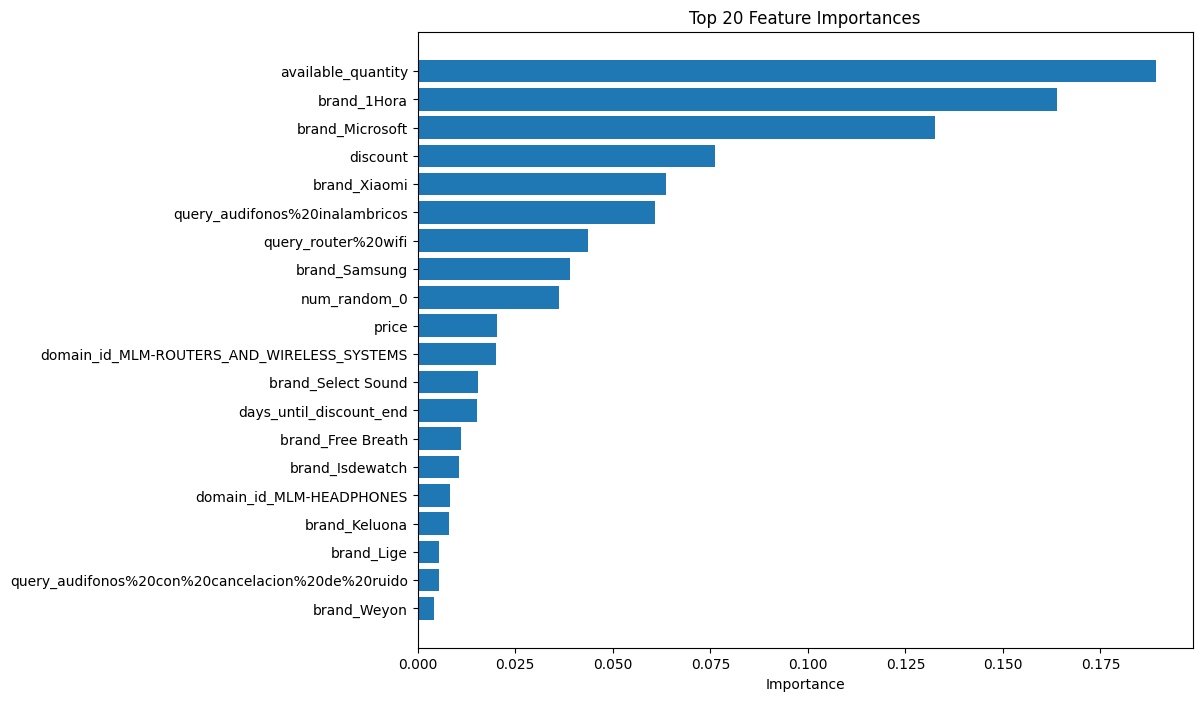

                                               Feature  Importance
0                                   available_quantity        0.19
1                                          brand_1Hora        0.16
2                                      brand_Microsoft        0.13
3                                             discount        0.08
4                                         brand_Xiaomi        0.06
5                       query_audifonos%20inalambricos        0.06
6                                  query_router%20wifi        0.04
7                                        brand_Samsung        0.04
8                                         num_random_0        0.04
9                                                price        0.02
10          domain_id_MLM-ROUTERS_AND_WIRELESS_SYSTEMS        0.02
11                                  brand_Select Sound        0.02
12                             days_until_discount_end        0.02
13                                   brand_Free Breath        

In [60]:
# Llamar a la función con el pipeline entrenado y mostrar las 10 características más importantes
feature_importances_df = plot_and_get_feature_importances(rf_best_model, X_train, N=20)

# Mostrar el DataFrame completo con todas las características y sus importancias
print(feature_importances_df)

Elegiremos el mejor estimador, en este caso es el XGBoost que obtuvimos de haber hecho una optimización bayesiana

In [70]:
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'available_quantity',
                                                   'insta...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [71]:
best_results["result"]["xgb_bayes"]

{'learning_rate': 0.017112418304028924,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 258}

In [72]:
#entrenamos con los mejores parametros que encontramos con bayes
xgb_params = best_results["result"]["xgb_bayes"]
xgb_model = XGBRegressor(
    learning_rate=xgb_params['learning_rate'],
    max_depth=int(xgb_params['max_depth']),  
    min_child_weight=int(xgb_params['min_child_weight']),  
    n_estimators=int(xgb_params['n_estimators']), 
    random_state=42
)

# Actualizar el pipeline con el modelo configurado
xgb_pipeline.named_steps['model'] = xgb_model

# Entrenar el pipeline con los datos
xgb_pipeline.fit(X_train, y_train)

best_model= xgb_pipeline.named_steps['model']

# Best features visualization

## Some features in the domain vs sold_quantity

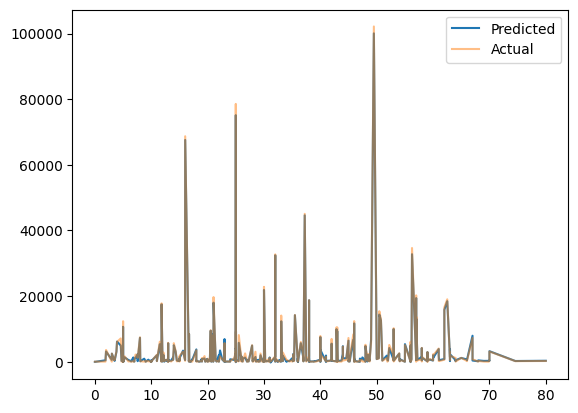

In [73]:
# Realizar predicciones usando el pipeline completo
bf = "discount"
domain = X_train[bf].sort_values().drop_duplicates()
domain_index = domain.index

# Predicciones con el pipeline completo para el train set
y_hat = xgb_pipeline.predict(X_train.loc[domain_index])
y = y_train.loc[domain_index.values]

# Graficar los resultados
plt.plot(domain.values, y_hat, label='Predicted')
plt.plot(domain.values, y, alpha=0.5, label='Actual')
plt.legend()
plt.show()

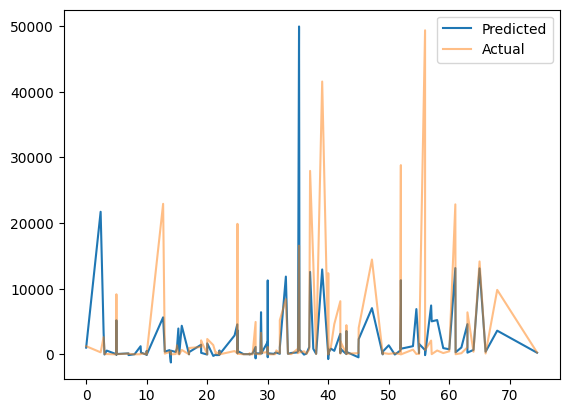

In [74]:
# Realizar predicciones usando el pipeline completo para el test set
bf = "discount"
domain = X_test[bf].sort_values().drop_duplicates()
domain_index = domain.index

y_hat = xgb_pipeline.predict(X_test.loc[domain_index])
y = y_test.loc[domain_index.values]

# Graficar los resultados
plt.plot(domain.values, y_hat, label='Predicted')
plt.plot(domain.values, y, alpha=0.5, label='Actual')
plt.legend()
plt.show()

## Shap for best model

In [77]:
model = xgb_pipeline.named_steps['model']
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

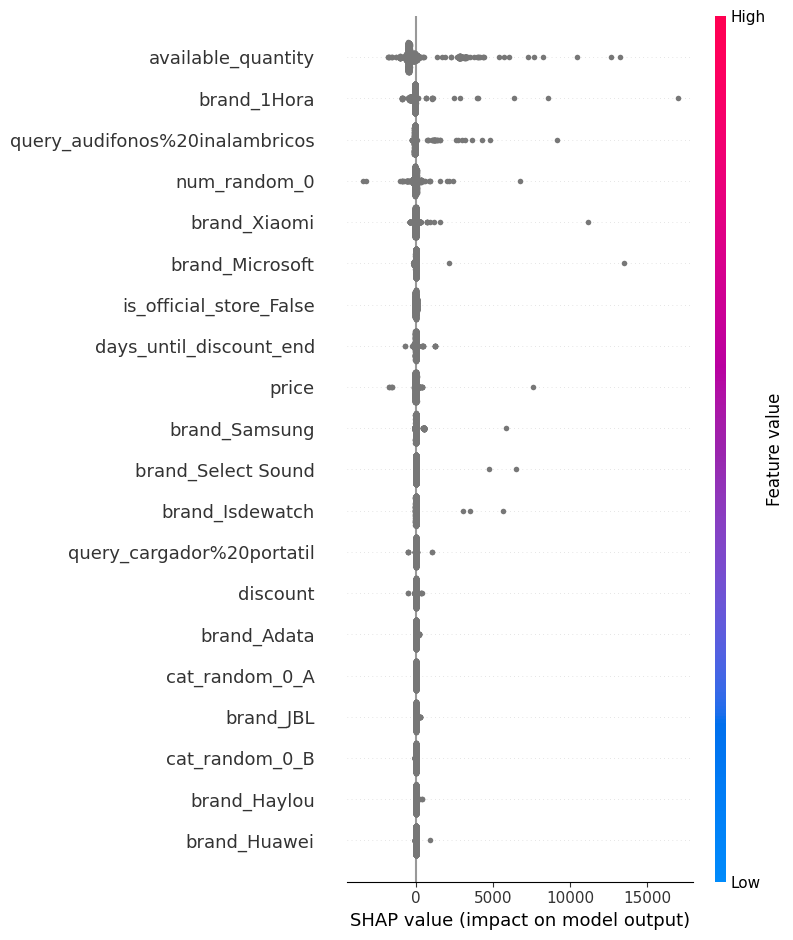

In [75]:
import shap

best_pipeline = xgb_grid_search.best_estimator_
explainer = shap.TreeExplainer(best_pipeline.named_steps['model'])

X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)


shap_values = explainer.shap_values(X_train_transformed,check_additivity=False)
num_quasinormal_features = best_pipeline.named_steps['preprocessor'].transformers_[0][2]
num_non_normal_features = best_pipeline.named_steps['preprocessor'].transformers_[1][2]
ohe = best_pipeline.named_steps['preprocessor'].transformers_[2][1]
cat_features = best_pipeline.named_steps['preprocessor'].transformers_[2][2]
ohe_features = ohe.get_feature_names_out(cat_features)
feature_names = np.concatenate([num_quasinormal_features, num_non_normal_features, ohe_features])
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

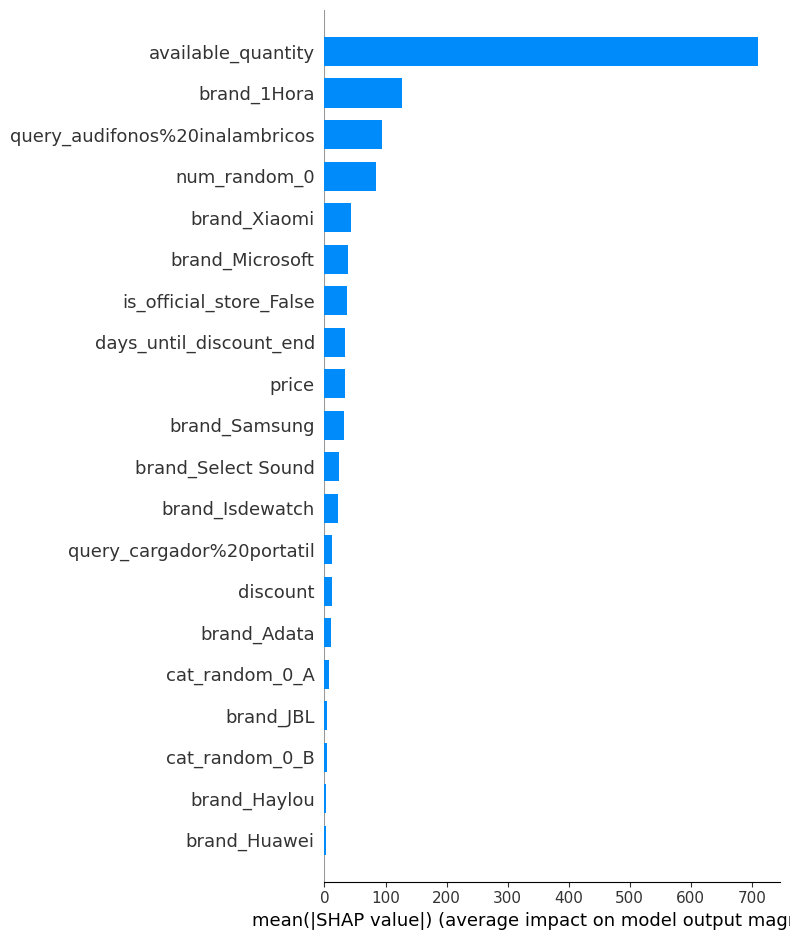

In [76]:
# Gráfico de Barras (Bar Plot)
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")

# Guardar los resultados

In [69]:
import joblib

bayes_best_rf_model = RandomForestRegressor(**best_results["result"]["rf_bayes"])
bayes_best_xgb_model = XGBRegressor(**best_results["result"]["xgb_bayes"])
bayes_best_lgbm_model = LGBMRegressor(**best_results["result"]["xgb_bayes"])

joblib.dump(bayes_best_rf_model,   f'3{numero_de_experimento}_bayes_best_random_forest_model.pkl')
joblib.dump(bayes_best_xgb_model,  f'3{numero_de_experimento}_bayes_best_xgboost_model.pkl')
joblib.dump(bayes_best_lgbm_model, f'3{numero_de_experimento}_bayes_best_lightgbm_model.pkl')


joblib.dump(best_results["result"]["rf_gr"],   f'3{numero_de_experimento}_CV_best_random_forest_model.pkl')
joblib.dump(best_results["result"]["xgb_gr"],  f'3{numero_de_experimento}_CV_best_xgboost_model.pkl')
joblib.dump(best_results["result"]["lgbm_gr"], f'3{numero_de_experimento}_CV_best_lightgbm_model.pkl')

['31_CV_best_lightgbm_model.pkl']